# Importing the Usable Libraries/package

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import os
os.getcwd()

'C:\\Users\\GrNat\\OneDrive\\Desktop\\ML\\greendeck assingment\\src'

# Reading the given 50 datasets saperatly

In [2]:
directory = "C:\\Users\\GrNat\\OneDrive\\Desktop\\ML\\greendeck assingment\\data\\dataset50"
files = []
for i in os.listdir(directory):
    path = os.path.join(directory, i)
    files.append(path)
#print(path)
#print(files)

In [3]:
#We have collected path of each dataset, now create a dictionary to store/read all the data
data = {}
for i in files:
    data[i] = pd.read_csv(i)

print(len(data))
#print(data)
data.values()

50


dict_values([     Unnamed: 0    value   timestamp
0             0  46.9182  1595323800
1             1  46.9255  1595327400
2             2  46.9373  1595331000
3             3  46.9441  1595334600
4             4  46.9644  1595338200
..          ...      ...         ...
835         835  47.9521  1598329800
836         836  47.9554  1598333400
837         837  47.9419  1598337000
838         838  47.9519  1598340600
839         839  47.9582  1598344200

[840 rows x 3 columns],      Unnamed: 0    value   timestamp
0             0  28.1641  1595323800
1             1  28.1823  1595327400
2             2  28.1979  1595331000
3             3  28.1641  1595334600
4             4  28.1771  1595338200
..          ...      ...         ...
835         835  28.5430  1598329800
836         836  28.5456  1598333400
837         837  28.5312  1598337000
838         838  28.5456  1598340600
839         839  28.5404  1598344200

[840 rows x 3 columns],      Unnamed: 0   value   timestamp
0            

In [4]:
for key in data:
    data[key].columns = ["Index","Values", "Timestamps"]
#print(data)

In [5]:
#To make the data look clean we are going the drop the "Index" column from the dataset because
#it is not a useful feature
for key in data:
    data[key] = data[key].drop(['Index'], axis = 1)
#print(data)

# At first lets take the first dataset and run some experiments on it. After we are done we can run our model through all the datasets later

In [6]:
first_key = list(data)
data0 = list(data.values())[0]
data0.head()

,Values,Timestamps
0,46.9182,1595323800
1,46.9255,1595327400
2,46.9373,1595331000
3,46.9441,1595334600
4,46.9644,1595338200


In [7]:
# we have to convert timestamps data into date time/readable format

for key in data:
    data[key].Timestamps = pd.to_datetime(data[key].Timestamps, unit="s")
data0.head()

,Values,Timestamps
0,46.9182,2020-07-21 09:30:00
1,46.9255,2020-07-21 10:30:00
2,46.9373,2020-07-21 11:30:00
3,46.9441,2020-07-21 12:30:00
4,46.9644,2020-07-21 13:30:00


# Create train & test sets for time series
It is a univariate time series, so we only have to make a split on one variable.


In [8]:
#this is just for demo on first dataset 
def train_test_timestamps(split_size, data0):
    split_point = int(split_size * len(data0))
    x_train, y_train = data0.Timestamps[:split_point], data0.Values[:split_point]
    x_test, y_test = data0.Timestamps[split_point:], data0.Values[split_point:]
    return x_train, y_train, x_test, y_test

x_train_demo, y_train_demo, x_test_demo, y_test_demo = train_test_timestamps(0.75, data0)

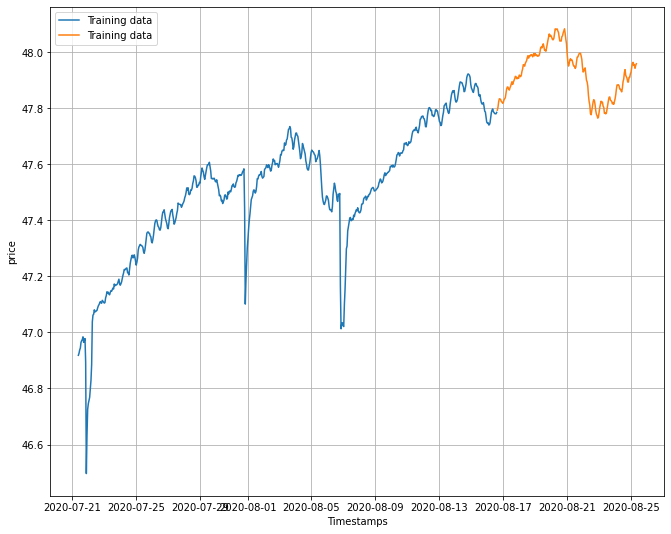

In [9]:
def plot_timeseries(timestamps, values, start=0, end=None, label=None):
    plt.plot(timestamps[start:end], values[start:end], label=label)
    plt.xlabel("Timestamps")
    plt.ylabel("price")
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(11,9))
plot_timeseries(x_train_demo, y_train_demo, label="Training data")
plot_timeseries(x_test_demo, y_test_demo, label="Training data")



# Evaluating a time series model

In the assignment, they asked MAE, MSE, RMSE, MAPE Evolution 

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from sktime's (Scikit-Learn for time series) MeanAbsoluteScaledError class which calculates the MASE.


In [10]:
def mean_absolute_scaled_error(real, pred):

  mae = tf.reduce_mean(tf.abs(real - pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(real[1:] - real[:-1]))

  return mae / mae_naive_no_season

In [11]:
def evolution_metrics(real, pred):
    pred = tf.reshape(pred, shape=(len(pred),))
    real = tf.reshape(real, shape=(len(real),))
   
    mae = tf.keras.metrics.mean_absolute_error(real, pred)
    mse = tf.keras.metrics.mean_squared_error(real, pred)
    rmse = tf.sqrt(mse)
    mape =  tf.keras.metrics.mean_absolute_percentage_error(real, pred)
    
    return {
        "mae" : mae.numpy(),
        "mse" : mse.numpy(),
        "rmse" : rmse.numpy(),        
        "mape" : mape.numpy()
    }

# Naive/Baseline Model


Let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.



In [12]:
#Naive Model directly predict the next value using past value
naive_forecast = y_test_demo[:-1]

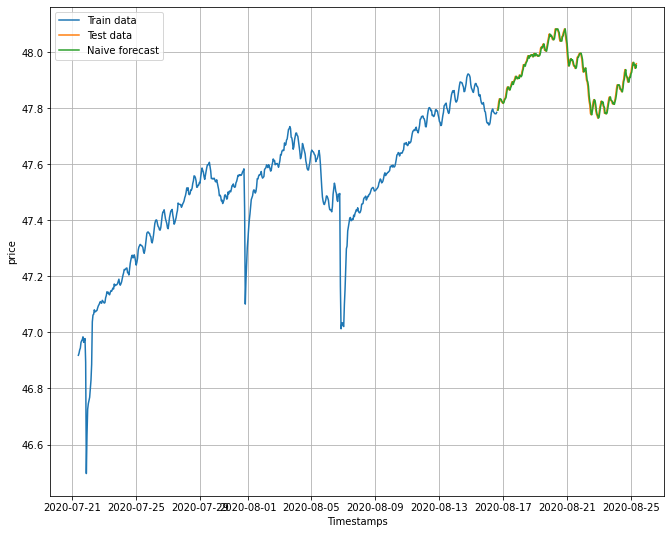

In [13]:
plt.figure(figsize=(11,9))
plot_timeseries(timestamps=x_train_demo, values=y_train_demo, label="Train data")
plot_timeseries(timestamps=x_test_demo, values=y_test_demo, label="Test data")
plot_timeseries(timestamps=x_test_demo[1:], values=naive_forecast,label="Naive forecast")

Evaluating our first/naive model

In [14]:
naive_results = evolution_metrics(y_test_demo[1:], naive_forecast)
naive_results

{'mae': 0.008833492822966556,
 'mse': 0.00012303301435406653,
 'rmse': 0.011092024808576049,
 'mape': 0.018434550730630918}

In [15]:
 naive_forecast

630    47.7926
631    47.8036
632    47.8228
633    47.8331
634    47.8325
        ...   
834    47.9630
835    47.9521
836    47.9554
837    47.9419
838    47.9519
Name: Values, Length: 209, dtype: float64

# Windowing dataset

Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:


            [0, 1, 2, 3, 4, 5, 6] -> [7]

Window size(input) - number of time steps of past data used to predict horizon.

Horizon(output) - number of time steps to predict in future.

In [16]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x, window_size=10, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

commodity_prices0 = data0.Values.values
timestamps0 = data0.Timestamps.values
demo_windows, demo_labels = make_windows(commodity_prices0)
demo_timestamp_windows, demo_timestamp_labels = make_windows(timestamps0)
print(demo_windows.shape)
print(demo_labels.shape)
print(demo_timestamp_windows.shape)
print(demo_timestamp_labels.shape)

(830, 10)
(830, 1)
(830, 10)
(830, 1)


# Turning windows into training and test sets

Time to turn our windows into training and test splits.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.



In [18]:
def train_test_split_values(input_windows, targets, test_split = 0.25):
    split_point = int(len(input_windows)*(1- test_split))
    train_windows = input_windows[:split_point]
    train_labels = targets[:split_point]
    test_windows = input_windows[split_point:]
    test_labels = targets[split_point:]
    return train_windows, test_windows, train_labels, test_labels

def train_test_split_timestamps(timestamp_labels, test_split = 0.25):
    split_point = int(len(timestamp_labels)*(1 - test_split))
    train_timestamps = timestamp_labels[:split_point]
    test_timestamps = timestamp_labels[split_point:]
    return train_timestamps, test_timestamps 

In [19]:
X_train0, x_test0, y_train0, y_test0 = train_test_split_values(demo_windows, demo_labels)
train_timestamps_0, test_timestamps_0 = train_test_split_timestamps(demo_timestamp_labels)
print(X_train0.shape)
print(y_train0.shape)
print(train_timestamps_0.shape)
print(test_timestamps_0.shape)

(622, 10)
(622, 1)
(622, 1)
(208, 1)


# We have splitted our data in train and test in suitable formate, we can start building our Nbeats model

We will create the Nbeatsblock layer followed by the Nbeats stack layer. the Nbeats stack layer will be using the Nbeats block layer. 


Took refrence from Daniel Bourke #youtube

In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [21]:
class NBeatsblock(tf.keras.layers.Layer):
    def __init__(self, input_size, forecast_horizon,no_neurons, no_layers,no_theta_neurons,**kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.forecast_horizon = forecast_horizon
        self.no_neurons = no_neurons
        self.no_layers = no_layers
        self.no_theta_neurons = no_theta_neurons
        #fully connected layers used in the Nbeats block
        self.fc_relu = [tf.keras.layers.Dense(self.no_neurons, activation = 'relu')for i in range(self.no_layers)]
        self.theta = tf.keras.layers.Dense(self.no_theta_neurons, activation ="linear")
    def call(self, inputs):
        x = inputs
        for i in self.fc_relu:
            x = i(x)
        theta_output= self.theta(x)
        backcast, forecast = theta_output[:,:self.input_size], theta_output[:, -self.forecast_horizon:]
        return backcast, forecast

In [22]:
class NbeatsStack(tf.keras.layers.Layer):
    def __init__(self,no_of_blocks,input_sp, block_input_size, block_forecast_horizon, no_block_layers, no_theta_neurons, **kwargs):
        self.no_of_blocks = no_of_blocks
        self.input_sp = input_sp
        self.block_input_size = block_input_size
        self.block_forecast_horizon = block_forecast_horizon
        self.no_block_layers = no_block_layers
        self.no_theta_neurons = no_theta_neurons
        self.input_layer = Input(shape = input_sp)
        self.nbeats_block_layer = NBeatsblock(input_size=block_input_size,  forecast_horizon = block_forecast_horizon,
        no_theta_neurons = no_theta_neurons, no_neurons=128,no_layers = no_block_layers )

        super().__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        backcast, forecast = self.nbeats_block_layer(x)
        residuals = tf.keras.layers.subtract([x, backcast])#residual connection between blocks
        #till the above line we have created the first block and in the for loop we will create the rest of the blocks with residual connections
        for i,j in enumerate(range(self.no_of_blocks)):
            backcast, block_forecast = self.nbeats_block_layer(residuals)
            residuals = tf.keras.layers.subtract([residuals, backcast])
            forecast = tf.keras.layers.add([forecast, block_forecast])

        return residuals, forecast

In [23]:
tf.keras.backend.clear_session()
Input_layer = Input(shape = X_train0.shape[1])
stack_layer = NbeatsStack(no_of_blocks=4, input_sp = X_train0.shape[1], block_input_size=10, block_forecast_horizon=1, no_block_layers=4, no_theta_neurons=11)
residuals_stack, forecast = stack_layer(Input_layer)
residuals = tf.keras.layers.subtract([Input_layer, residuals_stack])
for i in enumerate(range(10)):
    residuals_stack, stack_forecast = NbeatsStack(no_of_blocks=4, input_sp = X_train0.shape[1], block_input_size=10, block_forecast_horizon=1, no_block_layers=4, no_theta_neurons=11)(residuals)
    residuals = tf.keras.layers.subtract([residuals, residuals_stack])
    forecast = tf.keras.layers.add([forecast, stack_forecast])

model_nbeats = Model(inputs = Input_layer, outputs = forecast)
model_nbeats.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
nbeats_stack (NbeatsStack)      ((None, 10), (None,  52363       input_1[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 10)           0           input_1[0][0]                    
                                                                 nbeats_stack[0][0]               
__________________________________________________________________________________________________
nbeats_stack_1 (NbeatsStack)    ((None, 10), (None,  52363       subtract[0][0]               

# Using Adam optimizer

In [24]:
optimizer_nb = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model_nbeats.compile(optimizer=optimizer_nb, loss = 'mae', metrics = [tf.keras.metrics.RootMeanSquaredError()])
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=4, min_delta=0.001)
model_nbeats.fit(X_train0, y_train0, epochs=100, validation_data=(x_test0, y_test0), batch_size=batch_size)

Epoch 1/100
5/5 [==============================] - 39s 2s/step - loss: 71.3064 - root_mean_squared_error: 71.3758 - val_loss: 65.1783 - val_root_mean_squared_error: 65.1784
Epoch 2/100
5/5 [==============================] - 1s 283ms/step - loss: 60.6112 - root_mean_squared_error: 60.6795 - val_loss: 54.9003 - val_root_mean_squared_error: 54.9004
Epoch 3/100
5/5 [==============================] - 1s 287ms/step - loss: 50.6610 - root_mean_squared_error: 50.7321 - val_loss: 45.2614 - val_root_mean_squared_error: 45.2615
Epoch 4/100
5/5 [==============================] - 1s 284ms/step - loss: 41.3266 - root_mean_squared_error: 41.4044 - val_loss: 36.1361 - val_root_mean_squared_error: 36.1362
Epoch 5/100
5/5 [==============================] - 1s 289ms/step - loss: 32.3691 - root_mean_squared_error: 32.4645 - val_loss: 27.1624 - val_root_mean_squared_error: 27.1625
Epoch 6/100
5/5 [==============================] - 1s 283ms/step - loss: 23.5304 - root_mean_squared_error: 23.6553 - val_loss:

5/5 [==============================] - 2s 332ms/step - loss: 0.0540 - root_mean_squared_error: 0.0856 - val_loss: 0.0406 - val_root_mean_squared_error: 0.0517
Epoch 96/100
5/5 [==============================] - 2s 389ms/step - loss: 0.0566 - root_mean_squared_error: 0.0843 - val_loss: 0.0409 - val_root_mean_squared_error: 0.0520
Epoch 97/100
5/5 [==============================] - 2s 416ms/step - loss: 0.0857 - root_mean_squared_error: 0.1129 - val_loss: 0.1256 - val_root_mean_squared_error: 0.1307
Epoch 98/100
5/5 [==============================] - 2s 303ms/step - loss: 0.1048 - root_mean_squared_error: 0.1283 - val_loss: 0.0676 - val_root_mean_squared_error: 0.0743
Epoch 99/100
5/5 [==============================] - 1s 300ms/step - loss: 0.1117 - root_mean_squared_error: 0.1368 - val_loss: 0.0819 - val_root_mean_squared_error: 0.0897
Epoch 100/100
5/5 [==============================] - 1s 304ms/step - loss: 0.0634 - root_mean_squared_error: 0.0939 - val_loss: 0.0702 - val_root_mean_sq

In [25]:
nbeats_forecast = model_nbeats.predict(x_test0)

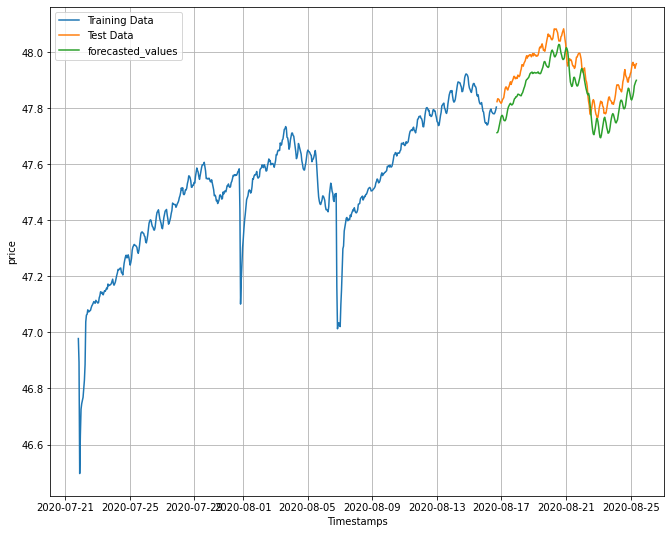

In [26]:
plt.figure(figsize=(11,9))
plot_timeseries(timestamps = train_timestamps_0, values = y_train0, label='Training Data')
plot_timeseries(timestamps= test_timestamps_0, values=y_test0, label = 'Test Data')
plot_timeseries(timestamps= test_timestamps_0, values= nbeats_forecast, label='forecasted_values')
plt.savefig('data0_.png')

Above this is nbeats model without revin on the first dataset 

# Start creating RevIN normalization and denormalization layer

In [27]:
class ReVIN_normalization(tf.keras.layers.Layer):
    def __init__(self, noise, **kwargs):
        super().__init__(**kwargs)
        self.noise = noise
        self.gamma = tf.Variable(initial_value = 0.1, trainable = True)
        self.beta = tf.Variable(initial_value = 0.1, trainable = True)
        
    
    def call(self,inputs):
        self.mean = tf.math.reduce_mean(inputs)
        self.variance = tf.math.reduce_variance(inputs)
        x = inputs
        x = (x - self.mean)/tf.math.sqrt(self.variance + self.noise)
        #for i in x:
         #   i = (i - self.mean)/tf.math.sqrt(self.variance+self.noise)
        transformed = self.gamma*x + self.beta
        #The below array denorm_array will return the parameters to the denormalisation layer to use.
        denorm_array = [self.mean, self.variance, self.gamma, self.beta, self.noise]
        
        return transformed,  denorm_array

In [28]:
#Here we are creating the denormalisation layer which takes in parameters from the normalisation layer.
class ReVinDenormalize(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        predictions, denorm_array = inputs
        mean = denorm_array[0]
        variance = denorm_array[1]
        gamma = denorm_array[2]
        beta = denorm_array[3]
        noise = denorm_array[4]
        retransformed = (predictions - beta)/gamma
        denormalized = mean + (retransformed*tf.math.sqrt(variance + noise))

        return denormalized

# Nbeats Model with RevIN Normalization

In [29]:
tf.keras.backend.clear_session()
#input layer
Input_layer = Input(shape = X_train0.shape[1])
#initialising the revin layer
revin_init = ReVIN_normalization(noise=0.01)
#Revin layer which is connected to the input layer
revin_layer, denorm_array = revin_init(Input_layer)
stack_layer = NbeatsStack(no_of_blocks=4, input_sp  = X_train0.shape[1], block_input_size=10, block_forecast_horizon=1, no_block_layers=4, no_theta_neurons=11)
#creating the first NBeats stack layer which takes normalised inputs from the revin layer
residuals_stack, forecast = stack_layer(revin_layer)
#residual connection
residuals = tf.keras.layers.subtract([revin_layer, residuals_stack])
#creating 10 more nbeats stacks
for i in enumerate(range(10)):
    residuals_stack, stack_forecast = NbeatsStack(no_of_blocks=4, input_sp = X_train0.shape[1], block_input_size=10, block_forecast_horizon=1, no_block_layers=4, no_theta_neurons=11)(residuals)
    residuals = tf.keras.layers.subtract([residuals, residuals_stack])
    forecast = tf.keras.layers.add([forecast, stack_forecast])
#The global forecast from the nbeats stack goes into the denormalisation layer    
denorm_init = ReVinDenormalize()
denorm_layer = denorm_init([forecast, denorm_array])
model_nbeats_revin = Model(inputs = Input_layer, outputs = denorm_layer)
model_nbeats_revin.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
re_vin_normalization (ReVIN_nor ((None, 10), [(), () 2           input_1[0][0]                    
__________________________________________________________________________________________________
nbeats_stack (NbeatsStack)      ((None, 10), (None,  52363       re_vin_normalization[0][0]       
__________________________________________________________________________________________________
subtract (Subtract)             (None, 10)           0           re_vin_normalization[0][0]       
                                                                 nbeats_stack[0][0]           

In [30]:
from keras.callbacks import ModelCheckpoint
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        if logs.get('val_root_mean_squared_error') <= 0.02:
            self.model.stop_training = True
            

In [31]:
#choosing a low learning rate since it's a regression problem.
optimizer_nb = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model_nbeats_revin.compile(optimizer=optimizer_nb, loss = 'mae', metrics = [tf.keras.metrics.RootMeanSquaredError()])
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=2, min_delta=0.01)
model_nbeats_revin.fit(X_train0, y_train0, epochs=100, validation_data=(x_test0, y_test0), batch_size=batch_size, callbacks=CustomCallback())

Epoch 1/100
5/5 [==============================] - 40s 2s/step - loss: 0.1623 - root_mean_squared_error: 0.2255 - val_loss: 0.0330 - val_root_mean_squared_error: 0.0420
Epoch 2/100
5/5 [==============================] - 1s 293ms/step - loss: 0.0563 - root_mean_squared_error: 0.0908 - val_loss: 0.0363 - val_root_mean_squared_error: 0.0403
Epoch 3/100
5/5 [==============================] - 2s 316ms/step - loss: 0.0544 - root_mean_squared_error: 0.0740 - val_loss: 0.0299 - val_root_mean_squared_error: 0.0345
Epoch 4/100
5/5 [==============================] - 1s 302ms/step - loss: 0.0487 - root_mean_squared_error: 0.0691 - val_loss: 0.0275 - val_root_mean_squared_error: 0.0310
Epoch 5/100
5/5 [==============================] - 1s 290ms/step - loss: 0.0523 - root_mean_squared_error: 0.0688 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0249
Epoch 6/100
5/5 [==============================] - 1s 285ms/step - loss: 0.0426 - root_mean_squared_error: 0.0577 - val_loss: 0.0223 - val_root_mea

In [32]:
nbeats_revin_forecast = model_nbeats_revin.predict(x_test0)

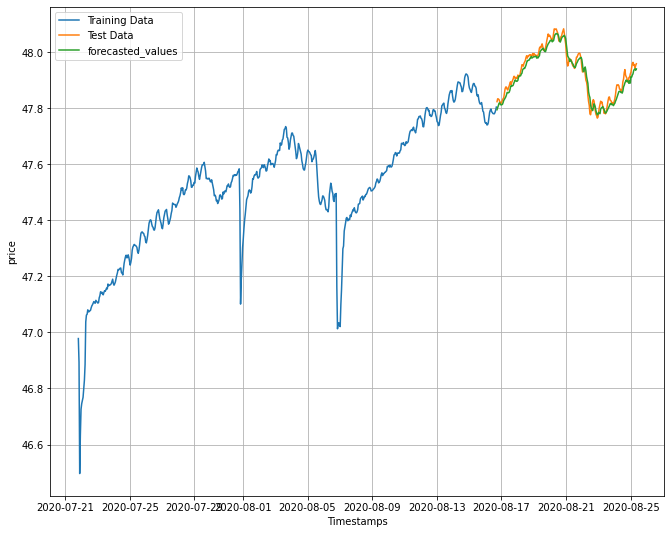

In [33]:
plt.figure(figsize=(11,9))
plot_timeseries(timestamps = train_timestamps_0, values = y_train0, label='Training Data')
plot_timeseries(timestamps= test_timestamps_0, values=y_test0, label = 'Test Data')
plot_timeseries(timestamps= test_timestamps_0, values= nbeats_revin_forecast, label='forecasted_values')
plt.savefig("data0.png")

# Now above this is our nbeats model with revin on the first dataset. as you can see a clear difference between forecasted_values from both graph above. That means model with revin layer gives better accuracy as compared to normal nbeats model.

In [34]:
X_train = {}
y_train = {}
x_test = {}
y_test = {}
train_timestamps = {}
test_timestamps = {}


for key in data:
    dataset = data[key]
    commodity_prices = dataset.Values.values
    timestamps_all = dataset.Timestamps.values
    windows, labels = make_windows(commodity_prices)
    timestamp_windows, timestamp_labels = make_windows(timestamps_all)
    X_train_i, x_test_i, y_train_i, y_test_i = train_test_split_values(windows, labels)
    train_timestamps_i, test_timestamps_i = train_test_split_timestamps(timestamp_labels)
    X_train[key] = X_train_i
    y_train[key] = y_train_i
    x_test[key] = x_test_i
    y_test[key] = y_test_i
    train_timestamps[key] = train_timestamps_i
    test_timestamps[key] = test_timestamps_i

In [35]:
std_dev_all = []
for key in data:
    std_dev = np.std(data[key].Values.values)
    std_dev_all.append(std_dev)

print(std_dev_all)

[0.2758782146732368, 0.10612596948989468, 0.13245836220878413, 0.10687978259869672, 9434.831398731681, 3775529.5174236074, 0.4057117450192855, 0.4949352460852432, 1.0582202765016329, 0.21761399342231139, 14443.989134960664, 0.13847079884948166, 1.0067651872854622, 21.04301002994161, 52034.34903281987, 14668.946132375098, 7524.112823092595, 1.0433991663839195, 50.55404585066113, 4212.911721131408, 1.9286532955420412, 156111.75186235394, 164987.86701521662, 100.75535052366354, 1.4298357272771007, 20187.851842320353, 7733.479576516344, 11.288920539115985, 59723.461748751346, 59.24313705567199, 0.17487391815146616, 1.2580066851408727, 2.8613352526855067, 0.5122902352487316, 0.0, 14134.32383706202, 30.887956268441084, 0.6287055349002655, 0.40020309204149906, 0.5223098732884209, 20538878936.558327, 1121.245593073723, 0.294833077968558, 3579.319111506209, 3559277.1959661143, 1.9286532955420412, 20534215473.80213, 263.8212673653229, 7733.479576516344, 13606.044184325341]


#  AS we trained our model on first dataset. Now we will train our model on rest of data and plot them.

In [36]:
def get_model():
    Input_layer = Input(shape = X_train0.shape[1])
    #initialising the revin layer
    revin_init = ReVIN_normalization(noise=0.01)
    #Revin layer which is connected to the input layer
    revin_layer, denorm_array = revin_init(Input_layer)
    stack_layer = NbeatsStack(no_of_blocks=4, input_sp  = X_train0.shape[1], block_input_size=10, block_forecast_horizon=1, no_block_layers=4, no_theta_neurons=11)
    #creating the first NBeats stack layer which takes normalised inputs from the revin layer
    residuals_stack, forecast = stack_layer(revin_layer)
    #residual connection
    residuals = tf.keras.layers.subtract([revin_layer, residuals_stack])
    #creating 10 more nbeats stacks
    for i in enumerate(range(10)):
        residuals_stack, stack_forecast = NbeatsStack(no_of_blocks=4, input_sp = X_train0.shape[1], block_input_size=10, block_forecast_horizon=1, no_block_layers=4, no_theta_neurons=11)(residuals)
        residuals = tf.keras.layers.subtract([residuals, residuals_stack])
        forecast = tf.keras.layers.add([forecast, stack_forecast])
    #The global forecast from the nbeats stack goes into the denormalisation layer    
    denorm_init = ReVinDenormalize()
    denorm_layer = denorm_init([forecast, denorm_array])
    model_nbeats_revin = Model(inputs = Input_layer, outputs = denorm_layer)

    return model_nbeats_revin

# Fitting Nbeats Model with RevIN Normalization all the datasets

In [37]:
all_models = {}
for key in data:
    temp_model = get_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
    checkpoint_filepath = "checkpoints/"+ str(key)
    callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_root_mean_squared_error', save_best_only=True, filepath=checkpoint_filepath)
    temp_model.compile(optimizer=optimizer_nb, loss = 'mae', metrics = [tf.keras.metrics.RootMeanSquaredError()])
    temp_model.fit(X_train[key], y_train[key], validation_data = (x_test[key], y_test[key]), epochs = 50, batch_size=128,callbacks = callback_checkpoint)
    all_models[key] = temp_model
    print("*"*100)

Epoch 1/50
5/5 [==============================] - 35s 2s/step - loss: 0.1718 - root_mean_squared_error: 0.2287 - val_loss: 0.0406 - val_root_mean_squared_error: 0.0498


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 1s 278ms/step - loss: 0.0699 - root_mean_squared_error: 0.0971 - val_loss: 0.0311 - val_root_mean_squared_error: 0.0368


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 2s 321ms/step - loss: 0.0579 - root_mean_squared_error: 0.0813 - val_loss: 0.0242 - val_root_mean_squared_error: 0.0305


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 2s 405ms/step - loss: 0.0449 - root_mean_squared_error: 0.0684 - val_loss: 0.0217 - val_root_mean_squared_error: 0.0281


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 2s 323ms/step - loss: 0.0417 - root_mean_squared_error: 0.0626 - val_loss: 0.0229 - val_root_mean_squared_error: 0.0286
Epoch 6/50
5/5 [==============================] - 2s 321ms/step - loss: 0.0435 - root_mean_squared_error: 0.0642 - val_loss: 0.0311 - val_root_mean_squared_error: 0.0358
Epoch 7/50
5/5 [==============================] - 2s 324ms/step - loss: 0.0419 - root_mean_squared_error: 0.0603 - val_loss: 0.0231 - val_root_mean_squared_error: 0.0284
Epoch 8/50
5/5 [==============================] - 2s 362ms/step - loss: 0.0335 - root_mean_squared_error: 0.0526 - val_loss: 0.0201 - val_root_mean_squared_error: 0.0253


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 1s 304ms/step - loss: 0.0284 - root_mean_squared_error: 0.0477 - val_loss: 0.0191 - val_root_mean_squared_error: 0.0238


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 2s 388ms/step - loss: 0.0276 - root_mean_squared_error: 0.0468 - val_loss: 0.0211 - val_root_mean_squared_error: 0.0253
Epoch 11/50
5/5 [==============================] - 2s 358ms/step - loss: 0.0289 - root_mean_squared_error: 0.0459 - val_loss: 0.0191 - val_root_mean_squared_error: 0.0229


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 2s 334ms/step - loss: 0.0244 - root_mean_squared_error: 0.0425 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0191


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 1s 303ms/step - loss: 0.0194 - root_mean_squared_error: 0.0393 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0175


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 2s 336ms/step - loss: 0.0198 - root_mean_squared_error: 0.0381 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0163


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 2s 507ms/step - loss: 0.0172 - root_mean_squared_error: 0.0366 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0163
Epoch 16/50
5/5 [==============================] - 2s 438ms/step - loss: 0.0202 - root_mean_squared_error: 0.0378 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0170
Epoch 17/50
5/5 [==============================] - 2s 378ms/step - loss: 0.0177 - root_mean_squared_error: 0.0357 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0150


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 2s 385ms/step - loss: 0.0157 - root_mean_squared_error: 0.0344 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0144


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 2s 392ms/step - loss: 0.0173 - root_mean_squared_error: 0.0346 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0151
Epoch 20/50
5/5 [==============================] - 2s 388ms/step - loss: 0.0191 - root_mean_squared_error: 0.0362 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0171
Epoch 21/50
5/5 [==============================] - 2s 385ms/step - loss: 0.0230 - root_mean_squared_error: 0.0391 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0148
Epoch 22/50
5/5 [==============================] - 2s 440ms/step - loss: 0.0368 - root_mean_squared_error: 0.0502 - val_loss: 0.0254 - val_root_mean_squared_error: 0.0292
Epoch 23/50
5/5 [==============================] - 2s 399ms/step - loss: 0.0572 - root_mean_squared_error: 0.0667 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0158
Epoch 24/50
5/5 [==============================] - 2s 431ms/step - loss: 0.0484 - root_mean_squared_error: 0.0637 - val_loss: 0.0248 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/50
5/5 [==============================] - 2s 462ms/step - loss: 0.0155 - root_mean_squared_error: 0.0322 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0135


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/50
5/5 [==============================] - 2s 441ms/step - loss: 0.0130 - root_mean_squared_error: 0.0316 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0131


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 2s 386ms/step - loss: 0.0145 - root_mean_squared_error: 0.0323 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0131


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 2s 424ms/step - loss: 0.0168 - root_mean_squared_error: 0.0339 - val_loss: 0.0164 - val_root_mean_squared_error: 0.0186
Epoch 36/50
5/5 [==============================] - 2s 428ms/step - loss: 0.0227 - root_mean_squared_error: 0.0378 - val_loss: 0.0170 - val_root_mean_squared_error: 0.0194
Epoch 37/50
5/5 [==============================] - 2s 460ms/step - loss: 0.0239 - root_mean_squared_error: 0.0375 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0183
Epoch 38/50
5/5 [==============================] - 2s 451ms/step - loss: 0.0216 - root_mean_squared_error: 0.0369 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0162
Epoch 39/50
5/5 [==============================] - 2s 469ms/step - loss: 0.0199 - root_mean_squared_error: 0.0358 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0153
Epoch 40/50
5/5 [==============================] - 2s 449ms/step - loss: 0.0191 - root_mean_squared_error: 0.0349 - val_loss: 0.0150 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/50
5/5 [==============================] - 2s 416ms/step - loss: 0.0124 - root_mean_squared_error: 0.0313 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0131
Epoch 45/50
5/5 [==============================] - 2s 410ms/step - loss: 0.0135 - root_mean_squared_error: 0.0310 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0133
Epoch 46/50
5/5 [==============================] - 2s 413ms/step - loss: 0.0129 - root_mean_squared_error: 0.0320 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0128


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 47/50
5/5 [==============================] - 2s 442ms/step - loss: 0.0128 - root_mean_squared_error: 0.0309 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0129
Epoch 48/50
5/5 [==============================] - 2s 433ms/step - loss: 0.0154 - root_mean_squared_error: 0.0319 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0142
Epoch 49/50
5/5 [==============================] - 2s 413ms/step - loss: 0.0178 - root_mean_squared_error: 0.0335 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0131
Epoch 50/50
5/5 [==============================] - 2s 436ms/step - loss: 0.0149 - root_mean_squared_error: 0.0321 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0142
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 37s 3s/step - loss: 0.0705 - root_mean_squared_error: 0.0910 - val_loss: 0.0267 - val_root_mean_squared_error: 0.0304


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 2s 388ms/step - loss: 0.0255 - root_mean_squared_error: 0.0315 - val_loss: 0.0276 - val_root_mean_squared_error: 0.0310
Epoch 3/50
5/5 [==============================] - 2s 388ms/step - loss: 0.0207 - root_mean_squared_error: 0.0255 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0133


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 2s 403ms/step - loss: 0.0158 - root_mean_squared_error: 0.0195 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0122


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 2s 490ms/step - loss: 0.0152 - root_mean_squared_error: 0.0191 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0154
Epoch 6/50
5/5 [==============================] - 3s 612ms/step - loss: 0.0145 - root_mean_squared_error: 0.0178 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0198
Epoch 7/50
5/5 [==============================] - 2s 443ms/step - loss: 0.0185 - root_mean_squared_error: 0.0220 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0164
Epoch 8/50
5/5 [==============================] - 3s 545ms/step - loss: 0.0126 - root_mean_squared_error: 0.0160 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0148
Epoch 9/50
5/5 [==============================] - 3s 546ms/step - loss: 0.0143 - root_mean_squared_error: 0.0173 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0166
Epoch 10/50
5/5 [==============================] - 2s 494ms/step - loss: 0.0122 - root_mean_squared_error: 0.0154 - val_loss: 0.0073 - val_root_mean_s

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 2s 403ms/step - loss: 0.0096 - root_mean_squared_error: 0.0127 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0123
Epoch 12/50
5/5 [==============================] - 2s 473ms/step - loss: 0.0092 - root_mean_squared_error: 0.0125 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0094


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 2s 388ms/step - loss: 0.0081 - root_mean_squared_error: 0.0109 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0093


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 3s 595ms/step - loss: 0.0080 - root_mean_squared_error: 0.0109 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0096
Epoch 15/50
5/5 [==============================] - 3s 671ms/step - loss: 0.0080 - root_mean_squared_error: 0.0109 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0093


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 2s 431ms/step - loss: 0.0076 - root_mean_squared_error: 0.0104 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0093
Epoch 17/50
5/5 [==============================] - 2s 451ms/step - loss: 0.0073 - root_mean_squared_error: 0.0102 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0094
Epoch 18/50
5/5 [==============================] - 2s 452ms/step - loss: 0.0083 - root_mean_squared_error: 0.0109 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0103
Epoch 19/50
5/5 [==============================] - 2s 447ms/step - loss: 0.0094 - root_mean_squared_error: 0.0123 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0093
Epoch 20/50
5/5 [==============================] - 2s 460ms/step - loss: 0.0080 - root_mean_squared_error: 0.0107 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0092


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 2s 439ms/step - loss: 0.0073 - root_mean_squared_error: 0.0100 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0093
Epoch 22/50
5/5 [==============================] - 2s 441ms/step - loss: 0.0074 - root_mean_squared_error: 0.0101 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0092
Epoch 23/50
5/5 [==============================] - 2s 440ms/step - loss: 0.0074 - root_mean_squared_error: 0.0102 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0097
Epoch 24/50
5/5 [==============================] - 2s 439ms/step - loss: 0.0084 - root_mean_squared_error: 0.0115 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0091


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 2s 498ms/step - loss: 0.0077 - root_mean_squared_error: 0.0104 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0097
Epoch 26/50
5/5 [==============================] - 2s 510ms/step - loss: 0.0076 - root_mean_squared_error: 0.0104 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0093
Epoch 27/50
5/5 [==============================] - 2s 508ms/step - loss: 0.0073 - root_mean_squared_error: 0.0099 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0092
Epoch 28/50
5/5 [==============================] - 3s 526ms/step - loss: 0.0075 - root_mean_squared_error: 0.0102 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0119
Epoch 29/50
5/5 [==============================] - 3s 569ms/step - loss: 0.0085 - root_mean_squared_error: 0.0117 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0097
Epoch 30/50
5/5 [==============================] - 3s 624ms/step - loss: 0.0078 - root_mean_squared_error: 0.0104 - val_loss: 0.0066 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 613ms/step - loss: 0.0987 - root_mean_squared_error: 0.1388 - val_loss: 0.0832 - val_root_mean_squared_error: 0.1184


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 580ms/step - loss: 0.0668 - root_mean_squared_error: 0.1025 - val_loss: 0.0724 - val_root_mean_squared_error: 0.1113


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 601ms/step - loss: 0.0608 - root_mean_squared_error: 0.0930 - val_loss: 0.0670 - val_root_mean_squared_error: 0.1101


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 573ms/step - loss: 0.0547 - root_mean_squared_error: 0.0908 - val_loss: 0.0678 - val_root_mean_squared_error: 0.1086


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 3s 632ms/step - loss: 0.0463 - root_mean_squared_error: 0.0803 - val_loss: 0.0672 - val_root_mean_squared_error: 0.1079


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 3s 543ms/step - loss: 0.0436 - root_mean_squared_error: 0.0769 - val_loss: 0.0659 - val_root_mean_squared_error: 0.1082
Epoch 8/50
5/5 [==============================] - 3s 517ms/step - loss: 0.0444 - root_mean_squared_error: 0.0770 - val_loss: 0.0667 - val_root_mean_squared_error: 0.1076


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 3s 529ms/step - loss: 0.0390 - root_mean_squared_error: 0.0715 - val_loss: 0.0663 - val_root_mean_squared_error: 0.1077
Epoch 10/50
5/5 [==============================] - 3s 523ms/step - loss: 0.0378 - root_mean_squared_error: 0.0709 - val_loss: 0.0646 - val_root_mean_squared_error: 0.1064


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 3s 646ms/step - loss: 0.0377 - root_mean_squared_error: 0.0709 - val_loss: 0.0683 - val_root_mean_squared_error: 0.1080
Epoch 12/50
5/5 [==============================] - 3s 653ms/step - loss: 0.0375 - root_mean_squared_error: 0.0690 - val_loss: 0.0670 - val_root_mean_squared_error: 0.1096
Epoch 13/50
5/5 [==============================] - 3s 710ms/step - loss: 0.0405 - root_mean_squared_error: 0.0714 - val_loss: 0.0697 - val_root_mean_squared_error: 0.1118
Epoch 14/50
5/5 [==============================] - 4s 850ms/step - loss: 0.0397 - root_mean_squared_error: 0.0705 - val_loss: 0.0683 - val_root_mean_squared_error: 0.1108
Epoch 15/50
5/5 [==============================] - 3s 706ms/step - loss: 0.0383 - root_mean_squared_error: 0.0675 - val_loss: 0.0670 - val_root_mean_squared_error: 0.1094
Epoch 16/50
5/5 [==============================] - 4s 752ms/step - loss: 0.0388 - root_mean_squared_error: 0.0695 - val_loss: 0.0688 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 670ms/step - loss: 0.0967 - root_mean_squared_error: 0.1148 - val_loss: 0.0769 - val_root_mean_squared_error: 0.0860


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 690ms/step - loss: 0.0720 - root_mean_squared_error: 0.0844 - val_loss: 0.0563 - val_root_mean_squared_error: 0.0657


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 734ms/step - loss: 0.0460 - root_mean_squared_error: 0.0574 - val_loss: 0.0296 - val_root_mean_squared_error: 0.0379


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 651ms/step - loss: 0.0390 - root_mean_squared_error: 0.0492 - val_loss: 0.0277 - val_root_mean_squared_error: 0.0365


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 765ms/step - loss: 0.0312 - root_mean_squared_error: 0.0404 - val_loss: 0.0281 - val_root_mean_squared_error: 0.0370
Epoch 7/50
5/5 [==============================] - 3s 657ms/step - loss: 0.0272 - root_mean_squared_error: 0.0361 - val_loss: 0.0297 - val_root_mean_squared_error: 0.0385
Epoch 8/50
5/5 [==============================] - 4s 875ms/step - loss: 0.0271 - root_mean_squared_error: 0.0358 - val_loss: 0.0305 - val_root_mean_squared_error: 0.0396
Epoch 9/50
5/5 [==============================] - 4s 919ms/step - loss: 0.0242 - root_mean_squared_error: 0.0329 - val_loss: 0.0272 - val_root_mean_squared_error: 0.0362


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 4s 899ms/step - loss: 0.0218 - root_mean_squared_error: 0.0305 - val_loss: 0.0242 - val_root_mean_squared_error: 0.0333


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 3s 522ms/step - loss: 0.0203 - root_mean_squared_error: 0.0297 - val_loss: 0.0241 - val_root_mean_squared_error: 0.0329


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 3s 630ms/step - loss: 0.0206 - root_mean_squared_error: 0.0301 - val_loss: 0.0243 - val_root_mean_squared_error: 0.0334
Epoch 13/50
5/5 [==============================] - 3s 625ms/step - loss: 0.0185 - root_mean_squared_error: 0.0277 - val_loss: 0.0232 - val_root_mean_squared_error: 0.0324


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 3s 720ms/step - loss: 0.0187 - root_mean_squared_error: 0.0278 - val_loss: 0.0272 - val_root_mean_squared_error: 0.0360
Epoch 15/50
5/5 [==============================] - 3s 686ms/step - loss: 0.0185 - root_mean_squared_error: 0.0281 - val_loss: 0.0241 - val_root_mean_squared_error: 0.0331
Epoch 16/50
5/5 [==============================] - 3s 664ms/step - loss: 0.0198 - root_mean_squared_error: 0.0287 - val_loss: 0.0259 - val_root_mean_squared_error: 0.0349
Epoch 17/50
5/5 [==============================] - 3s 652ms/step - loss: 0.0206 - root_mean_squared_error: 0.0293 - val_loss: 0.0240 - val_root_mean_squared_error: 0.0328
Epoch 18/50
5/5 [==============================] - 3s 621ms/step - loss: 0.0197 - root_mean_squared_error: 0.0289 - val_loss: 0.0246 - val_root_mean_squared_error: 0.0333
Epoch 19/50
5/5 [==============================] - 3s 640ms/step - loss: 0.0184 - root_mean_squared_error: 0.0276 - val_loss: 0.0249 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 3s 662ms/step - loss: 0.0165 - root_mean_squared_error: 0.0261 - val_loss: 0.0240 - val_root_mean_squared_error: 0.0332
Epoch 22/50
5/5 [==============================] - 4s 754ms/step - loss: 0.0168 - root_mean_squared_error: 0.0263 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0329
Epoch 23/50
5/5 [==============================] - 4s 843ms/step - loss: 0.0166 - root_mean_squared_error: 0.0257 - val_loss: 0.0259 - val_root_mean_squared_error: 0.0347
Epoch 24/50
5/5 [==============================] - 3s 707ms/step - loss: 0.0193 - root_mean_squared_error: 0.0278 - val_loss: 0.0234 - val_root_mean_squared_error: 0.0324
Epoch 25/50
5/5 [==============================] - 4s 784ms/step - loss: 0.0198 - root_mean_squared_error: 0.0291 - val_loss: 0.0252 - val_root_mean_squared_error: 0.0346
Epoch 26/50
5/5 [==============================] - 4s 748ms/step - loss: 0.0197 - root_mean_squared_error: 0.0284 - val_loss: 0.0238 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 3s 657ms/step - loss: 0.0158 - root_mean_squared_error: 0.0250 - val_loss: 0.0245 - val_root_mean_squared_error: 0.0334
Epoch 29/50
5/5 [==============================] - 3s 696ms/step - loss: 0.0164 - root_mean_squared_error: 0.0254 - val_loss: 0.0237 - val_root_mean_squared_error: 0.0328
Epoch 30/50
5/5 [==============================] - 3s 648ms/step - loss: 0.0161 - root_mean_squared_error: 0.0253 - val_loss: 0.0228 - val_root_mean_squared_error: 0.0322
Epoch 31/50
5/5 [==============================] - 3s 653ms/step - loss: 0.0154 - root_mean_squared_error: 0.0251 - val_loss: 0.0236 - val_root_mean_squared_error: 0.0327
Epoch 32/50
5/5 [==============================] - 3s 645ms/step - loss: 0.0157 - root_mean_squared_error: 0.0251 - val_loss: 0.0225 - val_root_mean_squared_error: 0.0319
Epoch 33/50
5/5 [==============================] - 3s 638ms/step - loss: 0.0154 - root_mean_squared_error: 0.0248 - val_loss: 0.0240 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 681ms/step - loss: 6170.3462 - root_mean_squared_error: 7638.1851 - val_loss: 4920.1035 - val_root_mean_squared_error: 6090.4336


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 673ms/step - loss: 4270.3247 - root_mean_squared_error: 5481.4043 - val_loss: 3211.1516 - val_root_mean_squared_error: 3924.3704


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 677ms/step - loss: 4127.1758 - root_mean_squared_error: 5109.0713 - val_loss: 2866.0552 - val_root_mean_squared_error: 3582.4241


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 691ms/step - loss: 3291.4783 - root_mean_squared_error: 4243.2114 - val_loss: 2325.2148 - val_root_mean_squared_error: 2929.2732


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 3s 661ms/step - loss: 2848.5205 - root_mean_squared_error: 3867.3877 - val_loss: 2266.1550 - val_root_mean_squared_error: 2864.1892


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 3s 616ms/step - loss: 2440.8027 - root_mean_squared_error: 3434.3108 - val_loss: 2071.9004 - val_root_mean_squared_error: 2686.9395


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 3s 597ms/step - loss: 2179.3015 - root_mean_squared_error: 3123.0728 - val_loss: 1985.5684 - val_root_mean_squared_error: 2567.1179


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 3s 615ms/step - loss: 1989.6544 - root_mean_squared_error: 2954.7217 - val_loss: 2019.1412 - val_root_mean_squared_error: 2579.2627
Epoch 10/50
5/5 [==============================] - 3s 614ms/step - loss: 1888.6813 - root_mean_squared_error: 2807.1492 - val_loss: 1872.2258 - val_root_mean_squared_error: 2451.5493


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 3s 622ms/step - loss: 2008.5485 - root_mean_squared_error: 2921.8818 - val_loss: 1763.8558 - val_root_mean_squared_error: 2326.0098


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 3s 604ms/step - loss: 1926.4336 - root_mean_squared_error: 2835.3628 - val_loss: 1737.0807 - val_root_mean_squared_error: 2272.8438


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 662ms/step - loss: 1771.8455 - root_mean_squared_error: 2678.4172 - val_loss: 1665.0352 - val_root_mean_squared_error: 2218.2412


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 3s 606ms/step - loss: 1843.1195 - root_mean_squared_error: 2790.3076 - val_loss: 1530.1108 - val_root_mean_squared_error: 2080.9709


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 3s 614ms/step - loss: 1790.4623 - root_mean_squared_error: 2731.2380 - val_loss: 1618.5068 - val_root_mean_squared_error: 2076.8762


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 3s 709ms/step - loss: 1666.6063 - root_mean_squared_error: 2579.9268 - val_loss: 1686.7876 - val_root_mean_squared_error: 2171.8235
Epoch 17/50
5/5 [==============================] - 3s 710ms/step - loss: 1683.2031 - root_mean_squared_error: 2541.4873 - val_loss: 1703.6056 - val_root_mean_squared_error: 2110.3169
Epoch 18/50
5/5 [==============================] - 4s 719ms/step - loss: 1856.7521 - root_mean_squared_error: 2692.2346 - val_loss: 1472.7295 - val_root_mean_squared_error: 2069.5051


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 4s 738ms/step - loss: 1571.4244 - root_mean_squared_error: 2488.7673 - val_loss: 1949.5361 - val_root_mean_squared_error: 2407.0476
Epoch 20/50
5/5 [==============================] - 3s 709ms/step - loss: 1797.9901 - root_mean_squared_error: 2583.9680 - val_loss: 1582.8330 - val_root_mean_squared_error: 2006.0076


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 3s 709ms/step - loss: 1524.8193 - root_mean_squared_error: 2439.8049 - val_loss: 1327.6255 - val_root_mean_squared_error: 1729.5376


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 3s 704ms/step - loss: 1479.4452 - root_mean_squared_error: 2345.2827 - val_loss: 1394.3789 - val_root_mean_squared_error: 1781.9442
Epoch 23/50
5/5 [==============================] - 3s 698ms/step - loss: 1413.2765 - root_mean_squared_error: 2316.7354 - val_loss: 1205.1973 - val_root_mean_squared_error: 1644.4735


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 4s 771ms/step - loss: 1296.5483 - root_mean_squared_error: 2255.6702 - val_loss: 1193.2976 - val_root_mean_squared_error: 1643.7103


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 4s 719ms/step - loss: 1677.7670 - root_mean_squared_error: 2522.8135 - val_loss: 1456.9614 - val_root_mean_squared_error: 1896.5889
Epoch 26/50
5/5 [==============================] - 4s 722ms/step - loss: 1654.0983 - root_mean_squared_error: 2435.0198 - val_loss: 1454.9712 - val_root_mean_squared_error: 1847.9531
Epoch 27/50
5/5 [==============================] - 4s 766ms/step - loss: 1380.9934 - root_mean_squared_error: 2283.8140 - val_loss: 1448.5215 - val_root_mean_squared_error: 1844.4943
Epoch 28/50
5/5 [==============================] - 4s 730ms/step - loss: 1286.6254 - root_mean_squared_error: 2156.7747 - val_loss: 1175.7147 - val_root_mean_squared_error: 1547.4142


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 3s 709ms/step - loss: 1159.4869 - root_mean_squared_error: 2070.5005 - val_loss: 1163.8137 - val_root_mean_squared_error: 1612.5586
Epoch 30/50
5/5 [==============================] - 3s 705ms/step - loss: 1244.4247 - root_mean_squared_error: 2157.6790 - val_loss: 1087.3741 - val_root_mean_squared_error: 1480.5719


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 3s 614ms/step - loss: 1218.5701 - root_mean_squared_error: 2147.8962 - val_loss: 1228.4514 - val_root_mean_squared_error: 1663.9741
Epoch 32/50
5/5 [==============================] - 3s 619ms/step - loss: 1286.5663 - root_mean_squared_error: 2236.0903 - val_loss: 1404.1790 - val_root_mean_squared_error: 1722.4225
Epoch 33/50
5/5 [==============================] - 3s 617ms/step - loss: 1133.1248 - root_mean_squared_error: 2050.1770 - val_loss: 1138.9570 - val_root_mean_squared_error: 1533.3066
Epoch 34/50
5/5 [==============================] - 3s 615ms/step - loss: 1260.9130 - root_mean_squared_error: 2127.8672 - val_loss: 1156.7744 - val_root_mean_squared_error: 1578.4966
Epoch 35/50
5/5 [==============================] - 3s 611ms/step - loss: 1277.7786 - root_mean_squared_error: 2151.1023 - val_loss: 1402.4955 - val_root_mean_squared_error: 1922.6857
Epoch 36/50
5/5 [==============================] - 3s 620ms/step - loss: 1234.8926 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50/50
5/5 [==============================] - 4s 779ms/step - loss: 1183.5056 - root_mean_squared_error: 2031.3147 - val_loss: 1176.5217 - val_root_mean_squared_error: 1526.5608
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 35s 2s/step - loss: 5800032.5000 - root_mean_squared_error: 7112535.0000 - val_loss: 2474418.2500 - val_root_mean_squared_error: 4280471.5000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 536ms/step - loss: 2853498.0000 - root_mean_squared_error: 4236035.5000 - val_loss: 2594069.2500 - val_root_mean_squared_error: 4424680.5000
Epoch 3/50
5/5 [==============================] - 3s 542ms/step - loss: 2802911.7500 - root_mean_squared_error: 4169324.5000 - val_loss: 3551115.5000 - val_root_mean_squared_error: 5142314.5000
Epoch 4/50
5/5 [==============================] - 3s 539ms/step - loss: 3078840.7500 - root_mean_squared_error: 4346941.5000 - val_loss: 2188337.2500 - val_root_mean_squared_error: 4042648.7500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 590ms/step - loss: 2195803.2500 - root_mean_squared_error: 4062594.0000 - val_loss: 1987169.5000 - val_root_mean_squared_error: 3932670.7500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 3s 640ms/step - loss: 1872285.1250 - root_mean_squared_error: 4007951.2500 - val_loss: 1855402.0000 - val_root_mean_squared_error: 3872356.2500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 3s 589ms/step - loss: 1937304.1250 - root_mean_squared_error: 4087512.5000 - val_loss: 1875798.0000 - val_root_mean_squared_error: 3995951.7500
Epoch 8/50
5/5 [==============================] - 3s 585ms/step - loss: 2411283.0000 - root_mean_squared_error: 3829480.7500 - val_loss: 2932791.7500 - val_root_mean_squared_error: 4720427.0000
Epoch 9/50
5/5 [==============================] - 3s 590ms/step - loss: 2866150.5000 - root_mean_squared_error: 4454066.0000 - val_loss: 2997645.0000 - val_root_mean_squared_error: 3671162.2500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 3s 628ms/step - loss: 2495940.7500 - root_mean_squared_error: 4059171.2500 - val_loss: 1874171.8750 - val_root_mean_squared_error: 3860147.5000
Epoch 11/50
5/5 [==============================] - 3s 624ms/step - loss: 2415955.0000 - root_mean_squared_error: 3783380.7500 - val_loss: 2174687.7500 - val_root_mean_squared_error: 4164833.5000
Epoch 12/50
5/5 [==============================] - 3s 627ms/step - loss: 2204841.5000 - root_mean_squared_error: 4036283.5000 - val_loss: 2249579.5000 - val_root_mean_squared_error: 3633754.2500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 585ms/step - loss: 2088189.3750 - root_mean_squared_error: 3985366.5000 - val_loss: 2173655.2500 - val_root_mean_squared_error: 3658140.2500
Epoch 14/50
5/5 [==============================] - 3s 538ms/step - loss: 2097066.5000 - root_mean_squared_error: 3799839.0000 - val_loss: 2177140.5000 - val_root_mean_squared_error: 4193734.5000
Epoch 15/50
5/5 [==============================] - 3s 529ms/step - loss: 2129892.5000 - root_mean_squared_error: 3770322.5000 - val_loss: 2015225.5000 - val_root_mean_squared_error: 3718848.2500
Epoch 16/50
5/5 [==============================] - 3s 548ms/step - loss: 1984555.7500 - root_mean_squared_error: 3986057.2500 - val_loss: 2173040.0000 - val_root_mean_squared_error: 3662641.2500
Epoch 17/50
5/5 [==============================] - 3s 617ms/step - loss: 1929654.8750 - root_mean_squared_error: 3863326.5000 - val_loss: 1885086.2500 - val_root_mean_squared_error: 3826096.5000
Epoch 18/50
5/5 [========

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 624ms/step - loss: 0.2461 - root_mean_squared_error: 0.5315 - val_loss: 0.2468 - val_root_mean_squared_error: 0.3177
Epoch 3/50
5/5 [==============================] - 3s 641ms/step - loss: 0.5225 - root_mean_squared_error: 0.6939 - val_loss: 0.1056 - val_root_mean_squared_error: 0.2221


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 665ms/step - loss: 0.2910 - root_mean_squared_error: 0.5491 - val_loss: 0.1703 - val_root_mean_squared_error: 0.2713
Epoch 5/50
5/5 [==============================] - 3s 670ms/step - loss: 0.2221 - root_mean_squared_error: 0.5083 - val_loss: 0.1518 - val_root_mean_squared_error: 0.2554
Epoch 6/50
5/5 [==============================] - 3s 609ms/step - loss: 0.1966 - root_mean_squared_error: 0.4983 - val_loss: 0.1084 - val_root_mean_squared_error: 0.2232
Epoch 7/50
5/5 [==============================] - 3s 607ms/step - loss: 0.1445 - root_mean_squared_error: 0.4658 - val_loss: 0.1009 - val_root_mean_squared_error: 0.2192


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 3s 622ms/step - loss: 0.1396 - root_mean_squared_error: 0.4632 - val_loss: 0.1025 - val_root_mean_squared_error: 0.2205
Epoch 9/50
5/5 [==============================] - 3s 608ms/step - loss: 0.1298 - root_mean_squared_error: 0.4572 - val_loss: 0.0948 - val_root_mean_squared_error: 0.2175


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 3s 588ms/step - loss: 0.1173 - root_mean_squared_error: 0.4553 - val_loss: 0.0943 - val_root_mean_squared_error: 0.2179
Epoch 11/50
5/5 [==============================] - 3s 586ms/step - loss: 0.1156 - root_mean_squared_error: 0.4545 - val_loss: 0.0916 - val_root_mean_squared_error: 0.2178
Epoch 12/50
5/5 [==============================] - 3s 584ms/step - loss: 0.1157 - root_mean_squared_error: 0.4525 - val_loss: 0.0897 - val_root_mean_squared_error: 0.2165


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 625ms/step - loss: 0.1042 - root_mean_squared_error: 0.4516 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2164


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 3s 610ms/step - loss: 0.1027 - root_mean_squared_error: 0.4518 - val_loss: 0.0886 - val_root_mean_squared_error: 0.2164


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 3s 643ms/step - loss: 0.1072 - root_mean_squared_error: 0.4533 - val_loss: 0.0874 - val_root_mean_squared_error: 0.2165
Epoch 16/50
5/5 [==============================] - 3s 609ms/step - loss: 0.1096 - root_mean_squared_error: 0.4531 - val_loss: 0.0925 - val_root_mean_squared_error: 0.2188
Epoch 17/50
5/5 [==============================] - 3s 625ms/step - loss: 0.1209 - root_mean_squared_error: 0.4576 - val_loss: 0.0894 - val_root_mean_squared_error: 0.2175
Epoch 18/50
5/5 [==============================] - 3s 630ms/step - loss: 0.1153 - root_mean_squared_error: 0.4518 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2164


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 3s 617ms/step - loss: 0.1094 - root_mean_squared_error: 0.4524 - val_loss: 0.0877 - val_root_mean_squared_error: 0.2155


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 3s 619ms/step - loss: 0.1144 - root_mean_squared_error: 0.4530 - val_loss: 0.0889 - val_root_mean_squared_error: 0.2167
Epoch 21/50
5/5 [==============================] - 3s 611ms/step - loss: 0.1134 - root_mean_squared_error: 0.4543 - val_loss: 0.0875 - val_root_mean_squared_error: 0.2162
Epoch 22/50
5/5 [==============================] - 3s 613ms/step - loss: 0.1086 - root_mean_squared_error: 0.4536 - val_loss: 0.0863 - val_root_mean_squared_error: 0.2155
Epoch 23/50
5/5 [==============================] - 3s 607ms/step - loss: 0.0990 - root_mean_squared_error: 0.4501 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2153


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 3s 615ms/step - loss: 0.0982 - root_mean_squared_error: 0.4504 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2160
Epoch 25/50
5/5 [==============================] - 3s 608ms/step - loss: 0.1051 - root_mean_squared_error: 0.4510 - val_loss: 0.0899 - val_root_mean_squared_error: 0.2167
Epoch 26/50
5/5 [==============================] - 3s 605ms/step - loss: 0.0994 - root_mean_squared_error: 0.4504 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2153


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 3s 598ms/step - loss: 0.0960 - root_mean_squared_error: 0.4498 - val_loss: 0.0837 - val_root_mean_squared_error: 0.2152


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 3s 603ms/step - loss: 0.0990 - root_mean_squared_error: 0.4527 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2154
Epoch 29/50
5/5 [==============================] - 3s 609ms/step - loss: 0.0955 - root_mean_squared_error: 0.4502 - val_loss: 0.0848 - val_root_mean_squared_error: 0.2158
Epoch 30/50
5/5 [==============================] - 3s 618ms/step - loss: 0.0984 - root_mean_squared_error: 0.4505 - val_loss: 0.0891 - val_root_mean_squared_error: 0.2162
Epoch 31/50
5/5 [==============================] - 3s 605ms/step - loss: 0.1020 - root_mean_squared_error: 0.4498 - val_loss: 0.0830 - val_root_mean_squared_error: 0.2151


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/50
5/5 [==============================] - 3s 600ms/step - loss: 0.0933 - root_mean_squared_error: 0.4485 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2159
Epoch 33/50
5/5 [==============================] - 3s 608ms/step - loss: 0.0968 - root_mean_squared_error: 0.4494 - val_loss: 0.0830 - val_root_mean_squared_error: 0.2152
Epoch 34/50
5/5 [==============================] - 3s 605ms/step - loss: 0.0967 - root_mean_squared_error: 0.4477 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2153
Epoch 35/50
5/5 [==============================] - 3s 613ms/step - loss: 0.1029 - root_mean_squared_error: 0.4528 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2147


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/50
5/5 [==============================] - 3s 601ms/step - loss: 0.1021 - root_mean_squared_error: 0.4493 - val_loss: 0.0891 - val_root_mean_squared_error: 0.2166
Epoch 37/50
5/5 [==============================] - 3s 599ms/step - loss: 0.1272 - root_mean_squared_error: 0.4584 - val_loss: 0.0841 - val_root_mean_squared_error: 0.2158
Epoch 38/50
5/5 [==============================] - 3s 601ms/step - loss: 0.1089 - root_mean_squared_error: 0.4493 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2150
Epoch 39/50
5/5 [==============================] - 3s 617ms/step - loss: 0.1083 - root_mean_squared_error: 0.4498 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2148
Epoch 40/50
5/5 [==============================] - 3s 596ms/step - loss: 0.1156 - root_mean_squared_error: 0.4511 - val_loss: 0.0846 - val_root_mean_squared_error: 0.2158
Epoch 41/50
5/5 [==============================] - 3s 597ms/step - loss: 0.1061 - root_mean_squared_error: 0.4534 - val_loss: 0.0821 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 43/50
5/5 [==============================] - 3s 610ms/step - loss: 0.1042 - root_mean_squared_error: 0.4530 - val_loss: 0.0908 - val_root_mean_squared_error: 0.2168
Epoch 44/50
5/5 [==============================] - 3s 601ms/step - loss: 0.1018 - root_mean_squared_error: 0.4482 - val_loss: 0.0857 - val_root_mean_squared_error: 0.2148
Epoch 45/50
5/5 [==============================] - 3s 597ms/step - loss: 0.0984 - root_mean_squared_error: 0.4509 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2139


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 46/50
5/5 [==============================] - 3s 586ms/step - loss: 0.0905 - root_mean_squared_error: 0.4489 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2152
Epoch 47/50
5/5 [==============================] - 3s 597ms/step - loss: 0.0956 - root_mean_squared_error: 0.4492 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2154
Epoch 48/50
5/5 [==============================] - 3s 587ms/step - loss: 0.1018 - root_mean_squared_error: 0.4490 - val_loss: 0.0819 - val_root_mean_squared_error: 0.2148
Epoch 49/50
5/5 [==============================] - 3s 589ms/step - loss: 0.1043 - root_mean_squared_error: 0.4503 - val_loss: 0.0957 - val_root_mean_squared_error: 0.2183
Epoch 50/50
5/5 [==============================] - 3s 592ms/step - loss: 0.1305 - root_mean_squared_error: 0.4553 - val_loss: 0.0811 - val_root_mean_squared_error: 0.2142
****************************************************************************************************
Epoch 1/50
5/5 [============================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 632ms/step - loss: 0.3730 - root_mean_squared_error: 0.4899 - val_loss: 0.5081 - val_root_mean_squared_error: 0.6002


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 620ms/step - loss: 0.3816 - root_mean_squared_error: 0.4910 - val_loss: 0.4900 - val_root_mean_squared_error: 0.5828


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 633ms/step - loss: 0.3597 - root_mean_squared_error: 0.4713 - val_loss: 0.4745 - val_root_mean_squared_error: 0.5704


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 646ms/step - loss: 0.3539 - root_mean_squared_error: 0.4666 - val_loss: 0.4902 - val_root_mean_squared_error: 0.5871
Epoch 6/50
5/5 [==============================] - 3s 655ms/step - loss: 0.3325 - root_mean_squared_error: 0.4407 - val_loss: 0.4692 - val_root_mean_squared_error: 0.5868
Epoch 7/50
5/5 [==============================] - 3s 634ms/step - loss: 0.3169 - root_mean_squared_error: 0.4239 - val_loss: 0.4674 - val_root_mean_squared_error: 0.5935
Epoch 8/50
5/5 [==============================] - 3s 637ms/step - loss: 0.3054 - root_mean_squared_error: 0.4130 - val_loss: 0.4717 - val_root_mean_squared_error: 0.6238
Epoch 9/50
5/5 [==============================] - 3s 628ms/step - loss: 0.3076 - root_mean_squared_error: 0.4182 - val_loss: 0.4755 - val_root_mean_squared_error: 0.6329
Epoch 10/50
5/5 [==============================] - 3s 632ms/step - loss: 0.3178 - root_mean_squared_error: 0.4273 - val_loss: 0.4576 - val_root_mean_s

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 633ms/step - loss: 0.3103 - root_mean_squared_error: 0.3986 - val_loss: 0.5440 - val_root_mean_squared_error: 0.7282
Epoch 14/50
5/5 [==============================] - 3s 622ms/step - loss: 0.3280 - root_mean_squared_error: 0.4335 - val_loss: 0.4829 - val_root_mean_squared_error: 0.5802
Epoch 15/50
5/5 [==============================] - 3s 637ms/step - loss: 0.2899 - root_mean_squared_error: 0.4018 - val_loss: 0.4626 - val_root_mean_squared_error: 0.6021
Epoch 16/50
5/5 [==============================] - 3s 638ms/step - loss: 0.2766 - root_mean_squared_error: 0.3699 - val_loss: 0.4552 - val_root_mean_squared_error: 0.5941
Epoch 17/50
5/5 [==============================] - 3s 625ms/step - loss: 0.2613 - root_mean_squared_error: 0.3709 - val_loss: 0.4618 - val_root_mean_squared_error: 0.5771
Epoch 18/50
5/5 [==============================] - 3s 620ms/step - loss: 0.2531 - root_mean_squared_error: 0.3591 - val_loss: 0.4660 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 636ms/step - loss: 0.7267 - root_mean_squared_error: 0.9647 - val_loss: 0.7160 - val_root_mean_squared_error: 0.8867
Epoch 3/50
5/5 [==============================] - 3s 634ms/step - loss: 0.5965 - root_mean_squared_error: 0.7978 - val_loss: 0.5985 - val_root_mean_squared_error: 0.7505


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 645ms/step - loss: 0.5724 - root_mean_squared_error: 0.7449 - val_loss: 0.4451 - val_root_mean_squared_error: 0.6016


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 659ms/step - loss: 0.5365 - root_mean_squared_error: 0.7076 - val_loss: 0.3765 - val_root_mean_squared_error: 0.5491


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 3s 646ms/step - loss: 0.3540 - root_mean_squared_error: 0.5551 - val_loss: 0.3908 - val_root_mean_squared_error: 0.5546
Epoch 7/50
5/5 [==============================] - 3s 640ms/step - loss: 0.3841 - root_mean_squared_error: 0.5572 - val_loss: 0.5116 - val_root_mean_squared_error: 0.6787
Epoch 8/50
5/5 [==============================] - 3s 643ms/step - loss: 0.3964 - root_mean_squared_error: 0.5491 - val_loss: 0.3904 - val_root_mean_squared_error: 0.5495
Epoch 9/50
5/5 [==============================] - 3s 632ms/step - loss: 0.3598 - root_mean_squared_error: 0.5359 - val_loss: 0.3677 - val_root_mean_squared_error: 0.5325


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 3s 690ms/step - loss: 0.3038 - root_mean_squared_error: 0.5033 - val_loss: 0.3787 - val_root_mean_squared_error: 0.5480
Epoch 11/50
5/5 [==============================] - 3s 680ms/step - loss: 0.3242 - root_mean_squared_error: 0.5028 - val_loss: 0.3511 - val_root_mean_squared_error: 0.5070


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 4s 806ms/step - loss: 0.3207 - root_mean_squared_error: 0.4994 - val_loss: 0.3432 - val_root_mean_squared_error: 0.5054


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 656ms/step - loss: 0.3150 - root_mean_squared_error: 0.4814 - val_loss: 0.3773 - val_root_mean_squared_error: 0.5361
Epoch 14/50
5/5 [==============================] - 3s 651ms/step - loss: 0.3259 - root_mean_squared_error: 0.4792 - val_loss: 0.3939 - val_root_mean_squared_error: 0.5449
Epoch 15/50
5/5 [==============================] - 3s 651ms/step - loss: 0.3070 - root_mean_squared_error: 0.4831 - val_loss: 0.3675 - val_root_mean_squared_error: 0.5227
Epoch 16/50
5/5 [==============================] - 3s 650ms/step - loss: 0.2767 - root_mean_squared_error: 0.4496 - val_loss: 0.3326 - val_root_mean_squared_error: 0.4983


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 3s 647ms/step - loss: 0.2567 - root_mean_squared_error: 0.4396 - val_loss: 0.2906 - val_root_mean_squared_error: 0.4524


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 3s 659ms/step - loss: 0.2551 - root_mean_squared_error: 0.4407 - val_loss: 0.2890 - val_root_mean_squared_error: 0.4541
Epoch 19/50
5/5 [==============================] - 3s 652ms/step - loss: 0.2343 - root_mean_squared_error: 0.4273 - val_loss: 0.2928 - val_root_mean_squared_error: 0.4548
Epoch 20/50
5/5 [==============================] - 3s 646ms/step - loss: 0.2188 - root_mean_squared_error: 0.4138 - val_loss: 0.2878 - val_root_mean_squared_error: 0.4465


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 3s 646ms/step - loss: 0.2200 - root_mean_squared_error: 0.4090 - val_loss: 0.3010 - val_root_mean_squared_error: 0.4578
Epoch 22/50
5/5 [==============================] - 3s 649ms/step - loss: 0.2335 - root_mean_squared_error: 0.4229 - val_loss: 0.2973 - val_root_mean_squared_error: 0.4550
Epoch 23/50
5/5 [==============================] - 3s 642ms/step - loss: 0.2953 - root_mean_squared_error: 0.4598 - val_loss: 0.3053 - val_root_mean_squared_error: 0.4600
Epoch 24/50
5/5 [==============================] - 3s 643ms/step - loss: 0.2668 - root_mean_squared_error: 0.4495 - val_loss: 0.3429 - val_root_mean_squared_error: 0.4790
Epoch 25/50
5/5 [==============================] - 3s 640ms/step - loss: 0.2329 - root_mean_squared_error: 0.4084 - val_loss: 0.3053 - val_root_mean_squared_error: 0.4546
Epoch 26/50
5/5 [==============================] - 3s 651ms/step - loss: 0.2260 - root_mean_squared_error: 0.4019 - val_loss: 0.3193 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 3s 649ms/step - loss: 0.1997 - root_mean_squared_error: 0.3834 - val_loss: 0.2957 - val_root_mean_squared_error: 0.4441


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 3s 659ms/step - loss: 0.2100 - root_mean_squared_error: 0.3862 - val_loss: 0.2845 - val_root_mean_squared_error: 0.4427


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 3s 720ms/step - loss: 0.1931 - root_mean_squared_error: 0.3791 - val_loss: 0.2812 - val_root_mean_squared_error: 0.4489
Epoch 32/50
5/5 [==============================] - 3s 686ms/step - loss: 0.2092 - root_mean_squared_error: 0.3851 - val_loss: 0.3053 - val_root_mean_squared_error: 0.4563
Epoch 33/50
5/5 [==============================] - 4s 708ms/step - loss: 0.2130 - root_mean_squared_error: 0.3849 - val_loss: 0.3120 - val_root_mean_squared_error: 0.4539
Epoch 34/50
5/5 [==============================] - 3s 674ms/step - loss: 0.1956 - root_mean_squared_error: 0.3730 - val_loss: 0.2770 - val_root_mean_squared_error: 0.4444
Epoch 35/50
5/5 [==============================] - 3s 680ms/step - loss: 0.2061 - root_mean_squared_error: 0.3732 - val_loss: 0.2756 - val_root_mean_squared_error: 0.4411


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/50
5/5 [==============================] - 3s 643ms/step - loss: 0.2880 - root_mean_squared_error: 0.4339 - val_loss: 0.3219 - val_root_mean_squared_error: 0.4630
Epoch 37/50
5/5 [==============================] - 3s 657ms/step - loss: 0.2269 - root_mean_squared_error: 0.4055 - val_loss: 0.3220 - val_root_mean_squared_error: 0.4631
Epoch 38/50
5/5 [==============================] - 3s 654ms/step - loss: 0.2223 - root_mean_squared_error: 0.3890 - val_loss: 0.3117 - val_root_mean_squared_error: 0.4544
Epoch 39/50
5/5 [==============================] - 3s 689ms/step - loss: 0.2080 - root_mean_squared_error: 0.3762 - val_loss: 0.3189 - val_root_mean_squared_error: 0.4575
Epoch 40/50
5/5 [==============================] - 3s 682ms/step - loss: 0.2495 - root_mean_squared_error: 0.3884 - val_loss: 0.2786 - val_root_mean_squared_error: 0.4429
Epoch 41/50
5/5 [==============================] - 3s 694ms/step - loss: 0.2187 - root_mean_squared_error: 0.3906 - val_loss: 0.2794 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 652ms/step - loss: 0.2961 - root_mean_squared_error: 0.3646 - val_loss: 0.2941 - val_root_mean_squared_error: 0.3098


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 658ms/step - loss: 0.2068 - root_mean_squared_error: 0.2717 - val_loss: 0.1725 - val_root_mean_squared_error: 0.2139


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 653ms/step - loss: 0.1381 - root_mean_squared_error: 0.2160 - val_loss: 0.1207 - val_root_mean_squared_error: 0.1833


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 671ms/step - loss: 0.1106 - root_mean_squared_error: 0.1955 - val_loss: 0.1185 - val_root_mean_squared_error: 0.1804


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 3s 656ms/step - loss: 0.1065 - root_mean_squared_error: 0.1946 - val_loss: 0.1052 - val_root_mean_squared_error: 0.1747


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 3s 649ms/step - loss: 0.0936 - root_mean_squared_error: 0.1853 - val_loss: 0.0989 - val_root_mean_squared_error: 0.1726


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 3s 663ms/step - loss: 0.0924 - root_mean_squared_error: 0.1866 - val_loss: 0.0987 - val_root_mean_squared_error: 0.1720


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 3s 654ms/step - loss: 0.0946 - root_mean_squared_error: 0.1835 - val_loss: 0.0875 - val_root_mean_squared_error: 0.1757
Epoch 10/50
5/5 [==============================] - 3s 657ms/step - loss: 0.0827 - root_mean_squared_error: 0.1801 - val_loss: 0.0912 - val_root_mean_squared_error: 0.1801
Epoch 11/50
5/5 [==============================] - 3s 647ms/step - loss: 0.0809 - root_mean_squared_error: 0.1800 - val_loss: 0.0877 - val_root_mean_squared_error: 0.1772
Epoch 12/50
5/5 [==============================] - 3s 646ms/step - loss: 0.0773 - root_mean_squared_error: 0.1781 - val_loss: 0.0939 - val_root_mean_squared_error: 0.1822
Epoch 13/50
5/5 [==============================] - 3s 651ms/step - loss: 0.0815 - root_mean_squared_error: 0.1802 - val_loss: 0.0926 - val_root_mean_squared_error: 0.1817
Epoch 14/50
5/5 [==============================] - 3s 660ms/step - loss: 0.0803 - root_mean_squared_error: 0.1800 - val_loss: 0.0849 - val_root_me

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 3s 676ms/step - loss: 0.0746 - root_mean_squared_error: 0.1780 - val_loss: 0.0909 - val_root_mean_squared_error: 0.1700


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 3s 669ms/step - loss: 0.0748 - root_mean_squared_error: 0.1755 - val_loss: 0.0888 - val_root_mean_squared_error: 0.1699


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 3s 673ms/step - loss: 0.0733 - root_mean_squared_error: 0.1750 - val_loss: 0.0847 - val_root_mean_squared_error: 0.1723
Epoch 23/50
5/5 [==============================] - 3s 669ms/step - loss: 0.0692 - root_mean_squared_error: 0.1758 - val_loss: 0.0874 - val_root_mean_squared_error: 0.1720
Epoch 24/50
5/5 [==============================] - 3s 668ms/step - loss: 0.0708 - root_mean_squared_error: 0.1746 - val_loss: 0.0866 - val_root_mean_squared_error: 0.1728
Epoch 25/50
5/5 [==============================] - 3s 692ms/step - loss: 0.0709 - root_mean_squared_error: 0.1741 - val_loss: 0.0883 - val_root_mean_squared_error: 0.1713
Epoch 26/50
5/5 [==============================] - 3s 671ms/step - loss: 0.0691 - root_mean_squared_error: 0.1732 - val_loss: 0.0877 - val_root_mean_squared_error: 0.1697


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 3s 655ms/step - loss: 0.0706 - root_mean_squared_error: 0.1750 - val_loss: 0.0864 - val_root_mean_squared_error: 0.1701
Epoch 28/50
5/5 [==============================] - 3s 658ms/step - loss: 0.0690 - root_mean_squared_error: 0.1738 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1716
Epoch 29/50
5/5 [==============================] - 3s 693ms/step - loss: 0.0681 - root_mean_squared_error: 0.1735 - val_loss: 0.0874 - val_root_mean_squared_error: 0.1722
Epoch 30/50
5/5 [==============================] - 3s 673ms/step - loss: 0.0681 - root_mean_squared_error: 0.1722 - val_loss: 0.0849 - val_root_mean_squared_error: 0.1720
Epoch 31/50
5/5 [==============================] - 3s 668ms/step - loss: 0.0668 - root_mean_squared_error: 0.1721 - val_loss: 0.0852 - val_root_mean_squared_error: 0.1744
Epoch 32/50
5/5 [==============================] - 3s 666ms/step - loss: 0.0668 - root_mean_squared_error: 0.1736 - val_loss: 0.0897 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 49/50
5/5 [==============================] - 3s 670ms/step - loss: 0.0650 - root_mean_squared_error: 0.1695 - val_loss: 0.0890 - val_root_mean_squared_error: 0.1690


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50/50
5/5 [==============================] - 3s 648ms/step - loss: 0.0651 - root_mean_squared_error: 0.1689 - val_loss: 0.0891 - val_root_mean_squared_error: 0.1697
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 33s 2s/step - loss: 28859.9004 - root_mean_squared_error: 35099.5352 - val_loss: 9753.1982 - val_root_mean_squared_error: 12540.2061


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 619ms/step - loss: 11097.9414 - root_mean_squared_error: 16714.5176 - val_loss: 7869.2446 - val_root_mean_squared_error: 9964.7646


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 687ms/step - loss: 8722.1357 - root_mean_squared_error: 14108.7500 - val_loss: 6352.4761 - val_root_mean_squared_error: 8874.2529


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 646ms/step - loss: 7492.1543 - root_mean_squared_error: 13072.9863 - val_loss: 6156.4561 - val_root_mean_squared_error: 8567.1064


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 651ms/step - loss: 6226.7900 - root_mean_squared_error: 12234.2910 - val_loss: 6083.6772 - val_root_mean_squared_error: 8623.3711
Epoch 6/50
5/5 [==============================] - 3s 664ms/step - loss: 5907.2402 - root_mean_squared_error: 11964.9570 - val_loss: 6127.5986 - val_root_mean_squared_error: 8553.7842


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 3s 673ms/step - loss: 6797.1240 - root_mean_squared_error: 12736.7031 - val_loss: 5853.0762 - val_root_mean_squared_error: 8393.2744


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 3s 663ms/step - loss: 6006.2451 - root_mean_squared_error: 12171.7881 - val_loss: 6581.1172 - val_root_mean_squared_error: 8842.0293
Epoch 9/50
5/5 [==============================] - 3s 664ms/step - loss: 6762.1069 - root_mean_squared_error: 12641.7109 - val_loss: 6622.5825 - val_root_mean_squared_error: 8876.7354
Epoch 10/50
5/5 [==============================] - 3s 661ms/step - loss: 6264.2314 - root_mean_squared_error: 12368.5420 - val_loss: 5512.7788 - val_root_mean_squared_error: 8043.9502


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 3s 671ms/step - loss: 5057.1216 - root_mean_squared_error: 11474.1533 - val_loss: 5475.5479 - val_root_mean_squared_error: 8023.2769


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 3s 667ms/step - loss: 4930.2739 - root_mean_squared_error: 11433.0059 - val_loss: 5457.7026 - val_root_mean_squared_error: 8006.9473


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 669ms/step - loss: 4849.8574 - root_mean_squared_error: 11502.5518 - val_loss: 5453.6060 - val_root_mean_squared_error: 7990.5981


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 3s 672ms/step - loss: 4730.0034 - root_mean_squared_error: 11433.3193 - val_loss: 5476.3916 - val_root_mean_squared_error: 7954.2847


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 3s 656ms/step - loss: 4782.7241 - root_mean_squared_error: 11264.8457 - val_loss: 5336.2524 - val_root_mean_squared_error: 7845.3921


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 3s 664ms/step - loss: 4596.5098 - root_mean_squared_error: 11302.0244 - val_loss: 5420.7881 - val_root_mean_squared_error: 7852.2310
Epoch 17/50
5/5 [==============================] - 3s 664ms/step - loss: 4517.7173 - root_mean_squared_error: 11253.4404 - val_loss: 5383.3535 - val_root_mean_squared_error: 7827.2065


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 3s 653ms/step - loss: 4480.6592 - root_mean_squared_error: 11245.8213 - val_loss: 5583.9224 - val_root_mean_squared_error: 7998.0420
Epoch 19/50
5/5 [==============================] - 3s 659ms/step - loss: 4717.8989 - root_mean_squared_error: 11361.4766 - val_loss: 5801.0615 - val_root_mean_squared_error: 8109.1416
Epoch 20/50
5/5 [==============================] - 3s 675ms/step - loss: 5646.9116 - root_mean_squared_error: 11675.1533 - val_loss: 6181.6694 - val_root_mean_squared_error: 8411.9199
Epoch 21/50
5/5 [==============================] - 3s 670ms/step - loss: 5581.0762 - root_mean_squared_error: 11500.1523 - val_loss: 5934.8691 - val_root_mean_squared_error: 8263.9336
Epoch 22/50
5/5 [==============================] - 3s 658ms/step - loss: 6002.8760 - root_mean_squared_error: 12000.8203 - val_loss: 6318.8931 - val_root_mean_squared_error: 8584.2168
Epoch 23/50
5/5 [==============================] - 3s 656ms/step - loss: 7050.83

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 3s 662ms/step - loss: 4388.3584 - root_mean_squared_error: 11141.2305 - val_loss: 5287.2803 - val_root_mean_squared_error: 7792.3491
Epoch 28/50
5/5 [==============================] - 3s 666ms/step - loss: 4480.0649 - root_mean_squared_error: 11100.4092 - val_loss: 5462.5762 - val_root_mean_squared_error: 7896.3892
Epoch 29/50
5/5 [==============================] - 3s 661ms/step - loss: 4531.8047 - root_mean_squared_error: 11042.0762 - val_loss: 5245.3311 - val_root_mean_squared_error: 7721.9570


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 3s 668ms/step - loss: 4544.0820 - root_mean_squared_error: 11204.3584 - val_loss: 5266.6021 - val_root_mean_squared_error: 7716.6777


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 3s 669ms/step - loss: 4626.0415 - root_mean_squared_error: 11257.0400 - val_loss: 5498.9321 - val_root_mean_squared_error: 7887.6338
Epoch 32/50
5/5 [==============================] - 3s 667ms/step - loss: 4805.6680 - root_mean_squared_error: 11233.9561 - val_loss: 6105.1953 - val_root_mean_squared_error: 8389.7959
Epoch 33/50
5/5 [==============================] - 3s 665ms/step - loss: 4726.5649 - root_mean_squared_error: 11421.0566 - val_loss: 5746.8438 - val_root_mean_squared_error: 8137.0581
Epoch 34/50
5/5 [==============================] - 3s 672ms/step - loss: 4727.5962 - root_mean_squared_error: 11347.2734 - val_loss: 5437.7554 - val_root_mean_squared_error: 7873.2344
Epoch 35/50
5/5 [==============================] - 3s 669ms/step - loss: 4389.7354 - root_mean_squared_error: 11141.1895 - val_loss: 5215.0708 - val_root_mean_squared_error: 7738.1973
Epoch 36/50
5/5 [==============================] - 3s 681ms/step - loss: 4520.95

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 710ms/step - loss: 0.1016 - root_mean_squared_error: 0.1331 - val_loss: 0.0934 - val_root_mean_squared_error: 0.1252


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 698ms/step - loss: 0.0769 - root_mean_squared_error: 0.1075 - val_loss: 0.0645 - val_root_mean_squared_error: 0.1115


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 670ms/step - loss: 0.0630 - root_mean_squared_error: 0.0931 - val_loss: 0.0726 - val_root_mean_squared_error: 0.1070


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 691ms/step - loss: 0.0565 - root_mean_squared_error: 0.0840 - val_loss: 0.0582 - val_root_mean_squared_error: 0.1043


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 3s 675ms/step - loss: 0.0538 - root_mean_squared_error: 0.0823 - val_loss: 0.0554 - val_root_mean_squared_error: 0.0962


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 3s 690ms/step - loss: 0.0497 - root_mean_squared_error: 0.0764 - val_loss: 0.0650 - val_root_mean_squared_error: 0.1084
Epoch 8/50
5/5 [==============================] - 3s 679ms/step - loss: 0.0512 - root_mean_squared_error: 0.0781 - val_loss: 0.0529 - val_root_mean_squared_error: 0.0895


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 3s 698ms/step - loss: 0.0432 - root_mean_squared_error: 0.0689 - val_loss: 0.0502 - val_root_mean_squared_error: 0.0874


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 3s 696ms/step - loss: 0.0407 - root_mean_squared_error: 0.0664 - val_loss: 0.0514 - val_root_mean_squared_error: 0.0889
Epoch 11/50
5/5 [==============================] - 3s 690ms/step - loss: 0.0398 - root_mean_squared_error: 0.0648 - val_loss: 0.0499 - val_root_mean_squared_error: 0.0876
Epoch 12/50
5/5 [==============================] - 4s 712ms/step - loss: 0.0384 - root_mean_squared_error: 0.0630 - val_loss: 0.0503 - val_root_mean_squared_error: 0.0853


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 3s 689ms/step - loss: 0.0390 - root_mean_squared_error: 0.0628 - val_loss: 0.0548 - val_root_mean_squared_error: 0.0822


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 3s 680ms/step - loss: 0.0507 - root_mean_squared_error: 0.0708 - val_loss: 0.0758 - val_root_mean_squared_error: 0.1052
Epoch 15/50
5/5 [==============================] - 3s 686ms/step - loss: 0.0539 - root_mean_squared_error: 0.0725 - val_loss: 0.0634 - val_root_mean_squared_error: 0.0946
Epoch 16/50
5/5 [==============================] - 3s 688ms/step - loss: 0.0470 - root_mean_squared_error: 0.0681 - val_loss: 0.0508 - val_root_mean_squared_error: 0.0823
Epoch 17/50
5/5 [==============================] - 3s 682ms/step - loss: 0.0432 - root_mean_squared_error: 0.0623 - val_loss: 0.0546 - val_root_mean_squared_error: 0.0790


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 3s 706ms/step - loss: 0.0385 - root_mean_squared_error: 0.0564 - val_loss: 0.0516 - val_root_mean_squared_error: 0.0769


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 3s 689ms/step - loss: 0.0349 - root_mean_squared_error: 0.0545 - val_loss: 0.0499 - val_root_mean_squared_error: 0.0743


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 3s 696ms/step - loss: 0.0364 - root_mean_squared_error: 0.0560 - val_loss: 0.0459 - val_root_mean_squared_error: 0.0690


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 3s 690ms/step - loss: 0.0367 - root_mean_squared_error: 0.0532 - val_loss: 0.0448 - val_root_mean_squared_error: 0.0663


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 3s 660ms/step - loss: 0.0367 - root_mean_squared_error: 0.0542 - val_loss: 0.0449 - val_root_mean_squared_error: 0.0683
Epoch 23/50
5/5 [==============================] - 3s 675ms/step - loss: 0.0323 - root_mean_squared_error: 0.0495 - val_loss: 0.0430 - val_root_mean_squared_error: 0.0630


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 3s 675ms/step - loss: 0.0292 - root_mean_squared_error: 0.0454 - val_loss: 0.0413 - val_root_mean_squared_error: 0.0609


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 3s 679ms/step - loss: 0.0288 - root_mean_squared_error: 0.0452 - val_loss: 0.0431 - val_root_mean_squared_error: 0.0579


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 4s 726ms/step - loss: 0.0293 - root_mean_squared_error: 0.0451 - val_loss: 0.0407 - val_root_mean_squared_error: 0.0572


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 3s 671ms/step - loss: 0.0273 - root_mean_squared_error: 0.0434 - val_loss: 0.0410 - val_root_mean_squared_error: 0.0582
Epoch 28/50
5/5 [==============================] - 3s 668ms/step - loss: 0.0258 - root_mean_squared_error: 0.0422 - val_loss: 0.0421 - val_root_mean_squared_error: 0.0570


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 3s 657ms/step - loss: 0.0291 - root_mean_squared_error: 0.0446 - val_loss: 0.0517 - val_root_mean_squared_error: 0.0731
Epoch 30/50
5/5 [==============================] - 3s 678ms/step - loss: 0.0332 - root_mean_squared_error: 0.0487 - val_loss: 0.0422 - val_root_mean_squared_error: 0.0595
Epoch 31/50
5/5 [==============================] - 3s 685ms/step - loss: 0.0395 - root_mean_squared_error: 0.0534 - val_loss: 0.0413 - val_root_mean_squared_error: 0.0576
Epoch 32/50
5/5 [==============================] - 3s 669ms/step - loss: 0.0360 - root_mean_squared_error: 0.0498 - val_loss: 0.0419 - val_root_mean_squared_error: 0.0576
Epoch 33/50
5/5 [==============================] - 3s 662ms/step - loss: 0.0315 - root_mean_squared_error: 0.0466 - val_loss: 0.0436 - val_root_mean_squared_error: 0.0584
Epoch 34/50
5/5 [==============================] - 3s 662ms/step - loss: 0.0288 - root_mean_squared_error: 0.0434 - val_loss: 0.0465 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/50
5/5 [==============================] - 3s 690ms/step - loss: 0.0249 - root_mean_squared_error: 0.0404 - val_loss: 0.0384 - val_root_mean_squared_error: 0.0567
Epoch 43/50
5/5 [==============================] - 3s 691ms/step - loss: 0.0231 - root_mean_squared_error: 0.0390 - val_loss: 0.0409 - val_root_mean_squared_error: 0.0569
Epoch 44/50
5/5 [==============================] - 3s 691ms/step - loss: 0.0219 - root_mean_squared_error: 0.0378 - val_loss: 0.0405 - val_root_mean_squared_error: 0.0586
Epoch 45/50
5/5 [==============================] - 3s 688ms/step - loss: 0.0222 - root_mean_squared_error: 0.0384 - val_loss: 0.0421 - val_root_mean_squared_error: 0.0574
Epoch 46/50
5/5 [==============================] - 3s 689ms/step - loss: 0.0221 - root_mean_squared_error: 0.0379 - val_loss: 0.0447 - val_root_mean_squared_error: 0.0589
Epoch 47/50
5/5 [==============================] - 3s 683ms/step - loss: 0.0219 - root_mean_squared_error: 0.0378 - val_loss: 0.0402 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 709ms/step - loss: 0.3531 - root_mean_squared_error: 0.4521 - val_loss: 0.1436 - val_root_mean_squared_error: 0.2262


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 3s 697ms/step - loss: 0.2245 - root_mean_squared_error: 0.2676 - val_loss: 0.1499 - val_root_mean_squared_error: 0.2106


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 733ms/step - loss: 0.3340 - root_mean_squared_error: 0.4027 - val_loss: 0.6118 - val_root_mean_squared_error: 0.7303
Epoch 5/50
5/5 [==============================] - 4s 758ms/step - loss: 0.3986 - root_mean_squared_error: 0.4395 - val_loss: 0.5033 - val_root_mean_squared_error: 0.6355
Epoch 6/50
5/5 [==============================] - 3s 683ms/step - loss: 0.2055 - root_mean_squared_error: 0.2438 - val_loss: 0.1071 - val_root_mean_squared_error: 0.2091


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 713ms/step - loss: 0.1112 - root_mean_squared_error: 0.1405 - val_loss: 0.0694 - val_root_mean_squared_error: 0.1603


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 713ms/step - loss: 0.0742 - root_mean_squared_error: 0.1020 - val_loss: 0.0963 - val_root_mean_squared_error: 0.1889
Epoch 9/50
5/5 [==============================] - 3s 703ms/step - loss: 0.0526 - root_mean_squared_error: 0.0857 - val_loss: 0.1233 - val_root_mean_squared_error: 0.2044
Epoch 10/50
5/5 [==============================] - 3s 701ms/step - loss: 0.0601 - root_mean_squared_error: 0.0911 - val_loss: 0.1720 - val_root_mean_squared_error: 0.2585
Epoch 11/50
5/5 [==============================] - 4s 720ms/step - loss: 0.0857 - root_mean_squared_error: 0.1088 - val_loss: 0.1598 - val_root_mean_squared_error: 0.2422
Epoch 12/50
5/5 [==============================] - 4s 733ms/step - loss: 0.0935 - root_mean_squared_error: 0.1227 - val_loss: 0.0749 - val_root_mean_squared_error: 0.1390


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 4s 710ms/step - loss: 0.0582 - root_mean_squared_error: 0.0855 - val_loss: 0.1309 - val_root_mean_squared_error: 0.1742
Epoch 14/50
5/5 [==============================] - 4s 716ms/step - loss: 0.0692 - root_mean_squared_error: 0.0925 - val_loss: 0.1148 - val_root_mean_squared_error: 0.1622
Epoch 15/50
5/5 [==============================] - 3s 699ms/step - loss: 0.0676 - root_mean_squared_error: 0.0883 - val_loss: 0.0474 - val_root_mean_squared_error: 0.1374


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 3s 699ms/step - loss: 0.0542 - root_mean_squared_error: 0.0804 - val_loss: 0.1338 - val_root_mean_squared_error: 0.2063
Epoch 17/50
5/5 [==============================] - 3s 709ms/step - loss: 0.0655 - root_mean_squared_error: 0.0890 - val_loss: 0.0806 - val_root_mean_squared_error: 0.1550
Epoch 18/50
5/5 [==============================] - 3s 689ms/step - loss: 0.0602 - root_mean_squared_error: 0.0838 - val_loss: 0.0893 - val_root_mean_squared_error: 0.1367


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 3s 679ms/step - loss: 0.0452 - root_mean_squared_error: 0.0708 - val_loss: 0.0802 - val_root_mean_squared_error: 0.1293


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 3s 700ms/step - loss: 0.0458 - root_mean_squared_error: 0.0738 - val_loss: 0.0987 - val_root_mean_squared_error: 0.1411
Epoch 21/50
5/5 [==============================] - 3s 701ms/step - loss: 0.0581 - root_mean_squared_error: 0.0811 - val_loss: 0.0445 - val_root_mean_squared_error: 0.1253


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 3s 689ms/step - loss: 0.0420 - root_mean_squared_error: 0.0693 - val_loss: 0.1095 - val_root_mean_squared_error: 0.1760
Epoch 23/50
5/5 [==============================] - 3s 697ms/step - loss: 0.0542 - root_mean_squared_error: 0.0776 - val_loss: 0.0507 - val_root_mean_squared_error: 0.1245


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 4s 761ms/step - loss: 0.0320 - root_mean_squared_error: 0.0621 - val_loss: 0.0444 - val_root_mean_squared_error: 0.1179


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 3s 707ms/step - loss: 0.0244 - root_mean_squared_error: 0.0575 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1125


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 3s 682ms/step - loss: 0.0228 - root_mean_squared_error: 0.0549 - val_loss: 0.0441 - val_root_mean_squared_error: 0.1054


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 3s 687ms/step - loss: 0.0262 - root_mean_squared_error: 0.0559 - val_loss: 0.0525 - val_root_mean_squared_error: 0.1085
Epoch 28/50
5/5 [==============================] - 3s 698ms/step - loss: 0.0226 - root_mean_squared_error: 0.0555 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1087
Epoch 29/50
5/5 [==============================] - 3s 689ms/step - loss: 0.0173 - root_mean_squared_error: 0.0531 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1042


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 3s 681ms/step - loss: 0.0165 - root_mean_squared_error: 0.0517 - val_loss: 0.0289 - val_root_mean_squared_error: 0.0999


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 4s 716ms/step - loss: 0.0179 - root_mean_squared_error: 0.0518 - val_loss: 0.0484 - val_root_mean_squared_error: 0.1133
Epoch 32/50
5/5 [==============================] - 4s 718ms/step - loss: 0.0257 - root_mean_squared_error: 0.0561 - val_loss: 0.0476 - val_root_mean_squared_error: 0.1122
Epoch 33/50
5/5 [==============================] - 3s 703ms/step - loss: 0.0216 - root_mean_squared_error: 0.0537 - val_loss: 0.0274 - val_root_mean_squared_error: 0.0997


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 3s 684ms/step - loss: 0.0189 - root_mean_squared_error: 0.0518 - val_loss: 0.0316 - val_root_mean_squared_error: 0.0996


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 3s 679ms/step - loss: 0.0188 - root_mean_squared_error: 0.0518 - val_loss: 0.0443 - val_root_mean_squared_error: 0.1104
Epoch 36/50
5/5 [==============================] - 3s 686ms/step - loss: 0.0210 - root_mean_squared_error: 0.0529 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1027
Epoch 37/50
5/5 [==============================] - 3s 681ms/step - loss: 0.0247 - root_mean_squared_error: 0.0535 - val_loss: 0.0273 - val_root_mean_squared_error: 0.0957


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 3s 706ms/step - loss: 0.0161 - root_mean_squared_error: 0.0494 - val_loss: 0.0361 - val_root_mean_squared_error: 0.0934


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/50
5/5 [==============================] - 3s 698ms/step - loss: 0.0196 - root_mean_squared_error: 0.0498 - val_loss: 0.0398 - val_root_mean_squared_error: 0.0930


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 40/50
5/5 [==============================] - 3s 706ms/step - loss: 0.0249 - root_mean_squared_error: 0.0543 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1002
Epoch 41/50
5/5 [==============================] - 3s 700ms/step - loss: 0.0171 - root_mean_squared_error: 0.0503 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1002
Epoch 42/50
5/5 [==============================] - 3s 691ms/step - loss: 0.0146 - root_mean_squared_error: 0.0489 - val_loss: 0.0275 - val_root_mean_squared_error: 0.0919


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 43/50
5/5 [==============================] - 3s 693ms/step - loss: 0.0147 - root_mean_squared_error: 0.0483 - val_loss: 0.0266 - val_root_mean_squared_error: 0.0905


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/50
5/5 [==============================] - 3s 676ms/step - loss: 0.0130 - root_mean_squared_error: 0.0474 - val_loss: 0.0257 - val_root_mean_squared_error: 0.0862


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 45/50
5/5 [==============================] - 4s 709ms/step - loss: 0.0136 - root_mean_squared_error: 0.0469 - val_loss: 0.0256 - val_root_mean_squared_error: 0.0871
Epoch 46/50
5/5 [==============================] - 3s 701ms/step - loss: 0.0135 - root_mean_squared_error: 0.0476 - val_loss: 0.0249 - val_root_mean_squared_error: 0.0854


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 47/50
5/5 [==============================] - 3s 690ms/step - loss: 0.0135 - root_mean_squared_error: 0.0474 - val_loss: 0.0261 - val_root_mean_squared_error: 0.0868
Epoch 48/50
5/5 [==============================] - 3s 694ms/step - loss: 0.0140 - root_mean_squared_error: 0.0472 - val_loss: 0.0256 - val_root_mean_squared_error: 0.0876
Epoch 49/50
5/5 [==============================] - 3s 696ms/step - loss: 0.0139 - root_mean_squared_error: 0.0471 - val_loss: 0.0318 - val_root_mean_squared_error: 0.0893
Epoch 50/50
5/5 [==============================] - 3s 694ms/step - loss: 0.0148 - root_mean_squared_error: 0.0469 - val_loss: 0.0273 - val_root_mean_squared_error: 0.0812


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 33s 2s/step - loss: 29.7844 - root_mean_squared_error: 40.0935 - val_loss: 30.4075 - val_root_mean_squared_error: 34.4135


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 3s 707ms/step - loss: 29.5661 - root_mean_squared_error: 37.4387 - val_loss: 30.5765 - val_root_mean_squared_error: 38.0947
Epoch 3/50
5/5 [==============================] - 3s 709ms/step - loss: 14.5821 - root_mean_squared_error: 26.5747 - val_loss: 20.1766 - val_root_mean_squared_error: 29.9597


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 3s 696ms/step - loss: 15.0831 - root_mean_squared_error: 25.1594 - val_loss: 16.4088 - val_root_mean_squared_error: 27.4830


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 3s 703ms/step - loss: 12.9371 - root_mean_squared_error: 24.5399 - val_loss: 6.5796 - val_root_mean_squared_error: 22.4100


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 744ms/step - loss: 10.6211 - root_mean_squared_error: 23.4526 - val_loss: 11.6944 - val_root_mean_squared_error: 22.9181
Epoch 7/50
5/5 [==============================] - 4s 708ms/step - loss: 8.1729 - root_mean_squared_error: 21.7837 - val_loss: 7.6377 - val_root_mean_squared_error: 22.2276


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 748ms/step - loss: 6.6833 - root_mean_squared_error: 21.7848 - val_loss: 7.5650 - val_root_mean_squared_error: 22.2630
Epoch 9/50
5/5 [==============================] - 4s 735ms/step - loss: 6.7018 - root_mean_squared_error: 21.7216 - val_loss: 8.1977 - val_root_mean_squared_error: 22.2542
Epoch 10/50
5/5 [==============================] - 4s 744ms/step - loss: 6.3134 - root_mean_squared_error: 21.2466 - val_loss: 6.6167 - val_root_mean_squared_error: 22.1617


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 4s 728ms/step - loss: 6.0560 - root_mean_squared_error: 21.4577 - val_loss: 7.2926 - val_root_mean_squared_error: 22.1695
Epoch 12/50
5/5 [==============================] - 4s 716ms/step - loss: 6.0701 - root_mean_squared_error: 21.3493 - val_loss: 6.0609 - val_root_mean_squared_error: 22.2546
Epoch 13/50
5/5 [==============================] - 4s 729ms/step - loss: 5.3521 - root_mean_squared_error: 21.0903 - val_loss: 5.5748 - val_root_mean_squared_error: 22.2859
Epoch 14/50
5/5 [==============================] - 4s 753ms/step - loss: 5.6052 - root_mean_squared_error: 21.1833 - val_loss: 5.1948 - val_root_mean_squared_error: 22.3617
Epoch 15/50
5/5 [==============================] - 4s 734ms/step - loss: 5.0468 - root_mean_squared_error: 20.9952 - val_loss: 6.3339 - val_root_mean_squared_error: 22.8639
Epoch 16/50
5/5 [==============================] - 4s 723ms/step - loss: 5.2028 - root_mean_squared_error: 21.2042 - val_loss: 5.9331 -

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 4s 732ms/step - loss: 5.6044 - root_mean_squared_error: 20.8974 - val_loss: 5.5711 - val_root_mean_squared_error: 22.2847
Epoch 38/50
5/5 [==============================] - 4s 727ms/step - loss: 5.2912 - root_mean_squared_error: 21.0505 - val_loss: 5.4199 - val_root_mean_squared_error: 22.6033
Epoch 39/50
5/5 [==============================] - 4s 726ms/step - loss: 5.0724 - root_mean_squared_error: 20.9037 - val_loss: 5.8760 - val_root_mean_squared_error: 22.7484
Epoch 40/50
5/5 [==============================] - 4s 736ms/step - loss: 5.1832 - root_mean_squared_error: 20.9539 - val_loss: 6.0155 - val_root_mean_squared_error: 22.7576
Epoch 41/50
5/5 [==============================] - 4s 735ms/step - loss: 5.4203 - root_mean_squared_error: 21.0144 - val_loss: 6.3671 - val_root_mean_squared_error: 22.1702
Epoch 42/50
5/5 [==============================] - 4s 727ms/step - loss: 4.9373 - root_mean_squared_error: 20.9527 - val_loss: 6.7687 -

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 723ms/step - loss: 40258.0977 - root_mean_squared_error: 45262.7734 - val_loss: 5664.2935 - val_root_mean_squared_error: 6394.2910


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 737ms/step - loss: 24494.0781 - root_mean_squared_error: 26751.2344 - val_loss: 3084.9614 - val_root_mean_squared_error: 3984.0161


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 720ms/step - loss: 16445.1445 - root_mean_squared_error: 19378.9414 - val_loss: 2395.8220 - val_root_mean_squared_error: 3105.9690


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 779ms/step - loss: 18337.3594 - root_mean_squared_error: 21584.9512 - val_loss: 5283.8560 - val_root_mean_squared_error: 6197.0688
Epoch 6/50
5/5 [==============================] - 4s 724ms/step - loss: 21546.8672 - root_mean_squared_error: 24957.6504 - val_loss: 4361.4521 - val_root_mean_squared_error: 5252.0381
Epoch 7/50
5/5 [==============================] - 4s 711ms/step - loss: 20386.3691 - root_mean_squared_error: 23177.7461 - val_loss: 3776.1250 - val_root_mean_squared_error: 4543.6157
Epoch 8/50
5/5 [==============================] - 4s 726ms/step - loss: 9255.0293 - root_mean_squared_error: 10572.2910 - val_loss: 3280.6106 - val_root_mean_squared_error: 4026.1880
Epoch 9/50
5/5 [==============================] - 4s 717ms/step - loss: 6538.5933 - root_mean_squared_error: 7885.4287 - val_loss: 2687.5049 - val_root_mean_squared_error: 3347.6721
Epoch 10/50
5/5 [==============================] - 4s 725ms/step - loss: 4622.2397 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 4s 722ms/step - loss: 4767.3921 - root_mean_squared_error: 5784.9722 - val_loss: 2443.6299 - val_root_mean_squared_error: 3076.9346
Epoch 13/50
5/5 [==============================] - 4s 722ms/step - loss: 3130.2234 - root_mean_squared_error: 4014.4600 - val_loss: 2443.4761 - val_root_mean_squared_error: 3093.8157
Epoch 14/50
5/5 [==============================] - 4s 719ms/step - loss: 2903.8521 - root_mean_squared_error: 3771.7554 - val_loss: 2262.8318 - val_root_mean_squared_error: 2902.6826


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 4s 716ms/step - loss: 2795.2942 - root_mean_squared_error: 3697.7007 - val_loss: 2298.7644 - val_root_mean_squared_error: 2952.7112
Epoch 16/50
5/5 [==============================] - 4s 714ms/step - loss: 3136.6028 - root_mean_squared_error: 3939.0195 - val_loss: 2231.1489 - val_root_mean_squared_error: 2880.4827


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 4s 745ms/step - loss: 3706.3699 - root_mean_squared_error: 4581.1562 - val_loss: 2163.4519 - val_root_mean_squared_error: 2818.3701


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 4s 772ms/step - loss: 4351.7812 - root_mean_squared_error: 5062.9243 - val_loss: 2069.9182 - val_root_mean_squared_error: 2744.7754


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 4s 749ms/step - loss: 3564.7749 - root_mean_squared_error: 4426.9331 - val_loss: 2125.7837 - val_root_mean_squared_error: 2761.7068
Epoch 20/50
5/5 [==============================] - 4s 761ms/step - loss: 2660.2268 - root_mean_squared_error: 3450.6946 - val_loss: 2050.1011 - val_root_mean_squared_error: 2704.4036


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 4s 760ms/step - loss: 2888.8440 - root_mean_squared_error: 3637.5088 - val_loss: 1979.2404 - val_root_mean_squared_error: 2626.8169


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 4s 745ms/step - loss: 4119.0000 - root_mean_squared_error: 4820.8418 - val_loss: 2015.4952 - val_root_mean_squared_error: 2659.3608
Epoch 23/50
5/5 [==============================] - 4s 744ms/step - loss: 2990.7847 - root_mean_squared_error: 3746.3479 - val_loss: 1941.4760 - val_root_mean_squared_error: 2586.9189


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 4s 728ms/step - loss: 2368.8682 - root_mean_squared_error: 3125.8962 - val_loss: 1985.6827 - val_root_mean_squared_error: 2638.7629
Epoch 25/50
5/5 [==============================] - 4s 731ms/step - loss: 1921.9099 - root_mean_squared_error: 2686.6741 - val_loss: 1924.6154 - val_root_mean_squared_error: 2573.2419


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 4s 736ms/step - loss: 1862.2476 - root_mean_squared_error: 2629.5095 - val_loss: 1889.6971 - val_root_mean_squared_error: 2532.1970


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 4s 736ms/step - loss: 1936.6527 - root_mean_squared_error: 2720.6641 - val_loss: 1871.6682 - val_root_mean_squared_error: 2523.5166


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 4s 725ms/step - loss: 1676.9711 - root_mean_squared_error: 2466.2539 - val_loss: 1850.3990 - val_root_mean_squared_error: 2509.4561


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 4s 739ms/step - loss: 1773.2572 - root_mean_squared_error: 2561.1401 - val_loss: 1776.9087 - val_root_mean_squared_error: 2431.0784


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 4s 735ms/step - loss: 2082.4902 - root_mean_squared_error: 2788.1055 - val_loss: 1914.7404 - val_root_mean_squared_error: 2607.5681
Epoch 31/50
5/5 [==============================] - 4s 732ms/step - loss: 2171.8167 - root_mean_squared_error: 2850.5979 - val_loss: 1793.4423 - val_root_mean_squared_error: 2449.8345
Epoch 32/50
5/5 [==============================] - 4s 740ms/step - loss: 1543.1350 - root_mean_squared_error: 2331.0464 - val_loss: 1800.9423 - val_root_mean_squared_error: 2465.7148
Epoch 33/50
5/5 [==============================] - 4s 750ms/step - loss: 1667.6704 - root_mean_squared_error: 2446.2480 - val_loss: 1852.6779 - val_root_mean_squared_error: 2530.5483
Epoch 34/50
5/5 [==============================] - 4s 759ms/step - loss: 2103.7219 - root_mean_squared_error: 2859.8274 - val_loss: 1750.2644 - val_root_mean_squared_error: 2406.8916


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 4s 717ms/step - loss: 2691.4678 - root_mean_squared_error: 3530.6870 - val_loss: 1779.3365 - val_root_mean_squared_error: 2437.9648
Epoch 36/50
5/5 [==============================] - 4s 720ms/step - loss: 2338.7507 - root_mean_squared_error: 3091.3372 - val_loss: 1846.3943 - val_root_mean_squared_error: 2552.8630
Epoch 37/50
5/5 [==============================] - 4s 730ms/step - loss: 2514.9131 - root_mean_squared_error: 3244.2507 - val_loss: 1820.4375 - val_root_mean_squared_error: 2469.4490
Epoch 38/50
5/5 [==============================] - 4s 711ms/step - loss: 3714.0579 - root_mean_squared_error: 4387.7876 - val_loss: 1795.2788 - val_root_mean_squared_error: 2443.0798
Epoch 39/50
5/5 [==============================] - 4s 714ms/step - loss: 2956.1028 - root_mean_squared_error: 3621.3699 - val_loss: 1897.2163 - val_root_mean_squared_error: 2601.7148
Epoch 40/50
5/5 [==============================] - 4s 733ms/step - loss: 3211.7942 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 748ms/step - loss: 9113.4209 - root_mean_squared_error: 10755.4492 - val_loss: 9452.7861 - val_root_mean_squared_error: 11160.4639
Epoch 3/50
5/5 [==============================] - 4s 755ms/step - loss: 7969.3096 - root_mean_squared_error: 9448.6016 - val_loss: 3831.5830 - val_root_mean_squared_error: 4882.8115


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 742ms/step - loss: 4637.1406 - root_mean_squared_error: 5717.6426 - val_loss: 3037.4792 - val_root_mean_squared_error: 3950.5159


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 752ms/step - loss: 2855.7893 - root_mean_squared_error: 3604.7812 - val_loss: 1759.2531 - val_root_mean_squared_error: 2636.2944


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 743ms/step - loss: 2167.4700 - root_mean_squared_error: 2762.3245 - val_loss: 3288.4163 - val_root_mean_squared_error: 3603.1694
Epoch 7/50
5/5 [==============================] - 4s 746ms/step - loss: 2099.8345 - root_mean_squared_error: 2541.9280 - val_loss: 1276.0873 - val_root_mean_squared_error: 1625.4854


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 734ms/step - loss: 2266.3616 - root_mean_squared_error: 2835.1328 - val_loss: 7037.7764 - val_root_mean_squared_error: 7280.6245
Epoch 9/50
5/5 [==============================] - 4s 755ms/step - loss: 3431.0317 - root_mean_squared_error: 4232.0928 - val_loss: 1407.1057 - val_root_mean_squared_error: 1792.2240
Epoch 10/50
5/5 [==============================] - 4s 736ms/step - loss: 2218.9116 - root_mean_squared_error: 2782.1140 - val_loss: 3142.0330 - val_root_mean_squared_error: 3469.7502
Epoch 11/50
5/5 [==============================] - 4s 741ms/step - loss: 2446.5671 - root_mean_squared_error: 2808.3137 - val_loss: 1866.7737 - val_root_mean_squared_error: 2160.1536
Epoch 12/50
5/5 [==============================] - 4s 757ms/step - loss: 1611.2948 - root_mean_squared_error: 2081.7495 - val_loss: 4359.6328 - val_root_mean_squared_error: 4651.3892
Epoch 13/50
5/5 [==============================] - 4s 759ms/step - loss: 2073.6921 - ro

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 4s 746ms/step - loss: 1257.5496 - root_mean_squared_error: 1673.2872 - val_loss: 1629.5006 - val_root_mean_squared_error: 1931.6770
Epoch 17/50
5/5 [==============================] - 4s 751ms/step - loss: 1251.4332 - root_mean_squared_error: 1606.5109 - val_loss: 2865.1575 - val_root_mean_squared_error: 3163.0073
Epoch 18/50
5/5 [==============================] - 4s 747ms/step - loss: 1674.0173 - root_mean_squared_error: 2044.4342 - val_loss: 4232.0815 - val_root_mean_squared_error: 4422.4663
Epoch 19/50
5/5 [==============================] - 4s 756ms/step - loss: 2338.4207 - root_mean_squared_error: 2758.3538 - val_loss: 1954.1890 - val_root_mean_squared_error: 2249.2549
Epoch 20/50
5/5 [==============================] - 4s 765ms/step - loss: 1807.2106 - root_mean_squared_error: 2158.0303 - val_loss: 4252.2275 - val_root_mean_squared_error: 4613.7124
Epoch 21/50
5/5 [==============================] - 4s 758ms/step - loss: 1961.1097 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 4s 776ms/step - loss: 1043.5681 - root_mean_squared_error: 1404.0188 - val_loss: 3008.8777 - val_root_mean_squared_error: 3200.3364
Epoch 26/50
5/5 [==============================] - 4s 748ms/step - loss: 1736.5522 - root_mean_squared_error: 2121.7070 - val_loss: 1712.3041 - val_root_mean_squared_error: 1999.4436
Epoch 27/50
5/5 [==============================] - 4s 742ms/step - loss: 1454.1697 - root_mean_squared_error: 1743.1840 - val_loss: 2781.0151 - val_root_mean_squared_error: 3013.5815
Epoch 28/50
5/5 [==============================] - 4s 740ms/step - loss: 1934.7065 - root_mean_squared_error: 2223.8982 - val_loss: 1663.4087 - val_root_mean_squared_error: 1998.1450
Epoch 29/50
5/5 [==============================] - 4s 752ms/step - loss: 921.5486 - root_mean_squared_error: 1307.0312 - val_loss: 918.5866 - val_root_mean_squared_error: 1277.2992


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 4s 765ms/step - loss: 852.1280 - root_mean_squared_error: 1147.9495 - val_loss: 1416.5643 - val_root_mean_squared_error: 1651.2565
Epoch 31/50
5/5 [==============================] - 4s 737ms/step - loss: 1528.9032 - root_mean_squared_error: 1943.1090 - val_loss: 1743.2839 - val_root_mean_squared_error: 2028.1735
Epoch 32/50
5/5 [==============================] - 4s 735ms/step - loss: 957.8752 - root_mean_squared_error: 1293.9240 - val_loss: 759.7750 - val_root_mean_squared_error: 1066.4148


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/50
5/5 [==============================] - 4s 770ms/step - loss: 1220.5493 - root_mean_squared_error: 1697.5551 - val_loss: 2065.8567 - val_root_mean_squared_error: 2284.3621
Epoch 34/50
5/5 [==============================] - 4s 766ms/step - loss: 1394.2887 - root_mean_squared_error: 1776.3005 - val_loss: 955.0189 - val_root_mean_squared_error: 1554.5336
Epoch 35/50
5/5 [==============================] - 4s 769ms/step - loss: 930.3583 - root_mean_squared_error: 1305.7631 - val_loss: 897.9913 - val_root_mean_squared_error: 1177.4392
Epoch 36/50
5/5 [==============================] - 4s 778ms/step - loss: 773.3757 - root_mean_squared_error: 1126.1561 - val_loss: 926.5200 - val_root_mean_squared_error: 1197.5966
Epoch 37/50
5/5 [==============================] - 4s 789ms/step - loss: 961.7712 - root_mean_squared_error: 1311.8185 - val_loss: 1013.5353 - val_root_mean_squared_error: 1310.6082
Epoch 38/50
5/5 [==============================] - 4s 801ms/step - loss: 1229.1005 - root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 34s 2s/step - loss: 11246.4258 - root_mean_squared_error: 13561.1582 - val_loss: 9075.6660 - val_root_mean_squared_error: 10959.4541


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 765ms/step - loss: 7775.2891 - root_mean_squared_error: 9291.1377 - val_loss: 6022.9102 - val_root_mean_squared_error: 7579.5581


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 750ms/step - loss: 5281.2607 - root_mean_squared_error: 7043.9531 - val_loss: 5072.3320 - val_root_mean_squared_error: 6430.4897


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 753ms/step - loss: 4266.0737 - root_mean_squared_error: 5980.8770 - val_loss: 3736.2639 - val_root_mean_squared_error: 5083.1929


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 757ms/step - loss: 3550.8523 - root_mean_squared_error: 5463.5967 - val_loss: 3493.3799 - val_root_mean_squared_error: 4870.7422


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 752ms/step - loss: 3036.1521 - root_mean_squared_error: 4957.7388 - val_loss: 3271.3411 - val_root_mean_squared_error: 4661.4126


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 766ms/step - loss: 2825.7361 - root_mean_squared_error: 4828.5728 - val_loss: 3157.9497 - val_root_mean_squared_error: 4630.6953


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 820ms/step - loss: 2602.2678 - root_mean_squared_error: 4685.4849 - val_loss: 3028.8596 - val_root_mean_squared_error: 4542.5947


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 4s 765ms/step - loss: 2396.5588 - root_mean_squared_error: 4497.7217 - val_loss: 2986.0176 - val_root_mean_squared_error: 4496.5020


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 4s 755ms/step - loss: 2305.8201 - root_mean_squared_error: 4439.0708 - val_loss: 2549.0452 - val_root_mean_squared_error: 4154.1367


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 4s 762ms/step - loss: 2147.9128 - root_mean_squared_error: 4321.1841 - val_loss: 2582.2339 - val_root_mean_squared_error: 4166.9126
Epoch 12/50
5/5 [==============================] - 4s 767ms/step - loss: 2108.7551 - root_mean_squared_error: 4248.5894 - val_loss: 2644.6008 - val_root_mean_squared_error: 4132.7197


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 4s 752ms/step - loss: 2084.4680 - root_mean_squared_error: 4171.7925 - val_loss: 2393.2571 - val_root_mean_squared_error: 3911.6736


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 4s 749ms/step - loss: 1870.4280 - root_mean_squared_error: 4007.4338 - val_loss: 2501.1758 - val_root_mean_squared_error: 4119.0068
Epoch 15/50
5/5 [==============================] - 4s 756ms/step - loss: 2023.8218 - root_mean_squared_error: 4113.5513 - val_loss: 2467.9253 - val_root_mean_squared_error: 3891.2209


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 4s 779ms/step - loss: 1943.1709 - root_mean_squared_error: 3995.8381 - val_loss: 2398.2922 - val_root_mean_squared_error: 3845.7024


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 4s 750ms/step - loss: 1877.6398 - root_mean_squared_error: 3893.3457 - val_loss: 2482.5012 - val_root_mean_squared_error: 3773.8931


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 4s 758ms/step - loss: 1785.9081 - root_mean_squared_error: 3852.8296 - val_loss: 2285.6619 - val_root_mean_squared_error: 3800.0645
Epoch 19/50
5/5 [==============================] - 4s 744ms/step - loss: 1730.1317 - root_mean_squared_error: 3840.4722 - val_loss: 2202.9282 - val_root_mean_squared_error: 3632.9875


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 4s 768ms/step - loss: 1615.5033 - root_mean_squared_error: 3717.6663 - val_loss: 2167.2344 - val_root_mean_squared_error: 3582.6147


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 4s 752ms/step - loss: 1708.3188 - root_mean_squared_error: 3722.6929 - val_loss: 2142.1243 - val_root_mean_squared_error: 3445.0952


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 4s 759ms/step - loss: 1736.5984 - root_mean_squared_error: 3614.0354 - val_loss: 2768.1875 - val_root_mean_squared_error: 3856.6399
Epoch 23/50
5/5 [==============================] - 4s 767ms/step - loss: 2005.8373 - root_mean_squared_error: 3785.7825 - val_loss: 2520.3232 - val_root_mean_squared_error: 3583.4773
Epoch 24/50
5/5 [==============================] - 4s 763ms/step - loss: 2017.5735 - root_mean_squared_error: 3782.9839 - val_loss: 2151.8787 - val_root_mean_squared_error: 3360.8792


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 4s 783ms/step - loss: 1643.1642 - root_mean_squared_error: 3591.1851 - val_loss: 2226.1665 - val_root_mean_squared_error: 3680.4089
Epoch 26/50
5/5 [==============================] - 4s 787ms/step - loss: 1800.6390 - root_mean_squared_error: 3746.9780 - val_loss: 2217.8496 - val_root_mean_squared_error: 3723.6267
Epoch 27/50
5/5 [==============================] - 4s 783ms/step - loss: 1917.3521 - root_mean_squared_error: 3794.1746 - val_loss: 2192.3848 - val_root_mean_squared_error: 3610.4351
Epoch 28/50
5/5 [==============================] - 4s 792ms/step - loss: 1782.7721 - root_mean_squared_error: 3556.7043 - val_loss: 2007.5892 - val_root_mean_squared_error: 3405.5957
Epoch 29/50
5/5 [==============================] - 4s 790ms/step - loss: 1801.5909 - root_mean_squared_error: 3554.9915 - val_loss: 2055.4949 - val_root_mean_squared_error: 3394.8992
Epoch 30/50
5/5 [==============================] - 4s 784ms/step - loss: 1864.7175 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 4s 777ms/step - loss: 1860.3827 - root_mean_squared_error: 3591.3301 - val_loss: 2101.8489 - val_root_mean_squared_error: 3386.6814
Epoch 32/50
5/5 [==============================] - 4s 776ms/step - loss: 1831.9945 - root_mean_squared_error: 3533.2581 - val_loss: 2122.9639 - val_root_mean_squared_error: 3584.3430
Epoch 33/50
5/5 [==============================] - 4s 774ms/step - loss: 1821.6266 - root_mean_squared_error: 3527.8059 - val_loss: 2205.7415 - val_root_mean_squared_error: 3701.0430
Epoch 34/50
5/5 [==============================] - 4s 778ms/step - loss: 1746.6571 - root_mean_squared_error: 3469.0044 - val_loss: 1923.4320 - val_root_mean_squared_error: 3223.0457


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 4s 748ms/step - loss: 1530.7058 - root_mean_squared_error: 3357.7036 - val_loss: 1887.0807 - val_root_mean_squared_error: 3265.0601
Epoch 36/50
5/5 [==============================] - 4s 752ms/step - loss: 1466.6906 - root_mean_squared_error: 3297.7632 - val_loss: 1978.3329 - val_root_mean_squared_error: 3115.2683


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 4s 752ms/step - loss: 1512.6910 - root_mean_squared_error: 3320.8918 - val_loss: 1882.0994 - val_root_mean_squared_error: 3055.6863


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 4s 767ms/step - loss: 1416.5880 - root_mean_squared_error: 3270.0137 - val_loss: 1926.6562 - val_root_mean_squared_error: 3102.3953
Epoch 39/50
5/5 [==============================] - 4s 777ms/step - loss: 1381.9493 - root_mean_squared_error: 3253.0996 - val_loss: 1789.7056 - val_root_mean_squared_error: 3101.0659
Epoch 40/50
5/5 [==============================] - 4s 760ms/step - loss: 1345.7721 - root_mean_squared_error: 3220.4956 - val_loss: 1652.6326 - val_root_mean_squared_error: 2975.2971


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/50
5/5 [==============================] - 4s 761ms/step - loss: 1248.3291 - root_mean_squared_error: 3140.3887 - val_loss: 1796.8058 - val_root_mean_squared_error: 3141.0908
Epoch 42/50
5/5 [==============================] - 4s 744ms/step - loss: 1316.4368 - root_mean_squared_error: 3150.5828 - val_loss: 1748.0039 - val_root_mean_squared_error: 3105.5251
Epoch 43/50
5/5 [==============================] - 4s 756ms/step - loss: 1503.3333 - root_mean_squared_error: 3262.9360 - val_loss: 2280.6541 - val_root_mean_squared_error: 3611.6604
Epoch 44/50
5/5 [==============================] - 4s 759ms/step - loss: 1632.3273 - root_mean_squared_error: 3305.2537 - val_loss: 1918.9554 - val_root_mean_squared_error: 3268.8115
Epoch 45/50
5/5 [==============================] - 4s 751ms/step - loss: 1478.8633 - root_mean_squared_error: 3185.5044 - val_loss: 1950.1348 - val_root_mean_squared_error: 3315.2705
Epoch 46/50
5/5 [==============================] - 4s 754ms/step - loss: 1629.6011 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 805ms/step - loss: 0.7380 - root_mean_squared_error: 0.9809 - val_loss: 0.5040 - val_root_mean_squared_error: 0.6021
Epoch 3/50
5/5 [==============================] - 4s 792ms/step - loss: 0.7689 - root_mean_squared_error: 0.9586 - val_loss: 0.6177 - val_root_mean_squared_error: 0.7112
Epoch 4/50
5/5 [==============================] - 4s 802ms/step - loss: 0.8454 - root_mean_squared_error: 1.0715 - val_loss: 0.4466 - val_root_mean_squared_error: 0.5482
Epoch 5/50
5/5 [==============================] - 4s 786ms/step - loss: 0.6188 - root_mean_squared_error: 0.7814 - val_loss: 0.3271 - val_root_mean_squared_error: 0.4248


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 806ms/step - loss: 0.3890 - root_mean_squared_error: 0.5417 - val_loss: 0.3140 - val_root_mean_squared_error: 0.4057


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 810ms/step - loss: 0.3481 - root_mean_squared_error: 0.5059 - val_loss: 0.3095 - val_root_mean_squared_error: 0.3987


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 791ms/step - loss: 0.3546 - root_mean_squared_error: 0.5181 - val_loss: 0.3104 - val_root_mean_squared_error: 0.3984


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 4s 815ms/step - loss: 0.3485 - root_mean_squared_error: 0.4982 - val_loss: 0.3142 - val_root_mean_squared_error: 0.4034
Epoch 10/50
5/5 [==============================] - 4s 796ms/step - loss: 0.3130 - root_mean_squared_error: 0.4587 - val_loss: 0.3210 - val_root_mean_squared_error: 0.4112
Epoch 11/50
5/5 [==============================] - 4s 800ms/step - loss: 0.3700 - root_mean_squared_error: 0.5071 - val_loss: 0.3214 - val_root_mean_squared_error: 0.4115
Epoch 12/50
5/5 [==============================] - 4s 805ms/step - loss: 0.3894 - root_mean_squared_error: 0.5338 - val_loss: 0.3063 - val_root_mean_squared_error: 0.3960


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 4s 772ms/step - loss: 0.3627 - root_mean_squared_error: 0.4952 - val_loss: 0.3502 - val_root_mean_squared_error: 0.4492
Epoch 14/50
5/5 [==============================] - 4s 761ms/step - loss: 0.4025 - root_mean_squared_error: 0.5303 - val_loss: 0.3124 - val_root_mean_squared_error: 0.4017
Epoch 15/50
5/5 [==============================] - 4s 762ms/step - loss: 0.3435 - root_mean_squared_error: 0.4919 - val_loss: 0.3016 - val_root_mean_squared_error: 0.3874


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 4s 782ms/step - loss: 0.3136 - root_mean_squared_error: 0.4462 - val_loss: 0.3143 - val_root_mean_squared_error: 0.4041
Epoch 17/50
5/5 [==============================] - 4s 778ms/step - loss: 0.2966 - root_mean_squared_error: 0.4233 - val_loss: 0.3036 - val_root_mean_squared_error: 0.3891
Epoch 18/50
5/5 [==============================] - 4s 784ms/step - loss: 0.3196 - root_mean_squared_error: 0.4561 - val_loss: 0.3144 - val_root_mean_squared_error: 0.4018
Epoch 19/50
5/5 [==============================] - 4s 791ms/step - loss: 0.3118 - root_mean_squared_error: 0.4397 - val_loss: 0.3075 - val_root_mean_squared_error: 0.3929
Epoch 20/50
5/5 [==============================] - 4s 804ms/step - loss: 0.2921 - root_mean_squared_error: 0.4237 - val_loss: 0.2993 - val_root_mean_squared_error: 0.3823


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 4s 796ms/step - loss: 0.2774 - root_mean_squared_error: 0.4051 - val_loss: 0.2947 - val_root_mean_squared_error: 0.3779


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 4s 861ms/step - loss: 0.2822 - root_mean_squared_error: 0.4077 - val_loss: 0.3027 - val_root_mean_squared_error: 0.3857
Epoch 23/50
5/5 [==============================] - 4s 855ms/step - loss: 0.2696 - root_mean_squared_error: 0.3980 - val_loss: 0.3099 - val_root_mean_squared_error: 0.3962
Epoch 24/50
5/5 [==============================] - 4s 776ms/step - loss: 0.2673 - root_mean_squared_error: 0.3954 - val_loss: 0.3121 - val_root_mean_squared_error: 0.3986
Epoch 25/50
5/5 [==============================] - 4s 772ms/step - loss: 0.2708 - root_mean_squared_error: 0.3921 - val_loss: 0.3018 - val_root_mean_squared_error: 0.3838
Epoch 26/50
5/5 [==============================] - 4s 756ms/step - loss: 0.2947 - root_mean_squared_error: 0.4212 - val_loss: 0.3027 - val_root_mean_squared_error: 0.3854
Epoch 27/50
5/5 [==============================] - 4s 858ms/step - loss: 0.2752 - root_mean_squared_error: 0.4023 - val_loss: 0.3048 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 4s 795ms/step - loss: 0.2704 - root_mean_squared_error: 0.3888 - val_loss: 0.3028 - val_root_mean_squared_error: 0.3858
Epoch 36/50
5/5 [==============================] - 4s 807ms/step - loss: 0.2523 - root_mean_squared_error: 0.3851 - val_loss: 0.3063 - val_root_mean_squared_error: 0.3906
Epoch 37/50
5/5 [==============================] - 4s 810ms/step - loss: 0.2426 - root_mean_squared_error: 0.3709 - val_loss: 0.3036 - val_root_mean_squared_error: 0.3888
Epoch 38/50
5/5 [==============================] - 4s 831ms/step - loss: 0.2478 - root_mean_squared_error: 0.3759 - val_loss: 0.3011 - val_root_mean_squared_error: 0.3851
Epoch 39/50
5/5 [==============================] - 4s 816ms/step - loss: 0.2537 - root_mean_squared_error: 0.3816 - val_loss: 0.2980 - val_root_mean_squared_error: 0.3827
Epoch 40/50
5/5 [==============================] - 4s 814ms/step - loss: 0.2513 - root_mean_squared_error: 0.3789 - val_loss: 0.3002 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 833ms/step - loss: 37.7513 - root_mean_squared_error: 47.5891 - val_loss: 26.1621 - val_root_mean_squared_error: 32.0258


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 882ms/step - loss: 21.3671 - root_mean_squared_error: 32.4520 - val_loss: 19.8177 - val_root_mean_squared_error: 25.7209


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 785ms/step - loss: 19.3167 - root_mean_squared_error: 30.3538 - val_loss: 19.7159 - val_root_mean_squared_error: 25.5459


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 787ms/step - loss: 18.8997 - root_mean_squared_error: 30.2861 - val_loss: 18.2093 - val_root_mean_squared_error: 23.2826


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 859ms/step - loss: 16.3736 - root_mean_squared_error: 26.6132 - val_loss: 17.3100 - val_root_mean_squared_error: 22.0840


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 834ms/step - loss: 15.9310 - root_mean_squared_error: 25.5798 - val_loss: 16.7408 - val_root_mean_squared_error: 21.6419


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 797ms/step - loss: 16.0462 - root_mean_squared_error: 24.9090 - val_loss: 15.9415 - val_root_mean_squared_error: 20.7574


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 4s 789ms/step - loss: 14.4164 - root_mean_squared_error: 22.5518 - val_loss: 17.4962 - val_root_mean_squared_error: 23.1342
Epoch 10/50
5/5 [==============================] - 4s 817ms/step - loss: 13.8546 - root_mean_squared_error: 22.5759 - val_loss: 17.5860 - val_root_mean_squared_error: 23.4167
Epoch 11/50
5/5 [==============================] - 4s 823ms/step - loss: 14.1625 - root_mean_squared_error: 22.7726 - val_loss: 16.9278 - val_root_mean_squared_error: 22.2677
Epoch 12/50
5/5 [==============================] - 4s 870ms/step - loss: 14.1244 - root_mean_squared_error: 21.3901 - val_loss: 16.6797 - val_root_mean_squared_error: 21.4264
Epoch 13/50
5/5 [==============================] - 4s 794ms/step - loss: 13.8312 - root_mean_squared_error: 20.4754 - val_loss: 16.4534 - val_root_mean_squared_error: 20.9981
Epoch 14/50
5/5 [==============================] - 4s 798ms/step - loss: 13.5010 - root_mean_squared_error: 20.4996 - val_loss

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 4s 808ms/step - loss: 13.3206 - root_mean_squared_error: 20.3218 - val_loss: 15.9316 - val_root_mean_squared_error: 20.7185
Epoch 16/50
5/5 [==============================] - 4s 818ms/step - loss: 12.6378 - root_mean_squared_error: 19.0184 - val_loss: 16.6745 - val_root_mean_squared_error: 21.7265
Epoch 17/50
5/5 [==============================] - 4s 805ms/step - loss: 12.1538 - root_mean_squared_error: 18.5779 - val_loss: 16.9567 - val_root_mean_squared_error: 22.2615
Epoch 18/50
5/5 [==============================] - 4s 807ms/step - loss: 11.9407 - root_mean_squared_error: 18.6511 - val_loss: 16.4098 - val_root_mean_squared_error: 21.6221
Epoch 19/50
5/5 [==============================] - 4s 815ms/step - loss: 11.8859 - root_mean_squared_error: 17.9288 - val_loss: 16.0956 - val_root_mean_squared_error: 21.2415
Epoch 20/50
5/5 [==============================] - 4s 800ms/step - loss: 11.6600 - root_mean_squared_error: 17.4399 - val_los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 4s 794ms/step - loss: 11.1619 - root_mean_squared_error: 16.5301 - val_loss: 16.9016 - val_root_mean_squared_error: 22.3631
Epoch 29/50
5/5 [==============================] - 4s 791ms/step - loss: 10.8596 - root_mean_squared_error: 15.9642 - val_loss: 16.5012 - val_root_mean_squared_error: 21.7993
Epoch 30/50
5/5 [==============================] - 4s 795ms/step - loss: 10.8882 - root_mean_squared_error: 15.7615 - val_loss: 16.0852 - val_root_mean_squared_error: 20.6320
Epoch 31/50
5/5 [==============================] - 4s 789ms/step - loss: 10.7996 - root_mean_squared_error: 15.4916 - val_loss: 16.1113 - val_root_mean_squared_error: 20.8369
Epoch 32/50
5/5 [==============================] - 4s 798ms/step - loss: 11.5870 - root_mean_squared_error: 16.0913 - val_loss: 16.6115 - val_root_mean_squared_error: 21.9869
Epoch 33/50
5/5 [==============================] - 4s 796ms/step - loss: 11.4133 - root_mean_squared_error: 16.5903 - val_los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 820ms/step - loss: 4001.1790 - root_mean_squared_error: 4782.5654 - val_loss: 4070.2002 - val_root_mean_squared_error: 4479.7622


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 798ms/step - loss: 2419.0547 - root_mean_squared_error: 3031.5520 - val_loss: 2375.2939 - val_root_mean_squared_error: 2838.7432


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 960ms/step - loss: 2012.3386 - root_mean_squared_error: 2529.2783 - val_loss: 1973.1505 - val_root_mean_squared_error: 2466.5142


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 810ms/step - loss: 1753.5560 - root_mean_squared_error: 2256.5889 - val_loss: 1783.4198 - val_root_mean_squared_error: 2246.7427


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 847ms/step - loss: 1438.9612 - root_mean_squared_error: 2007.1860 - val_loss: 1146.2637 - val_root_mean_squared_error: 1477.3556


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 822ms/step - loss: 1069.2292 - root_mean_squared_error: 1613.2976 - val_loss: 1033.5071 - val_root_mean_squared_error: 1342.4952


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 802ms/step - loss: 1037.9119 - root_mean_squared_error: 1568.6654 - val_loss: 1007.6672 - val_root_mean_squared_error: 1348.6899
Epoch 9/50
5/5 [==============================] - 4s 815ms/step - loss: 1001.5461 - root_mean_squared_error: 1541.6006 - val_loss: 960.8890 - val_root_mean_squared_error: 1277.1400


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 4s 811ms/step - loss: 1002.8603 - root_mean_squared_error: 1515.9973 - val_loss: 968.6224 - val_root_mean_squared_error: 1265.8972


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 4s 804ms/step - loss: 928.9705 - root_mean_squared_error: 1503.4626 - val_loss: 904.1068 - val_root_mean_squared_error: 1189.5667


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 4s 800ms/step - loss: 964.5914 - root_mean_squared_error: 1456.3796 - val_loss: 791.9069 - val_root_mean_squared_error: 1080.2383


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 4s 855ms/step - loss: 869.8499 - root_mean_squared_error: 1386.0669 - val_loss: 788.7077 - val_root_mean_squared_error: 1142.1482
Epoch 14/50
5/5 [==============================] - 4s 819ms/step - loss: 907.2195 - root_mean_squared_error: 1443.3918 - val_loss: 780.2688 - val_root_mean_squared_error: 1056.1897


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 4s 841ms/step - loss: 786.9305 - root_mean_squared_error: 1329.6324 - val_loss: 730.4132 - val_root_mean_squared_error: 1023.9395


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 4s 819ms/step - loss: 754.7411 - root_mean_squared_error: 1287.4535 - val_loss: 730.1991 - val_root_mean_squared_error: 1012.9272


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 4s 817ms/step - loss: 856.2486 - root_mean_squared_error: 1346.4543 - val_loss: 882.3586 - val_root_mean_squared_error: 1121.1176
Epoch 18/50
5/5 [==============================] - 4s 805ms/step - loss: 903.4282 - root_mean_squared_error: 1381.6146 - val_loss: 720.9023 - val_root_mean_squared_error: 976.5529


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 4s 820ms/step - loss: 758.4478 - root_mean_squared_error: 1295.1903 - val_loss: 679.6746 - val_root_mean_squared_error: 946.5720


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 4s 817ms/step - loss: 753.1242 - root_mean_squared_error: 1268.7013 - val_loss: 769.6200 - val_root_mean_squared_error: 1036.0969
Epoch 21/50
5/5 [==============================] - 4s 819ms/step - loss: 700.1243 - root_mean_squared_error: 1222.2334 - val_loss: 659.6203 - val_root_mean_squared_error: 898.8378


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 4s 803ms/step - loss: 647.6495 - root_mean_squared_error: 1180.2341 - val_loss: 634.7462 - val_root_mean_squared_error: 862.6703


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/50
5/5 [==============================] - 4s 829ms/step - loss: 651.6675 - root_mean_squared_error: 1167.0264 - val_loss: 664.5196 - val_root_mean_squared_error: 931.7191
Epoch 24/50
5/5 [==============================] - 4s 824ms/step - loss: 719.3354 - root_mean_squared_error: 1248.7731 - val_loss: 646.6725 - val_root_mean_squared_error: 904.4413
Epoch 25/50
5/5 [==============================] - 4s 825ms/step - loss: 658.0461 - root_mean_squared_error: 1151.3483 - val_loss: 568.6707 - val_root_mean_squared_error: 793.3003


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 4s 814ms/step - loss: 577.7899 - root_mean_squared_error: 1112.4590 - val_loss: 535.4427 - val_root_mean_squared_error: 768.9532


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 4s 812ms/step - loss: 582.3535 - root_mean_squared_error: 1127.5525 - val_loss: 598.8097 - val_root_mean_squared_error: 828.3095
Epoch 28/50
5/5 [==============================] - 4s 844ms/step - loss: 599.8187 - root_mean_squared_error: 1115.2966 - val_loss: 524.1233 - val_root_mean_squared_error: 752.0736


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 4s 807ms/step - loss: 560.9266 - root_mean_squared_error: 1093.6628 - val_loss: 752.6823 - val_root_mean_squared_error: 939.4645
Epoch 30/50
5/5 [==============================] - 4s 800ms/step - loss: 599.2660 - root_mean_squared_error: 1115.9285 - val_loss: 550.3615 - val_root_mean_squared_error: 778.3044
Epoch 31/50
5/5 [==============================] - 4s 799ms/step - loss: 597.0478 - root_mean_squared_error: 1135.4614 - val_loss: 717.5580 - val_root_mean_squared_error: 910.0610
Epoch 32/50
5/5 [==============================] - 4s 802ms/step - loss: 563.8926 - root_mean_squared_error: 1093.1133 - val_loss: 536.4871 - val_root_mean_squared_error: 757.9979
Epoch 33/50
5/5 [==============================] - 4s 796ms/step - loss: 604.4583 - root_mean_squared_error: 1107.9584 - val_loss: 539.5506 - val_root_mean_squared_error: 744.7453


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 4s 833ms/step - loss: 572.5527 - root_mean_squared_error: 1053.5427 - val_loss: 524.6022 - val_root_mean_squared_error: 717.4682


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 4s 807ms/step - loss: 523.5042 - root_mean_squared_error: 1039.8969 - val_loss: 597.9059 - val_root_mean_squared_error: 789.7516
Epoch 36/50
5/5 [==============================] - 4s 811ms/step - loss: 619.0675 - root_mean_squared_error: 1062.9019 - val_loss: 750.9825 - val_root_mean_squared_error: 934.5937
Epoch 37/50
5/5 [==============================] - 4s 815ms/step - loss: 616.1363 - root_mean_squared_error: 1065.8290 - val_loss: 551.9661 - val_root_mean_squared_error: 744.7507
Epoch 38/50
5/5 [==============================] - 4s 810ms/step - loss: 503.8289 - root_mean_squared_error: 1014.8967 - val_loss: 503.3943 - val_root_mean_squared_error: 702.4113


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/50
5/5 [==============================] - 4s 817ms/step - loss: 481.3944 - root_mean_squared_error: 997.5341 - val_loss: 581.0380 - val_root_mean_squared_error: 771.4641
Epoch 40/50
5/5 [==============================] - 4s 865ms/step - loss: 478.3817 - root_mean_squared_error: 1005.5187 - val_loss: 511.4468 - val_root_mean_squared_error: 720.7452
Epoch 41/50
5/5 [==============================] - 4s 865ms/step - loss: 504.3832 - root_mean_squared_error: 988.4675 - val_loss: 501.5128 - val_root_mean_squared_error: 701.7433


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/50
5/5 [==============================] - 4s 819ms/step - loss: 691.9207 - root_mean_squared_error: 1110.9525 - val_loss: 520.8022 - val_root_mean_squared_error: 714.5289
Epoch 43/50
5/5 [==============================] - 4s 835ms/step - loss: 516.5385 - root_mean_squared_error: 1007.9388 - val_loss: 576.1393 - val_root_mean_squared_error: 777.2460
Epoch 44/50
5/5 [==============================] - 4s 822ms/step - loss: 567.2153 - root_mean_squared_error: 1010.0258 - val_loss: 602.4225 - val_root_mean_squared_error: 798.2031
Epoch 45/50
5/5 [==============================] - 4s 826ms/step - loss: 547.7790 - root_mean_squared_error: 1012.6056 - val_loss: 554.5363 - val_root_mean_squared_error: 768.8993
Epoch 46/50
5/5 [==============================] - 4s 819ms/step - loss: 519.2518 - root_mean_squared_error: 1000.9772 - val_loss: 681.1470 - val_root_mean_squared_error: 876.3851
Epoch 47/50
5/5 [==============================] - 4s 861ms/step - loss: 512.1057 - root_mean_square

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 48/50
5/5 [==============================] - 4s 816ms/step - loss: 512.4634 - root_mean_squared_error: 981.1633 - val_loss: 717.9188 - val_root_mean_squared_error: 897.6209
Epoch 49/50
5/5 [==============================] - 4s 828ms/step - loss: 552.9979 - root_mean_squared_error: 981.6535 - val_loss: 585.4412 - val_root_mean_squared_error: 767.3959
Epoch 50/50
5/5 [==============================] - 4s 813ms/step - loss: 433.4378 - root_mean_squared_error: 935.5805 - val_loss: 471.9150 - val_root_mean_squared_error: 672.8729


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 34s 2s/step - loss: 3.8504 - root_mean_squared_error: 4.8260 - val_loss: 0.0875 - val_root_mean_squared_error: 0.0993


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 822ms/step - loss: 2.1070 - root_mean_squared_error: 3.0589 - val_loss: 0.0897 - val_root_mean_squared_error: 0.0993
Epoch 3/50
5/5 [==============================] - 4s 813ms/step - loss: 1.7499 - root_mean_squared_error: 2.6423 - val_loss: 0.2570 - val_root_mean_squared_error: 0.2612
Epoch 4/50
5/5 [==============================] - 4s 809ms/step - loss: 3.3382 - root_mean_squared_error: 4.1272 - val_loss: 0.0879 - val_root_mean_squared_error: 0.0989


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 810ms/step - loss: 1.5700 - root_mean_squared_error: 2.5811 - val_loss: 0.0415 - val_root_mean_squared_error: 0.0471


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 821ms/step - loss: 0.6829 - root_mean_squared_error: 1.9828 - val_loss: 0.0395 - val_root_mean_squared_error: 0.0454


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 842ms/step - loss: 0.5058 - root_mean_squared_error: 1.8630 - val_loss: 0.0406 - val_root_mean_squared_error: 0.0481
Epoch 8/50
5/5 [==============================] - 4s 859ms/step - loss: 0.5416 - root_mean_squared_error: 1.8476 - val_loss: 0.0393 - val_root_mean_squared_error: 0.0456
Epoch 9/50
5/5 [==============================] - 4s 833ms/step - loss: 0.4477 - root_mean_squared_error: 1.7648 - val_loss: 0.0401 - val_root_mean_squared_error: 0.0472
Epoch 10/50
5/5 [==============================] - 4s 830ms/step - loss: 0.6177 - root_mean_squared_error: 1.7420 - val_loss: 0.0435 - val_root_mean_squared_error: 0.0526
Epoch 11/50
5/5 [==============================] - 4s 810ms/step - loss: 0.5166 - root_mean_squared_error: 1.6753 - val_loss: 0.0422 - val_root_mean_squared_error: 0.0490
Epoch 12/50
5/5 [==============================] - 4s 803ms/step - loss: 0.4565 - root_mean_squared_error: 1.6437 - val_loss: 0.0418 - val_root_mean

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 877ms/step - loss: 121059.7578 - root_mean_squared_error: 143537.2188 - val_loss: 24411.0527 - val_root_mean_squared_error: 30425.5879


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 872ms/step - loss: 58171.1641 - root_mean_squared_error: 70526.4453 - val_loss: 24745.9062 - val_root_mean_squared_error: 27805.6797


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 858ms/step - loss: 43131.6641 - root_mean_squared_error: 55734.2031 - val_loss: 28506.7773 - val_root_mean_squared_error: 32847.4766
Epoch 5/50
5/5 [==============================] - 4s 852ms/step - loss: 48506.0430 - root_mean_squared_error: 56113.3672 - val_loss: 21461.1992 - val_root_mean_squared_error: 23844.9414


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 829ms/step - loss: 24146.6328 - root_mean_squared_error: 33196.8086 - val_loss: 14800.8711 - val_root_mean_squared_error: 19079.3535


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 809ms/step - loss: 27614.2695 - root_mean_squared_error: 35025.5742 - val_loss: 12968.6299 - val_root_mean_squared_error: 16789.3027


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 901ms/step - loss: 28871.7422 - root_mean_squared_error: 34773.6992 - val_loss: 13845.5059 - val_root_mean_squared_error: 15458.0010


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 4s 885ms/step - loss: 17016.6230 - root_mean_squared_error: 24178.8262 - val_loss: 12740.6836 - val_root_mean_squared_error: 14511.4482


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 4s 851ms/step - loss: 17292.9551 - root_mean_squared_error: 24458.1172 - val_loss: 10521.5117 - val_root_mean_squared_error: 13874.4238


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 4s 836ms/step - loss: 15937.5596 - root_mean_squared_error: 23045.4980 - val_loss: 11679.5742 - val_root_mean_squared_error: 13165.8330


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 4s 827ms/step - loss: 13530.0771 - root_mean_squared_error: 20413.9453 - val_loss: 10554.0537 - val_root_mean_squared_error: 14281.8721
Epoch 13/50
5/5 [==============================] - 4s 818ms/step - loss: 24044.6680 - root_mean_squared_error: 29014.5293 - val_loss: 10351.7393 - val_root_mean_squared_error: 13882.2041
Epoch 14/50
5/5 [==============================] - 4s 810ms/step - loss: 21885.0098 - root_mean_squared_error: 27509.1309 - val_loss: 9980.9209 - val_root_mean_squared_error: 12831.2480


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 4s 903ms/step - loss: 17066.2383 - root_mean_squared_error: 22372.7715 - val_loss: 12023.2100 - val_root_mean_squared_error: 13619.3018
Epoch 16/50
5/5 [==============================] - 4s 880ms/step - loss: 16407.6934 - root_mean_squared_error: 21735.1328 - val_loss: 12942.8750 - val_root_mean_squared_error: 14599.4473
Epoch 17/50
5/5 [==============================] - 4s 903ms/step - loss: 13149.2490 - root_mean_squared_error: 18970.2715 - val_loss: 11285.0947 - val_root_mean_squared_error: 13341.0557
Epoch 18/50
5/5 [==============================] - 5s 947ms/step - loss: 12300.2422 - root_mean_squared_error: 18748.0508 - val_loss: 10223.6260 - val_root_mean_squared_error: 12395.3770


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 4s 848ms/step - loss: 17348.9648 - root_mean_squared_error: 23001.9180 - val_loss: 10402.0410 - val_root_mean_squared_error: 11988.3623


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 4s 830ms/step - loss: 13595.6895 - root_mean_squared_error: 19199.2207 - val_loss: 9888.5840 - val_root_mean_squared_error: 11462.1650


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 4s 853ms/step - loss: 15862.8281 - root_mean_squared_error: 21582.8262 - val_loss: 9536.4707 - val_root_mean_squared_error: 11806.6943
Epoch 22/50
5/5 [==============================] - 4s 848ms/step - loss: 10855.3936 - root_mean_squared_error: 17362.6152 - val_loss: 9719.4277 - val_root_mean_squared_error: 11714.2275
Epoch 23/50
5/5 [==============================] - 4s 854ms/step - loss: 8265.1631 - root_mean_squared_error: 15083.7598 - val_loss: 9490.0312 - val_root_mean_squared_error: 11683.3545
Epoch 24/50
5/5 [==============================] - 4s 843ms/step - loss: 8455.0303 - root_mean_squared_error: 15298.0850 - val_loss: 9910.2393 - val_root_mean_squared_error: 11799.5391
Epoch 25/50
5/5 [==============================] - 4s 857ms/step - loss: 8409.1768 - root_mean_squared_error: 15382.4346 - val_loss: 10349.4150 - val_root_mean_squared_error: 12196.4824
Epoch 26/50
5/5 [==============================] - 4s 842ms/step - loss:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 4s 836ms/step - loss: 7746.5508 - root_mean_squared_error: 14591.9785 - val_loss: 9160.5742 - val_root_mean_squared_error: 11198.3203


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 4s 848ms/step - loss: 8724.3330 - root_mean_squared_error: 14970.1543 - val_loss: 9952.9385 - val_root_mean_squared_error: 11900.4121
Epoch 36/50
5/5 [==============================] - 4s 830ms/step - loss: 9610.0547 - root_mean_squared_error: 15250.4883 - val_loss: 9499.3008 - val_root_mean_squared_error: 12351.4893
Epoch 37/50
5/5 [==============================] - 4s 828ms/step - loss: 12987.0371 - root_mean_squared_error: 17419.9023 - val_loss: 9531.1816 - val_root_mean_squared_error: 12002.2109
Epoch 38/50
5/5 [==============================] - 4s 830ms/step - loss: 11282.5020 - root_mean_squared_error: 17152.4570 - val_loss: 10779.8398 - val_root_mean_squared_error: 12815.9336
Epoch 39/50
5/5 [==============================] - 4s 845ms/step - loss: 11464.1025 - root_mean_squared_error: 16906.4883 - val_loss: 10372.4521 - val_root_mean_squared_error: 12375.4453
Epoch 40/50
5/5 [==============================] - 4s 862ms/step - los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/50
5/5 [==============================] - 4s 829ms/step - loss: 7021.1543 - root_mean_squared_error: 13768.8398 - val_loss: 9518.8447 - val_root_mean_squared_error: 11463.3535
Epoch 43/50
5/5 [==============================] - 4s 822ms/step - loss: 6942.8940 - root_mean_squared_error: 13757.3027 - val_loss: 9053.0059 - val_root_mean_squared_error: 11166.0938
Epoch 44/50
5/5 [==============================] - 4s 835ms/step - loss: 6459.5405 - root_mean_squared_error: 13564.1074 - val_loss: 8874.1895 - val_root_mean_squared_error: 10904.2168
Epoch 45/50
5/5 [==============================] - 4s 819ms/step - loss: 6550.9663 - root_mean_squared_error: 13547.4492 - val_loss: 9013.2725 - val_root_mean_squared_error: 10951.3057
Epoch 46/50
5/5 [==============================] - 4s 815ms/step - loss: 6491.2715 - root_mean_squared_error: 13356.7178 - val_loss: 9163.5635 - val_root_mean_squared_error: 11265.0439
Epoch 47/50
5/5 [==============================] - 4s 821ms/step - loss: 78

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 825ms/step - loss: 56854.3398 - root_mean_squared_error: 72166.9609 - val_loss: 36460.9922 - val_root_mean_squared_error: 42416.4727
Epoch 3/50
5/5 [==============================] - 4s 827ms/step - loss: 120554.4453 - root_mean_squared_error: 135941.0469 - val_loss: 35273.9258 - val_root_mean_squared_error: 40407.8516
Epoch 4/50
5/5 [==============================] - 4s 823ms/step - loss: 108579.0859 - root_mean_squared_error: 117581.5859 - val_loss: 21979.0664 - val_root_mean_squared_error: 24708.7383


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 4s 818ms/step - loss: 54157.5703 - root_mean_squared_error: 63614.1914 - val_loss: 21704.9180 - val_root_mean_squared_error: 24303.4648


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 829ms/step - loss: 32618.4316 - root_mean_squared_error: 41987.8906 - val_loss: 15566.6865 - val_root_mean_squared_error: 18711.0801


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 889ms/step - loss: 22834.1387 - root_mean_squared_error: 32575.3262 - val_loss: 13061.2119 - val_root_mean_squared_error: 14799.1895


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 857ms/step - loss: 19906.1895 - root_mean_squared_error: 27916.7422 - val_loss: 10991.1416 - val_root_mean_squared_error: 12551.0391


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 4s 863ms/step - loss: 31353.2285 - root_mean_squared_error: 37700.3086 - val_loss: 9991.2480 - val_root_mean_squared_error: 11784.6973


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 4s 887ms/step - loss: 28777.2441 - root_mean_squared_error: 35119.6172 - val_loss: 10249.9785 - val_root_mean_squared_error: 11814.4199
Epoch 11/50
5/5 [==============================] - 4s 860ms/step - loss: 27706.7461 - root_mean_squared_error: 34606.2109 - val_loss: 11474.6465 - val_root_mean_squared_error: 12660.1367
Epoch 12/50
5/5 [==============================] - 4s 860ms/step - loss: 30543.8203 - root_mean_squared_error: 37221.1484 - val_loss: 17175.2676 - val_root_mean_squared_error: 19738.9297
Epoch 13/50
5/5 [==============================] - 4s 857ms/step - loss: 31186.6055 - root_mean_squared_error: 37210.0391 - val_loss: 13258.1660 - val_root_mean_squared_error: 15114.2656
Epoch 14/50
5/5 [==============================] - 4s 856ms/step - loss: 25651.9492 - root_mean_squared_error: 30910.8770 - val_loss: 10705.0557 - val_root_mean_squared_error: 12116.3242
Epoch 15/50
5/5 [==============================] - 4s 861ms/step 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 5s 999ms/step - loss: 12866.5996 - root_mean_squared_error: 18399.3887 - val_loss: 8043.6382 - val_root_mean_squared_error: 10149.0938


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 4s 870ms/step - loss: 11978.4316 - root_mean_squared_error: 17915.3008 - val_loss: 8181.6489 - val_root_mean_squared_error: 9828.2314


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 4s 870ms/step - loss: 14559.2539 - root_mean_squared_error: 19637.5488 - val_loss: 9268.0576 - val_root_mean_squared_error: 10469.0146
Epoch 20/50
5/5 [==============================] - 4s 867ms/step - loss: 11286.7266 - root_mean_squared_error: 17113.4336 - val_loss: 7996.7803 - val_root_mean_squared_error: 9369.7236


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 4s 887ms/step - loss: 8392.3525 - root_mean_squared_error: 14954.6641 - val_loss: 8645.9268 - val_root_mean_squared_error: 9706.2754
Epoch 22/50
5/5 [==============================] - 4s 872ms/step - loss: 14232.5566 - root_mean_squared_error: 19437.1914 - val_loss: 10159.0625 - val_root_mean_squared_error: 11405.1943
Epoch 23/50
5/5 [==============================] - 4s 855ms/step - loss: 17847.6367 - root_mean_squared_error: 22805.5645 - val_loss: 8444.6602 - val_root_mean_squared_error: 9585.6299
Epoch 24/50
5/5 [==============================] - 4s 866ms/step - loss: 10347.1709 - root_mean_squared_error: 16232.8447 - val_loss: 7449.3271 - val_root_mean_squared_error: 9904.6787
Epoch 25/50
5/5 [==============================] - 4s 863ms/step - loss: 15045.3926 - root_mean_squared_error: 19569.8242 - val_loss: 6941.6753 - val_root_mean_squared_error: 8561.7842


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 4s 906ms/step - loss: 10729.7158 - root_mean_squared_error: 16145.1426 - val_loss: 9422.7041 - val_root_mean_squared_error: 10648.9209
Epoch 27/50
5/5 [==============================] - 4s 879ms/step - loss: 16665.7012 - root_mean_squared_error: 20664.9062 - val_loss: 8557.6406 - val_root_mean_squared_error: 9717.0039
Epoch 28/50
5/5 [==============================] - 4s 905ms/step - loss: 12329.8232 - root_mean_squared_error: 16993.0547 - val_loss: 8303.5146 - val_root_mean_squared_error: 9474.0674
Epoch 29/50
5/5 [==============================] - 5s 936ms/step - loss: 11072.9033 - root_mean_squared_error: 16371.4971 - val_loss: 7451.1216 - val_root_mean_squared_error: 9457.5811
Epoch 30/50
5/5 [==============================] - 4s 896ms/step - loss: 11895.6172 - root_mean_squared_error: 17474.1309 - val_loss: 7363.2178 - val_root_mean_squared_error: 9308.0166
Epoch 31/50
5/5 [==============================] - 4s 895ms/step - loss: 8

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 4s 876ms/step - loss: 6725.2183 - root_mean_squared_error: 13495.4619 - val_loss: 6985.1479 - val_root_mean_squared_error: 8353.1914


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/50
5/5 [==============================] - 4s 892ms/step - loss: 5732.0010 - root_mean_squared_error: 13184.7441 - val_loss: 6607.5928 - val_root_mean_squared_error: 8121.0996


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 4s 881ms/step - loss: 7440.1802 - root_mean_squared_error: 14066.4893 - val_loss: 6279.4316 - val_root_mean_squared_error: 7909.3677


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 5s 933ms/step - loss: 8705.6230 - root_mean_squared_error: 14909.6572 - val_loss: 6995.2993 - val_root_mean_squared_error: 8475.6309
Epoch 39/50
5/5 [==============================] - 4s 888ms/step - loss: 12471.8164 - root_mean_squared_error: 17457.3145 - val_loss: 7917.2559 - val_root_mean_squared_error: 9117.3984
Epoch 40/50
5/5 [==============================] - 4s 905ms/step - loss: 8968.8633 - root_mean_squared_error: 14890.2578 - val_loss: 8919.4004 - val_root_mean_squared_error: 10182.0264
Epoch 41/50
5/5 [==============================] - 4s 915ms/step - loss: 12027.9307 - root_mean_squared_error: 17222.0059 - val_loss: 8160.4160 - val_root_mean_squared_error: 9372.9688
Epoch 42/50
5/5 [==============================] - 4s 905ms/step - loss: 11411.2490 - root_mean_squared_error: 16531.5039 - val_loss: 7678.9941 - val_root_mean_squared_error: 8884.7148
Epoch 43/50
5/5 [==============================] - 4s 898ms/step - loss: 103

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 894ms/step - loss: 47.6589 - root_mean_squared_error: 66.6792 - val_loss: 44.4728 - val_root_mean_squared_error: 63.7710


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 884ms/step - loss: 34.0166 - root_mean_squared_error: 55.3504 - val_loss: 40.0218 - val_root_mean_squared_error: 53.7364


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 891ms/step - loss: 29.6515 - root_mean_squared_error: 50.5328 - val_loss: 40.3392 - val_root_mean_squared_error: 54.2891
Epoch 5/50
5/5 [==============================] - 4s 896ms/step - loss: 28.1327 - root_mean_squared_error: 49.3152 - val_loss: 36.9562 - val_root_mean_squared_error: 51.3369


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 4s 898ms/step - loss: 25.5054 - root_mean_squared_error: 45.9171 - val_loss: 49.1795 - val_root_mean_squared_error: 58.4931
Epoch 7/50
5/5 [==============================] - 5s 932ms/step - loss: 36.5002 - root_mean_squared_error: 53.0965 - val_loss: 46.6396 - val_root_mean_squared_error: 56.5328
Epoch 8/50
5/5 [==============================] - 4s 895ms/step - loss: 28.0744 - root_mean_squared_error: 45.5049 - val_loss: 36.8854 - val_root_mean_squared_error: 51.6671
Epoch 9/50
5/5 [==============================] - 4s 889ms/step - loss: 24.0045 - root_mean_squared_error: 42.4340 - val_loss: 41.3533 - val_root_mean_squared_error: 54.4427
Epoch 10/50
5/5 [==============================] - 4s 884ms/step - loss: 26.8676 - root_mean_squared_error: 43.8124 - val_loss: 34.9024 - val_root_mean_squared_error: 50.1870


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 4s 879ms/step - loss: 20.9826 - root_mean_squared_error: 38.4766 - val_loss: 34.0586 - val_root_mean_squared_error: 48.0927


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 4s 882ms/step - loss: 17.8478 - root_mean_squared_error: 36.5545 - val_loss: 34.0416 - val_root_mean_squared_error: 47.6019


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 4s 880ms/step - loss: 16.2825 - root_mean_squared_error: 35.9432 - val_loss: 33.4103 - val_root_mean_squared_error: 48.5422
Epoch 14/50
5/5 [==============================] - 4s 863ms/step - loss: 15.7792 - root_mean_squared_error: 34.7488 - val_loss: 32.8061 - val_root_mean_squared_error: 47.8783
Epoch 15/50
5/5 [==============================] - 4s 865ms/step - loss: 15.2913 - root_mean_squared_error: 34.3565 - val_loss: 32.7134 - val_root_mean_squared_error: 45.5581


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 4s 883ms/step - loss: 15.8414 - root_mean_squared_error: 34.3600 - val_loss: 35.3485 - val_root_mean_squared_error: 49.8468
Epoch 17/50
5/5 [==============================] - 4s 891ms/step - loss: 17.9104 - root_mean_squared_error: 35.9431 - val_loss: 32.2373 - val_root_mean_squared_error: 47.1176
Epoch 18/50
5/5 [==============================] - 4s 880ms/step - loss: 16.6194 - root_mean_squared_error: 34.9141 - val_loss: 32.5992 - val_root_mean_squared_error: 46.1243
Epoch 19/50
5/5 [==============================] - 4s 867ms/step - loss: 17.2388 - root_mean_squared_error: 35.2910 - val_loss: 33.3620 - val_root_mean_squared_error: 47.8544
Epoch 20/50
5/5 [==============================] - 4s 858ms/step - loss: 18.4693 - root_mean_squared_error: 36.0851 - val_loss: 32.7689 - val_root_mean_squared_error: 45.9089
Epoch 21/50
5/5 [==============================] - 4s 862ms/step - loss: 19.2534 - root_mean_squared_error: 36.2862 - val_los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 4s 856ms/step - loss: 16.1152 - root_mean_squared_error: 32.9918 - val_loss: 30.5770 - val_root_mean_squared_error: 43.4554


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 4s 864ms/step - loss: 15.2939 - root_mean_squared_error: 32.6991 - val_loss: 33.3059 - val_root_mean_squared_error: 44.8563
Epoch 30/50
5/5 [==============================] - 4s 862ms/step - loss: 18.1823 - root_mean_squared_error: 34.1546 - val_loss: 32.5209 - val_root_mean_squared_error: 45.1787
Epoch 31/50
5/5 [==============================] - 4s 878ms/step - loss: 15.6983 - root_mean_squared_error: 33.4105 - val_loss: 32.6711 - val_root_mean_squared_error: 45.2556
Epoch 32/50
5/5 [==============================] - 4s 870ms/step - loss: 17.5604 - root_mean_squared_error: 34.4733 - val_loss: 37.2857 - val_root_mean_squared_error: 48.8393
Epoch 33/50
5/5 [==============================] - 4s 855ms/step - loss: 20.1846 - root_mean_squared_error: 36.1979 - val_loss: 32.8796 - val_root_mean_squared_error: 46.7187
Epoch 34/50
5/5 [==============================] - 4s 858ms/step - loss: 18.7050 - root_mean_squared_error: 35.4057 - val_los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 880ms/step - loss: 0.8032 - root_mean_squared_error: 0.9993 - val_loss: 0.6425 - val_root_mean_squared_error: 0.7636


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 868ms/step - loss: 0.5093 - root_mean_squared_error: 0.6562 - val_loss: 0.3732 - val_root_mean_squared_error: 0.4880


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 894ms/step - loss: 0.4261 - root_mean_squared_error: 0.5582 - val_loss: 0.3848 - val_root_mean_squared_error: 0.4893
Epoch 5/50
5/5 [==============================] - 4s 859ms/step - loss: 0.4664 - root_mean_squared_error: 0.5866 - val_loss: 0.5244 - val_root_mean_squared_error: 0.6401
Epoch 6/50
5/5 [==============================] - 4s 853ms/step - loss: 0.4762 - root_mean_squared_error: 0.5963 - val_loss: 0.3296 - val_root_mean_squared_error: 0.4266


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 871ms/step - loss: 0.3639 - root_mean_squared_error: 0.4814 - val_loss: 0.3076 - val_root_mean_squared_error: 0.4016


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 4s 871ms/step - loss: 0.3285 - root_mean_squared_error: 0.4383 - val_loss: 0.3072 - val_root_mean_squared_error: 0.3974


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 4s 854ms/step - loss: 0.2914 - root_mean_squared_error: 0.4054 - val_loss: 0.3287 - val_root_mean_squared_error: 0.4310
Epoch 10/50
5/5 [==============================] - 4s 859ms/step - loss: 0.3074 - root_mean_squared_error: 0.4165 - val_loss: 0.3280 - val_root_mean_squared_error: 0.4167
Epoch 11/50
5/5 [==============================] - 4s 851ms/step - loss: 0.2984 - root_mean_squared_error: 0.4046 - val_loss: 0.3105 - val_root_mean_squared_error: 0.4022
Epoch 12/50
5/5 [==============================] - 4s 853ms/step - loss: 0.2762 - root_mean_squared_error: 0.3878 - val_loss: 0.3135 - val_root_mean_squared_error: 0.4042
Epoch 13/50
5/5 [==============================] - 4s 848ms/step - loss: 0.2558 - root_mean_squared_error: 0.3665 - val_loss: 0.2885 - val_root_mean_squared_error: 0.3733


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 4s 914ms/step - loss: 0.2621 - root_mean_squared_error: 0.3708 - val_loss: 0.3101 - val_root_mean_squared_error: 0.3977
Epoch 15/50
5/5 [==============================] - 4s 881ms/step - loss: 0.2570 - root_mean_squared_error: 0.3655 - val_loss: 0.3215 - val_root_mean_squared_error: 0.4168
Epoch 16/50
5/5 [==============================] - 4s 890ms/step - loss: 0.3009 - root_mean_squared_error: 0.4003 - val_loss: 0.3617 - val_root_mean_squared_error: 0.4566
Epoch 17/50
5/5 [==============================] - 4s 888ms/step - loss: 0.2817 - root_mean_squared_error: 0.3889 - val_loss: 0.3044 - val_root_mean_squared_error: 0.3903
Epoch 18/50
5/5 [==============================] - 4s 885ms/step - loss: 0.2883 - root_mean_squared_error: 0.3862 - val_loss: 0.2851 - val_root_mean_squared_error: 0.3692


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 4s 890ms/step - loss: 0.2836 - root_mean_squared_error: 0.3867 - val_loss: 0.2868 - val_root_mean_squared_error: 0.3737
Epoch 20/50
5/5 [==============================] - 4s 909ms/step - loss: 0.2421 - root_mean_squared_error: 0.3517 - val_loss: 0.2979 - val_root_mean_squared_error: 0.3884
Epoch 21/50
5/5 [==============================] - 4s 898ms/step - loss: 0.2397 - root_mean_squared_error: 0.3464 - val_loss: 0.2769 - val_root_mean_squared_error: 0.3538


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 4s 874ms/step - loss: 0.2303 - root_mean_squared_error: 0.3382 - val_loss: 0.2952 - val_root_mean_squared_error: 0.3774
Epoch 23/50
5/5 [==============================] - 4s 875ms/step - loss: 0.2619 - root_mean_squared_error: 0.3625 - val_loss: 0.3031 - val_root_mean_squared_error: 0.3856
Epoch 24/50
5/5 [==============================] - 4s 876ms/step - loss: 0.2475 - root_mean_squared_error: 0.3504 - val_loss: 0.2785 - val_root_mean_squared_error: 0.3616
Epoch 25/50
5/5 [==============================] - 4s 886ms/step - loss: 0.2221 - root_mean_squared_error: 0.3274 - val_loss: 0.2734 - val_root_mean_squared_error: 0.3525


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 4s 890ms/step - loss: 0.2203 - root_mean_squared_error: 0.3248 - val_loss: 0.2867 - val_root_mean_squared_error: 0.3685
Epoch 27/50
5/5 [==============================] - 4s 904ms/step - loss: 0.2322 - root_mean_squared_error: 0.3407 - val_loss: 0.2752 - val_root_mean_squared_error: 0.3517


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 4s 879ms/step - loss: 0.2529 - root_mean_squared_error: 0.3539 - val_loss: 0.2875 - val_root_mean_squared_error: 0.3644
Epoch 29/50
5/5 [==============================] - 4s 889ms/step - loss: 0.2639 - root_mean_squared_error: 0.3582 - val_loss: 0.2855 - val_root_mean_squared_error: 0.3719
Epoch 30/50
5/5 [==============================] - 4s 871ms/step - loss: 0.2477 - root_mean_squared_error: 0.3520 - val_loss: 0.2938 - val_root_mean_squared_error: 0.3842
Epoch 31/50
5/5 [==============================] - 4s 899ms/step - loss: 0.2217 - root_mean_squared_error: 0.3278 - val_loss: 0.2879 - val_root_mean_squared_error: 0.3793
Epoch 32/50
5/5 [==============================] - 4s 890ms/step - loss: 0.2077 - root_mean_squared_error: 0.3116 - val_loss: 0.2843 - val_root_mean_squared_error: 0.3665
Epoch 33/50
5/5 [==============================] - 4s 905ms/step - loss: 0.2102 - root_mean_squared_error: 0.3111 - val_loss: 0.2750 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 5s 930ms/step - loss: 0.2372 - root_mean_squared_error: 0.3360 - val_loss: 0.2845 - val_root_mean_squared_error: 0.3645
Epoch 38/50
5/5 [==============================] - 4s 899ms/step - loss: 0.2125 - root_mean_squared_error: 0.3110 - val_loss: 0.2702 - val_root_mean_squared_error: 0.3441


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/50
5/5 [==============================] - 4s 890ms/step - loss: 0.2031 - root_mean_squared_error: 0.3090 - val_loss: 0.2800 - val_root_mean_squared_error: 0.3580
Epoch 40/50
5/5 [==============================] - 4s 893ms/step - loss: 0.2193 - root_mean_squared_error: 0.3240 - val_loss: 0.2778 - val_root_mean_squared_error: 0.3552
Epoch 41/50
5/5 [==============================] - 4s 897ms/step - loss: 0.2053 - root_mean_squared_error: 0.3070 - val_loss: 0.2697 - val_root_mean_squared_error: 0.3530
Epoch 42/50
5/5 [==============================] - 4s 883ms/step - loss: 0.1978 - root_mean_squared_error: 0.2958 - val_loss: 0.2768 - val_root_mean_squared_error: 0.3637
Epoch 43/50
5/5 [==============================] - 4s 887ms/step - loss: 0.2011 - root_mean_squared_error: 0.3039 - val_loss: 0.2902 - val_root_mean_squared_error: 0.3756
Epoch 44/50
5/5 [==============================] - 4s 894ms/step - loss: 0.2040 - root_mean_squared_error: 0.3043 - val_loss: 0.3130 - val_root_m

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 4s 903ms/step - loss: 12144.1748 - root_mean_squared_error: 14161.4736 - val_loss: 7569.0996 - val_root_mean_squared_error: 8810.2900


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 4s 874ms/step - loss: 6583.7944 - root_mean_squared_error: 7787.9463 - val_loss: 3508.0808 - val_root_mean_squared_error: 4399.0996


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 897ms/step - loss: 4291.3857 - root_mean_squared_error: 5310.8203 - val_loss: 15286.9775 - val_root_mean_squared_error: 15616.0879
Epoch 5/50
5/5 [==============================] - 5s 923ms/step - loss: 10595.9316 - root_mean_squared_error: 11574.8838 - val_loss: 18419.1426 - val_root_mean_squared_error: 18734.4082
Epoch 6/50
5/5 [==============================] - 4s 879ms/step - loss: 13182.3418 - root_mean_squared_error: 14914.0293 - val_loss: 13539.8037 - val_root_mean_squared_error: 14399.8701
Epoch 7/50
5/5 [==============================] - 4s 878ms/step - loss: 9288.5664 - root_mean_squared_error: 10730.0840 - val_loss: 11698.3320 - val_root_mean_squared_error: 12398.7432
Epoch 8/50
5/5 [==============================] - 4s 878ms/step - loss: 8755.6719 - root_mean_squared_error: 9934.5068 - val_loss: 3962.1011 - val_root_mean_squared_error: 4934.3438
Epoch 9/50
5/5 [==============================] - 4s 885ms/step - loss: 4352.

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 4s 896ms/step - loss: 3714.6636 - root_mean_squared_error: 4349.6772 - val_loss: 6911.1128 - val_root_mean_squared_error: 7361.6104
Epoch 15/50
5/5 [==============================] - 4s 899ms/step - loss: 3868.9348 - root_mean_squared_error: 4545.6299 - val_loss: 1941.4021 - val_root_mean_squared_error: 2525.6851


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 4s 872ms/step - loss: 3064.7988 - root_mean_squared_error: 3751.2068 - val_loss: 6062.4365 - val_root_mean_squared_error: 6454.9775
Epoch 17/50
5/5 [==============================] - 4s 867ms/step - loss: 4251.1694 - root_mean_squared_error: 4925.3584 - val_loss: 5537.4644 - val_root_mean_squared_error: 5896.8481
Epoch 18/50
5/5 [==============================] - 4s 865ms/step - loss: 5048.5361 - root_mean_squared_error: 5743.0342 - val_loss: 1644.3022 - val_root_mean_squared_error: 2084.2002


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 5s 941ms/step - loss: 3273.5791 - root_mean_squared_error: 3922.3022 - val_loss: 4690.8862 - val_root_mean_squared_error: 5049.1558
Epoch 20/50
5/5 [==============================] - 4s 886ms/step - loss: 3400.2324 - root_mean_squared_error: 3977.1494 - val_loss: 2729.7292 - val_root_mean_squared_error: 3205.7405
Epoch 21/50
5/5 [==============================] - 4s 883ms/step - loss: 2416.0745 - root_mean_squared_error: 3004.6323 - val_loss: 2340.1123 - val_root_mean_squared_error: 2817.9751
Epoch 22/50
5/5 [==============================] - 4s 894ms/step - loss: 1871.9514 - root_mean_squared_error: 2350.1160 - val_loss: 2941.9373 - val_root_mean_squared_error: 3403.3997
Epoch 23/50
5/5 [==============================] - 4s 887ms/step - loss: 1992.5358 - root_mean_squared_error: 2467.3389 - val_loss: 1555.9963 - val_root_mean_squared_error: 2091.7783
Epoch 24/50
5/5 [==============================] - 4s 887ms/step - loss: 1918.5800 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 4s 904ms/step - loss: 1955.2574 - root_mean_squared_error: 2575.6047 - val_loss: 1279.6342 - val_root_mean_squared_error: 1635.4464


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 4s 892ms/step - loss: 1965.5623 - root_mean_squared_error: 2425.5820 - val_loss: 1432.2587 - val_root_mean_squared_error: 1844.7389
Epoch 27/50
5/5 [==============================] - 4s 878ms/step - loss: 1426.5703 - root_mean_squared_error: 1833.7931 - val_loss: 1283.6802 - val_root_mean_squared_error: 1697.2063
Epoch 28/50
5/5 [==============================] - 4s 888ms/step - loss: 1250.7467 - root_mean_squared_error: 1702.7920 - val_loss: 1190.3993 - val_root_mean_squared_error: 1549.1018


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 4s 890ms/step - loss: 1298.6891 - root_mean_squared_error: 1700.3577 - val_loss: 2300.7046 - val_root_mean_squared_error: 2625.0928
Epoch 30/50
5/5 [==============================] - 4s 885ms/step - loss: 1640.0845 - root_mean_squared_error: 2095.8479 - val_loss: 1689.0671 - val_root_mean_squared_error: 2075.0635
Epoch 31/50
5/5 [==============================] - 4s 887ms/step - loss: 1485.0475 - root_mean_squared_error: 1857.6744 - val_loss: 2254.7170 - val_root_mean_squared_error: 2631.1033
Epoch 32/50
5/5 [==============================] - 4s 876ms/step - loss: 2030.8850 - root_mean_squared_error: 2455.0823 - val_loss: 1947.3396 - val_root_mean_squared_error: 2283.4526
Epoch 33/50
5/5 [==============================] - 4s 885ms/step - loss: 1636.9119 - root_mean_squared_error: 2038.5668 - val_loss: 1257.1823 - val_root_mean_squared_error: 1579.1564
Epoch 34/50
5/5 [==============================] - 4s 880ms/step - loss: 1439.3500 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/50
5/5 [==============================] - 4s 892ms/step - loss: 1276.4916 - root_mean_squared_error: 1587.2170 - val_loss: 1229.5411 - val_root_mean_squared_error: 1596.2582
Epoch 37/50
5/5 [==============================] - 4s 899ms/step - loss: 1158.0275 - root_mean_squared_error: 1563.8445 - val_loss: 921.1647 - val_root_mean_squared_error: 1287.8296


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 4s 912ms/step - loss: 1332.7994 - root_mean_squared_error: 1713.3289 - val_loss: 956.2380 - val_root_mean_squared_error: 1358.4047
Epoch 39/50
5/5 [==============================] - 5s 936ms/step - loss: 1587.9154 - root_mean_squared_error: 1920.9354 - val_loss: 1419.1232 - val_root_mean_squared_error: 1893.7371
Epoch 40/50
5/5 [==============================] - 4s 900ms/step - loss: 1517.5741 - root_mean_squared_error: 1859.5648 - val_loss: 1088.9860 - val_root_mean_squared_error: 1553.3942
Epoch 41/50
5/5 [==============================] - 4s 897ms/step - loss: 1489.6252 - root_mean_squared_error: 1795.3007 - val_loss: 1344.5734 - val_root_mean_squared_error: 1752.4878
Epoch 42/50
5/5 [==============================] - 5s 922ms/step - loss: 1246.5886 - root_mean_squared_error: 1571.4297 - val_loss: 1471.8429 - val_root_mean_squared_error: 1896.6324
Epoch 43/50
5/5 [==============================] - 4s 902ms/step - loss: 1302.4861 - r

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 952ms/step - loss: 5399.6577 - root_mean_squared_error: 6719.4951 - val_loss: 5183.8379 - val_root_mean_squared_error: 5605.1748


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 919ms/step - loss: 4093.7847 - root_mean_squared_error: 4621.6841 - val_loss: 4907.5469 - val_root_mean_squared_error: 5560.0854


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 4s 938ms/step - loss: 2762.6382 - root_mean_squared_error: 3401.5068 - val_loss: 1147.6329 - val_root_mean_squared_error: 1449.2361


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 972ms/step - loss: 1726.7090 - root_mean_squared_error: 2108.1345 - val_loss: 2512.8213 - val_root_mean_squared_error: 2856.1172
Epoch 6/50
5/5 [==============================] - 5s 922ms/step - loss: 1326.9199 - root_mean_squared_error: 1705.0460 - val_loss: 1162.0969 - val_root_mean_squared_error: 1370.3569


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 4s 908ms/step - loss: 1001.1993 - root_mean_squared_error: 1271.4274 - val_loss: 1415.2389 - val_root_mean_squared_error: 1678.7672
Epoch 8/50
5/5 [==============================] - 5s 916ms/step - loss: 867.3701 - root_mean_squared_error: 1128.1160 - val_loss: 1929.9227 - val_root_mean_squared_error: 2112.8691
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 1505.4928 - root_mean_squared_error: 1776.5248 - val_loss: 2389.3560 - val_root_mean_squared_error: 2655.7529
Epoch 10/50
5/5 [==============================] - 5s 919ms/step - loss: 1499.8770 - root_mean_squared_error: 1762.3630 - val_loss: 1952.2877 - val_root_mean_squared_error: 2138.7136
Epoch 11/50
5/5 [==============================] - 5s 919ms/step - loss: 920.3871 - root_mean_squared_error: 1207.2748 - val_loss: 629.4034 - val_root_mean_squared_error: 849.2045


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 5s 925ms/step - loss: 775.3135 - root_mean_squared_error: 1091.0793 - val_loss: 2211.9189 - val_root_mean_squared_error: 2386.8984
Epoch 13/50
5/5 [==============================] - 4s 906ms/step - loss: 1238.0408 - root_mean_squared_error: 1560.7230 - val_loss: 615.1920 - val_root_mean_squared_error: 820.6798


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 5s 941ms/step - loss: 821.8041 - root_mean_squared_error: 1040.6323 - val_loss: 1196.9020 - val_root_mean_squared_error: 1359.2467
Epoch 15/50
5/5 [==============================] - 5s 931ms/step - loss: 1022.7615 - root_mean_squared_error: 1200.0515 - val_loss: 734.8236 - val_root_mean_squared_error: 1007.1416
Epoch 16/50
5/5 [==============================] - 5s 933ms/step - loss: 709.2473 - root_mean_squared_error: 931.6984 - val_loss: 1342.3549 - val_root_mean_squared_error: 1545.8569
Epoch 17/50
5/5 [==============================] - 5s 923ms/step - loss: 1063.1997 - root_mean_squared_error: 1320.0485 - val_loss: 2760.9771 - val_root_mean_squared_error: 2856.4167
Epoch 18/50
5/5 [==============================] - 5s 952ms/step - loss: 2026.3206 - root_mean_squared_error: 2272.1323 - val_loss: 1482.2356 - val_root_mean_squared_error: 1639.9675
Epoch 19/50
5/5 [==============================] - 5s 917ms/step - loss: 1403.7532 - root

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 5s 934ms/step - loss: 566.9317 - root_mean_squared_error: 780.2646 - val_loss: 885.5992 - val_root_mean_squared_error: 1047.9138
Epoch 27/50
5/5 [==============================] - 5s 942ms/step - loss: 922.8906 - root_mean_squared_error: 1153.5791 - val_loss: 883.4057 - val_root_mean_squared_error: 1087.0540
Epoch 28/50
5/5 [==============================] - 5s 928ms/step - loss: 974.5629 - root_mean_squared_error: 1174.5286 - val_loss: 1048.7233 - val_root_mean_squared_error: 1224.8479
Epoch 29/50
5/5 [==============================] - 5s 923ms/step - loss: 922.4397 - root_mean_squared_error: 1141.4330 - val_loss: 1107.6528 - val_root_mean_squared_error: 1286.7087
Epoch 30/50
5/5 [==============================] - 5s 927ms/step - loss: 946.2427 - root_mean_squared_error: 1191.6252 - val_loss: 492.2043 - val_root_mean_squared_error: 710.7252
Epoch 31/50
5/5 [==============================] - 5s 930ms/step - loss: 549.5522 - root_mean_s

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 5s 933ms/step - loss: 395.1064 - root_mean_squared_error: 600.3837 - val_loss: 400.8511 - val_root_mean_squared_error: 639.3101
Epoch 39/50
5/5 [==============================] - 5s 935ms/step - loss: 430.1278 - root_mean_squared_error: 618.7220 - val_loss: 473.5172 - val_root_mean_squared_error: 656.6523
Epoch 40/50
5/5 [==============================] - 5s 963ms/step - loss: 439.6824 - root_mean_squared_error: 644.1063 - val_loss: 376.3576 - val_root_mean_squared_error: 578.7239


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/50
5/5 [==============================] - 4s 906ms/step - loss: 408.0946 - root_mean_squared_error: 624.4426 - val_loss: 409.5246 - val_root_mean_squared_error: 575.8165


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/50
5/5 [==============================] - 4s 908ms/step - loss: 512.5825 - root_mean_squared_error: 703.4006 - val_loss: 605.5192 - val_root_mean_squared_error: 760.8184
Epoch 43/50
5/5 [==============================] - 4s 909ms/step - loss: 514.3188 - root_mean_squared_error: 692.7886 - val_loss: 746.5936 - val_root_mean_squared_error: 886.4260
Epoch 44/50
5/5 [==============================] - 5s 915ms/step - loss: 516.3854 - root_mean_squared_error: 709.5230 - val_loss: 434.5353 - val_root_mean_squared_error: 585.2286
Epoch 45/50
5/5 [==============================] - 4s 909ms/step - loss: 661.5671 - root_mean_squared_error: 820.4282 - val_loss: 420.6097 - val_root_mean_squared_error: 584.5748
Epoch 46/50
5/5 [==============================] - 5s 914ms/step - loss: 584.6308 - root_mean_squared_error: 758.6952 - val_loss: 378.6655 - val_root_mean_squared_error: 564.9865


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 47/50
5/5 [==============================] - 4s 924ms/step - loss: 595.3143 - root_mean_squared_error: 778.9017 - val_loss: 462.1138 - val_root_mean_squared_error: 614.8848
Epoch 48/50
5/5 [==============================] - 5s 920ms/step - loss: 482.8070 - root_mean_squared_error: 688.0886 - val_loss: 377.8008 - val_root_mean_squared_error: 582.4979
Epoch 49/50
5/5 [==============================] - 5s 928ms/step - loss: 621.9547 - root_mean_squared_error: 771.7917 - val_loss: 387.7686 - val_root_mean_squared_error: 576.8346
Epoch 50/50
5/5 [==============================] - 5s 923ms/step - loss: 662.4644 - root_mean_squared_error: 889.2503 - val_loss: 636.9046 - val_root_mean_squared_error: 769.5258
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 42s 2s/step - loss: 20.8722 - root_mean_squared_error: 28.4393 - val_loss: 0.8515 - val_root_mean_squared_error: 1.4404


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 981ms/step - loss: 16.0264 - root_mean_squared_error: 24.2269 - val_loss: 3.1810 - val_root_mean_squared_error: 3.3626
Epoch 3/50
5/5 [==============================] - 5s 958ms/step - loss: 12.4796 - root_mean_squared_error: 18.1558 - val_loss: 3.0597 - val_root_mean_squared_error: 3.2477
Epoch 4/50
5/5 [==============================] - 5s 959ms/step - loss: 21.3388 - root_mean_squared_error: 26.8527 - val_loss: 2.7184 - val_root_mean_squared_error: 3.1045
Epoch 5/50
5/5 [==============================] - 5s 977ms/step - loss: 13.8434 - root_mean_squared_error: 21.2837 - val_loss: 0.6977 - val_root_mean_squared_error: 1.4032


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 5s 975ms/step - loss: 4.8528 - root_mean_squared_error: 13.8502 - val_loss: 0.6728 - val_root_mean_squared_error: 1.3606


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 5s 952ms/step - loss: 6.3688 - root_mean_squared_error: 13.9651 - val_loss: 1.0728 - val_root_mean_squared_error: 1.4716
Epoch 8/50
5/5 [==============================] - 5s 948ms/step - loss: 5.8454 - root_mean_squared_error: 13.5917 - val_loss: 0.6596 - val_root_mean_squared_error: 1.3715
Epoch 9/50
5/5 [==============================] - 5s 960ms/step - loss: 4.4062 - root_mean_squared_error: 13.2864 - val_loss: 0.6647 - val_root_mean_squared_error: 1.3888
Epoch 10/50
5/5 [==============================] - 5s 938ms/step - loss: 4.1526 - root_mean_squared_error: 13.7881 - val_loss: 1.2391 - val_root_mean_squared_error: 1.6020
Epoch 11/50
5/5 [==============================] - 5s 961ms/step - loss: 7.1343 - root_mean_squared_error: 14.4798 - val_loss: 1.0542 - val_root_mean_squared_error: 1.6852
Epoch 12/50
5/5 [==============================] - 5s 963ms/step - loss: 4.9281 - root_mean_squared_error: 13.4074 - val_loss: 1.0370 - val_roo

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 5s 975ms/step - loss: 3.5501 - root_mean_squared_error: 13.0423 - val_loss: 0.9410 - val_root_mean_squared_error: 1.3937
Epoch 16/50
5/5 [==============================] - 5s 966ms/step - loss: 3.2910 - root_mean_squared_error: 12.9966 - val_loss: 0.6429 - val_root_mean_squared_error: 1.3538
Epoch 17/50
5/5 [==============================] - 5s 973ms/step - loss: 2.7336 - root_mean_squared_error: 12.8297 - val_loss: 0.8550 - val_root_mean_squared_error: 1.3529
Epoch 18/50
5/5 [==============================] - 5s 979ms/step - loss: 2.0971 - root_mean_squared_error: 12.6134 - val_loss: 0.8411 - val_root_mean_squared_error: 1.3520
Epoch 19/50
5/5 [==============================] - 5s 946ms/step - loss: 2.3319 - root_mean_squared_error: 12.5646 - val_loss: 0.6457 - val_root_mean_squared_error: 1.3604
Epoch 20/50
5/5 [==============================] - 5s 950ms/step - loss: 1.9625 - root_mean_squared_error: 12.6155 - val_loss: 0.6940 - val_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 5s 970ms/step - loss: 2.2649 - root_mean_squared_error: 12.6217 - val_loss: 1.0407 - val_root_mean_squared_error: 1.4471
Epoch 22/50
5/5 [==============================] - 5s 988ms/step - loss: 3.4265 - root_mean_squared_error: 13.1078 - val_loss: 0.6476 - val_root_mean_squared_error: 1.3310
Epoch 23/50
5/5 [==============================] - 5s 951ms/step - loss: 2.7667 - root_mean_squared_error: 12.9091 - val_loss: 1.0658 - val_root_mean_squared_error: 1.4662
Epoch 24/50
5/5 [==============================] - 5s 970ms/step - loss: 2.7670 - root_mean_squared_error: 12.8743 - val_loss: 0.6505 - val_root_mean_squared_error: 1.3306
Epoch 25/50
5/5 [==============================] - 5s 966ms/step - loss: 1.9567 - root_mean_squared_error: 12.6307 - val_loss: 0.7333 - val_root_mean_squared_error: 1.3132


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 5s 961ms/step - loss: 2.0956 - root_mean_squared_error: 12.5256 - val_loss: 0.8331 - val_root_mean_squared_error: 1.3318
Epoch 27/50
5/5 [==============================] - 5s 959ms/step - loss: 1.8954 - root_mean_squared_error: 12.6528 - val_loss: 0.6890 - val_root_mean_squared_error: 1.3002


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 5s 948ms/step - loss: 2.5927 - root_mean_squared_error: 12.8329 - val_loss: 0.8415 - val_root_mean_squared_error: 1.3279
Epoch 29/50
5/5 [==============================] - 5s 939ms/step - loss: 2.1621 - root_mean_squared_error: 12.6412 - val_loss: 0.6960 - val_root_mean_squared_error: 1.2942


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 5s 1s/step - loss: 1.4050 - root_mean_squared_error: 12.5445 - val_loss: 0.6365 - val_root_mean_squared_error: 1.3123
Epoch 31/50
5/5 [==============================] - 5s 960ms/step - loss: 2.2584 - root_mean_squared_error: 12.7305 - val_loss: 0.8073 - val_root_mean_squared_error: 1.3101
Epoch 32/50
5/5 [==============================] - 5s 944ms/step - loss: 2.9127 - root_mean_squared_error: 12.7119 - val_loss: 0.6837 - val_root_mean_squared_error: 1.2831


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/50
5/5 [==============================] - 5s 1s/step - loss: 1.9074 - root_mean_squared_error: 12.5988 - val_loss: 0.6514 - val_root_mean_squared_error: 1.2803


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 5s 969ms/step - loss: 1.7449 - root_mean_squared_error: 12.5312 - val_loss: 0.7418 - val_root_mean_squared_error: 1.2867
Epoch 35/50
5/5 [==============================] - 5s 970ms/step - loss: 1.8781 - root_mean_squared_error: 12.5647 - val_loss: 0.7749 - val_root_mean_squared_error: 1.2877
Epoch 36/50
5/5 [==============================] - 5s 943ms/step - loss: 1.5443 - root_mean_squared_error: 12.5877 - val_loss: 0.6798 - val_root_mean_squared_error: 1.2733


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 5s 934ms/step - loss: 1.9075 - root_mean_squared_error: 12.6444 - val_loss: 0.6444 - val_root_mean_squared_error: 1.2837
Epoch 38/50
5/5 [==============================] - 5s 932ms/step - loss: 2.0037 - root_mean_squared_error: 12.5298 - val_loss: 0.8102 - val_root_mean_squared_error: 1.3047
Epoch 39/50
5/5 [==============================] - 5s 957ms/step - loss: 1.3975 - root_mean_squared_error: 12.6170 - val_loss: 0.6376 - val_root_mean_squared_error: 1.3296
Epoch 40/50
5/5 [==============================] - 5s 950ms/step - loss: 3.1979 - root_mean_squared_error: 13.0034 - val_loss: 1.0695 - val_root_mean_squared_error: 1.4396
Epoch 41/50
5/5 [==============================] - 5s 950ms/step - loss: 3.9794 - root_mean_squared_error: 13.2054 - val_loss: 0.6326 - val_root_mean_squared_error: 1.3248
Epoch 42/50
5/5 [==============================] - 5s 938ms/step - loss: 3.2306 - root_mean_squared_error: 12.9175 - val_loss: 0.7661 - val_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 48/50
5/5 [==============================] - 5s 961ms/step - loss: 1.6300 - root_mean_squared_error: 12.4743 - val_loss: 0.7421 - val_root_mean_squared_error: 1.2668


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 49/50
5/5 [==============================] - 5s 987ms/step - loss: 1.4156 - root_mean_squared_error: 12.5261 - val_loss: 0.7304 - val_root_mean_squared_error: 1.2606


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50/50
5/5 [==============================] - 5s 986ms/step - loss: 1.2033 - root_mean_squared_error: 12.5166 - val_loss: 0.6890 - val_root_mean_squared_error: 1.2578


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 35s 2s/step - loss: 78889.4922 - root_mean_squared_error: 96766.6953 - val_loss: 30702.4082 - val_root_mean_squared_error: 35876.7695


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 956ms/step - loss: 50765.8047 - root_mean_squared_error: 64821.2227 - val_loss: 19956.9375 - val_root_mean_squared_error: 26467.5371


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 970ms/step - loss: 23328.6426 - root_mean_squared_error: 40823.6641 - val_loss: 14963.7666 - val_root_mean_squared_error: 23485.0996


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 990ms/step - loss: 15141.5801 - root_mean_squared_error: 33722.3320 - val_loss: 11989.7832 - val_root_mean_squared_error: 21764.0391


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 11423.1045 - root_mean_squared_error: 30994.6074 - val_loss: 11138.5410 - val_root_mean_squared_error: 21913.0879
Epoch 6/50
5/5 [==============================] - 5s 983ms/step - loss: 8671.6689 - root_mean_squared_error: 28576.0332 - val_loss: 10646.8984 - val_root_mean_squared_error: 21671.3457


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 5s 982ms/step - loss: 11054.9688 - root_mean_squared_error: 28256.1836 - val_loss: 10668.2949 - val_root_mean_squared_error: 21767.4766
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 10364.7920 - root_mean_squared_error: 26863.4844 - val_loss: 11509.1689 - val_root_mean_squared_error: 23079.6895
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 15378.9590 - root_mean_squared_error: 29768.1465 - val_loss: 12810.3984 - val_root_mean_squared_error: 23875.9375
Epoch 10/50
5/5 [==============================] - 5s 1s/step - loss: 18331.6953 - root_mean_squared_error: 30741.2305 - val_loss: 12418.8652 - val_root_mean_squared_error: 23865.3457
Epoch 11/50
5/5 [==============================] - 5s 1s/step - loss: 18556.0078 - root_mean_squared_error: 31417.1914 - val_loss: 11073.1543 - val_root_mean_squared_error: 23657.1719
Epoch 12/50
5/5 [==============================] - 5s 995ms/step - loss: 15956.7

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 47/50
5/5 [==============================] - 5s 1s/step - loss: 4706.4756 - root_mean_squared_error: 24283.5898 - val_loss: 8648.5156 - val_root_mean_squared_error: 21910.0059
Epoch 48/50
5/5 [==============================] - 5s 974ms/step - loss: 4898.6724 - root_mean_squared_error: 24167.0645 - val_loss: 8761.8838 - val_root_mean_squared_error: 22110.2090
Epoch 49/50
5/5 [==============================] - 5s 997ms/step - loss: 4454.7349 - root_mean_squared_error: 24106.1738 - val_loss: 8770.8730 - val_root_mean_squared_error: 22780.5234
Epoch 50/50
5/5 [==============================] - 5s 1s/step - loss: 4130.0806 - root_mean_squared_error: 24298.0879 - val_loss: 8748.6416 - val_root_mean_squared_error: 23038.8887
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 43s 2s/step - loss: 98.1439 - root_mean_squared_error: 123.9094 - val_loss: 42.7915 - val_root_mean_squared_error: 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 42.6698 - root_mean_squared_error: 62.5128 - val_loss: 42.3705 - val_root_mean_squared_error: 56.7873


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 42.7545 - root_mean_squared_error: 61.6188 - val_loss: 33.2200 - val_root_mean_squared_error: 50.0583


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 40.0662 - root_mean_squared_error: 58.9240 - val_loss: 31.6317 - val_root_mean_squared_error: 49.0888


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 33.9941 - root_mean_squared_error: 53.6180 - val_loss: 31.5239 - val_root_mean_squared_error: 49.7009
Epoch 6/50
5/5 [==============================] - 5s 964ms/step - loss: 31.4197 - root_mean_squared_error: 50.9938 - val_loss: 33.9219 - val_root_mean_squared_error: 51.6783
Epoch 7/50
5/5 [==============================] - 5s 958ms/step - loss: 31.8643 - root_mean_squared_error: 50.4815 - val_loss: 34.8096 - val_root_mean_squared_error: 52.3857
Epoch 8/50
5/5 [==============================] - 5s 955ms/step - loss: 30.2918 - root_mean_squared_error: 49.6462 - val_loss: 30.8563 - val_root_mean_squared_error: 50.0019
Epoch 9/50
5/5 [==============================] - 5s 944ms/step - loss: 28.9884 - root_mean_squared_error: 48.6785 - val_loss: 31.3953 - val_root_mean_squared_error: 50.4000
Epoch 10/50
5/5 [==============================] - 5s 958ms/step - loss: 28.0300 - root_mean_squared_error: 47.5368 - val_loss: 32.09

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 0.1956 - root_mean_squared_error: 0.2283 - val_loss: 0.0533 - val_root_mean_squared_error: 0.0888


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 981ms/step - loss: 0.0843 - root_mean_squared_error: 0.1150 - val_loss: 0.0933 - val_root_mean_squared_error: 0.1266
Epoch 4/50
5/5 [==============================] - 5s 984ms/step - loss: 0.0852 - root_mean_squared_error: 0.1192 - val_loss: 0.0814 - val_root_mean_squared_error: 0.1197
Epoch 5/50
5/5 [==============================] - 5s 974ms/step - loss: 0.0716 - root_mean_squared_error: 0.1046 - val_loss: 0.0443 - val_root_mean_squared_error: 0.0874


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 5s 997ms/step - loss: 0.0555 - root_mean_squared_error: 0.0947 - val_loss: 0.0487 - val_root_mean_squared_error: 0.0864


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 5s 995ms/step - loss: 0.0497 - root_mean_squared_error: 0.0858 - val_loss: 0.0525 - val_root_mean_squared_error: 0.0811


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 5s 998ms/step - loss: 0.0467 - root_mean_squared_error: 0.0808 - val_loss: 0.0431 - val_root_mean_squared_error: 0.0785


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 5s 990ms/step - loss: 0.0418 - root_mean_squared_error: 0.0822 - val_loss: 0.0451 - val_root_mean_squared_error: 0.0846
Epoch 10/50
5/5 [==============================] - 5s 971ms/step - loss: 0.0406 - root_mean_squared_error: 0.0817 - val_loss: 0.0394 - val_root_mean_squared_error: 0.0783


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 5s 956ms/step - loss: 0.0432 - root_mean_squared_error: 0.0782 - val_loss: 0.0376 - val_root_mean_squared_error: 0.0769


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 5s 992ms/step - loss: 0.0378 - root_mean_squared_error: 0.0750 - val_loss: 0.0382 - val_root_mean_squared_error: 0.0744


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 5s 992ms/step - loss: 0.0361 - root_mean_squared_error: 0.0726 - val_loss: 0.0405 - val_root_mean_squared_error: 0.0714


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 5s 1s/step - loss: 0.0389 - root_mean_squared_error: 0.0699 - val_loss: 0.0399 - val_root_mean_squared_error: 0.0666


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 5s 993ms/step - loss: 0.0399 - root_mean_squared_error: 0.0702 - val_loss: 0.0369 - val_root_mean_squared_error: 0.0730
Epoch 16/50
5/5 [==============================] - 5s 989ms/step - loss: 0.0364 - root_mean_squared_error: 0.0673 - val_loss: 0.0370 - val_root_mean_squared_error: 0.0722
Epoch 17/50
5/5 [==============================] - 5s 1s/step - loss: 0.0361 - root_mean_squared_error: 0.0664 - val_loss: 0.0332 - val_root_mean_squared_error: 0.0622


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 5s 986ms/step - loss: 0.0324 - root_mean_squared_error: 0.0599 - val_loss: 0.0321 - val_root_mean_squared_error: 0.0593


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 5s 988ms/step - loss: 0.0313 - root_mean_squared_error: 0.0588 - val_loss: 0.0340 - val_root_mean_squared_error: 0.0644
Epoch 20/50
5/5 [==============================] - 5s 979ms/step - loss: 0.0360 - root_mean_squared_error: 0.0601 - val_loss: 0.0319 - val_root_mean_squared_error: 0.0548


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 5s 979ms/step - loss: 0.0317 - root_mean_squared_error: 0.0536 - val_loss: 0.0305 - val_root_mean_squared_error: 0.0513


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 5s 1s/step - loss: 0.0363 - root_mean_squared_error: 0.0552 - val_loss: 0.0301 - val_root_mean_squared_error: 0.0508


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/50
5/5 [==============================] - 5s 996ms/step - loss: 0.0289 - root_mean_squared_error: 0.0479 - val_loss: 0.0321 - val_root_mean_squared_error: 0.0543
Epoch 24/50
5/5 [==============================] - 5s 996ms/step - loss: 0.0296 - root_mean_squared_error: 0.0468 - val_loss: 0.0274 - val_root_mean_squared_error: 0.0455


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 5s 1s/step - loss: 0.0298 - root_mean_squared_error: 0.0477 - val_loss: 0.0314 - val_root_mean_squared_error: 0.0454


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 5s 1s/step - loss: 0.0287 - root_mean_squared_error: 0.0424 - val_loss: 0.0293 - val_root_mean_squared_error: 0.0414


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 5s 986ms/step - loss: 0.0254 - root_mean_squared_error: 0.0399 - val_loss: 0.0278 - val_root_mean_squared_error: 0.0395


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 5s 1s/step - loss: 0.0247 - root_mean_squared_error: 0.0395 - val_loss: 0.0247 - val_root_mean_squared_error: 0.0428
Epoch 29/50
5/5 [==============================] - 5s 1s/step - loss: 0.0250 - root_mean_squared_error: 0.0373 - val_loss: 0.0262 - val_root_mean_squared_error: 0.0358


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 5s 1s/step - loss: 0.0256 - root_mean_squared_error: 0.0386 - val_loss: 0.0358 - val_root_mean_squared_error: 0.0453
Epoch 31/50
5/5 [==============================] - 5s 1s/step - loss: 0.0287 - root_mean_squared_error: 0.0388 - val_loss: 0.0360 - val_root_mean_squared_error: 0.0434
Epoch 32/50
5/5 [==============================] - 5s 1s/step - loss: 0.0295 - root_mean_squared_error: 0.0406 - val_loss: 0.0274 - val_root_mean_squared_error: 0.0351


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/50
5/5 [==============================] - 5s 1s/step - loss: 0.0264 - root_mean_squared_error: 0.0355 - val_loss: 0.0262 - val_root_mean_squared_error: 0.0360
Epoch 34/50
5/5 [==============================] - 5s 1s/step - loss: 0.0210 - root_mean_squared_error: 0.0319 - val_loss: 0.0217 - val_root_mean_squared_error: 0.0344


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 5s 1s/step - loss: 0.0212 - root_mean_squared_error: 0.0310 - val_loss: 0.0243 - val_root_mean_squared_error: 0.0319


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/50
5/5 [==============================] - 5s 968ms/step - loss: 0.0215 - root_mean_squared_error: 0.0311 - val_loss: 0.0258 - val_root_mean_squared_error: 0.0347
Epoch 37/50
5/5 [==============================] - 5s 988ms/step - loss: 0.0231 - root_mean_squared_error: 0.0317 - val_loss: 0.0212 - val_root_mean_squared_error: 0.0284


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 5s 1000ms/step - loss: 0.0196 - root_mean_squared_error: 0.0299 - val_loss: 0.0231 - val_root_mean_squared_error: 0.0342
Epoch 39/50
5/5 [==============================] - 5s 1s/step - loss: 0.0199 - root_mean_squared_error: 0.0292 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0287
Epoch 40/50
5/5 [==============================] - 5s 1s/step - loss: 0.0203 - root_mean_squared_error: 0.0302 - val_loss: 0.0234 - val_root_mean_squared_error: 0.0330
Epoch 41/50
5/5 [==============================] - 5s 1s/step - loss: 0.0192 - root_mean_squared_error: 0.0289 - val_loss: 0.0205 - val_root_mean_squared_error: 0.0279


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/50
5/5 [==============================] - 5s 1s/step - loss: 0.0184 - root_mean_squared_error: 0.0279 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0304
Epoch 43/50
5/5 [==============================] - 5s 1s/step - loss: 0.0175 - root_mean_squared_error: 0.0275 - val_loss: 0.0212 - val_root_mean_squared_error: 0.0307
Epoch 44/50
5/5 [==============================] - 5s 1s/step - loss: 0.0179 - root_mean_squared_error: 0.0280 - val_loss: 0.0207 - val_root_mean_squared_error: 0.0271


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 45/50
5/5 [==============================] - 5s 1s/step - loss: 0.0174 - root_mean_squared_error: 0.0271 - val_loss: 0.0216 - val_root_mean_squared_error: 0.0310
Epoch 46/50
5/5 [==============================] - 5s 998ms/step - loss: 0.0227 - root_mean_squared_error: 0.0344 - val_loss: 0.0268 - val_root_mean_squared_error: 0.0361
Epoch 47/50
5/5 [==============================] - 5s 999ms/step - loss: 0.0232 - root_mean_squared_error: 0.0333 - val_loss: 0.0232 - val_root_mean_squared_error: 0.0365
Epoch 48/50
5/5 [==============================] - 5s 992ms/step - loss: 0.0233 - root_mean_squared_error: 0.0355 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0293
Epoch 49/50
5/5 [==============================] - 5s 997ms/step - loss: 0.0208 - root_mean_squared_error: 0.0342 - val_loss: 0.0234 - val_root_mean_squared_error: 0.0329
Epoch 50/50
5/5 [==============================] - 5s 1s/step - loss: 0.0193 - root_mean_squared_error: 0.0336 - val_loss: 0.0233 - val_root_mean_sq

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 0.9848 - root_mean_squared_error: 1.3480 - val_loss: 0.1751 - val_root_mean_squared_error: 0.2192


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 0.5081 - root_mean_squared_error: 0.6801 - val_loss: 0.1527 - val_root_mean_squared_error: 0.1742


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.2934 - root_mean_squared_error: 0.4216 - val_loss: 0.1172 - val_root_mean_squared_error: 0.1355


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.3857 - root_mean_squared_error: 0.4941 - val_loss: 0.1164 - val_root_mean_squared_error: 0.1560
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.4418 - root_mean_squared_error: 0.5564 - val_loss: 0.1105 - val_root_mean_squared_error: 0.1496
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 0.5507 - root_mean_squared_error: 0.6427 - val_loss: 0.1420 - val_root_mean_squared_error: 0.1594
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.5330 - root_mean_squared_error: 0.6403 - val_loss: 0.1769 - val_root_mean_squared_error: 0.1959
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 0.2920 - root_mean_squared_error: 0.3651 - val_loss: 0.1307 - val_root_mean_squared_error: 0.1483
Epoch 10/50
5/5 [==============================] - 5s 1s/step - loss: 0.1796 - root_mean_squared_error: 0.2732 - val_loss: 0.0948 - val_root_mean_squared_error: 0.12

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 5s 1s/step - loss: 0.2385 - root_mean_squared_error: 0.3213 - val_loss: 0.0926 - val_root_mean_squared_error: 0.1227
Epoch 12/50
5/5 [==============================] - 5s 1s/step - loss: 0.2423 - root_mean_squared_error: 0.3173 - val_loss: 0.0970 - val_root_mean_squared_error: 0.1213


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 5s 1s/step - loss: 0.1757 - root_mean_squared_error: 0.2484 - val_loss: 0.0917 - val_root_mean_squared_error: 0.1190


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 5s 1s/step - loss: 0.2162 - root_mean_squared_error: 0.2875 - val_loss: 0.1002 - val_root_mean_squared_error: 0.1211
Epoch 15/50
5/5 [==============================] - 5s 1s/step - loss: 0.1280 - root_mean_squared_error: 0.2185 - val_loss: 0.1056 - val_root_mean_squared_error: 0.1255
Epoch 16/50
5/5 [==============================] - 5s 1s/step - loss: 0.1008 - root_mean_squared_error: 0.2000 - val_loss: 0.1106 - val_root_mean_squared_error: 0.1293
Epoch 17/50
5/5 [==============================] - 5s 1s/step - loss: 0.1110 - root_mean_squared_error: 0.2033 - val_loss: 0.1011 - val_root_mean_squared_error: 0.1213
Epoch 18/50
5/5 [==============================] - 5s 1s/step - loss: 0.0845 - root_mean_squared_error: 0.1814 - val_loss: 0.1001 - val_root_mean_squared_error: 0.1197
Epoch 19/50
5/5 [==============================] - 5s 1s/step - loss: 0.0820 - root_mean_squared_error: 0.1763 - val_loss: 0.1082 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 5s 1s/step - loss: 0.0844 - root_mean_squared_error: 0.1738 - val_loss: 0.1058 - val_root_mean_squared_error: 0.1216
Epoch 23/50
5/5 [==============================] - 5s 1s/step - loss: 0.1007 - root_mean_squared_error: 0.1754 - val_loss: 0.0838 - val_root_mean_squared_error: 0.1047


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 5s 1s/step - loss: 0.0967 - root_mean_squared_error: 0.1833 - val_loss: 0.0976 - val_root_mean_squared_error: 0.1143
Epoch 25/50
5/5 [==============================] - 5s 1s/step - loss: 0.0927 - root_mean_squared_error: 0.1799 - val_loss: 0.0923 - val_root_mean_squared_error: 0.1099
Epoch 26/50
5/5 [==============================] - 5s 1s/step - loss: 0.0674 - root_mean_squared_error: 0.1597 - val_loss: 0.0853 - val_root_mean_squared_error: 0.1042


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 5s 1s/step - loss: 0.0873 - root_mean_squared_error: 0.1712 - val_loss: 0.1011 - val_root_mean_squared_error: 0.1172
Epoch 28/50
5/5 [==============================] - 5s 1s/step - loss: 0.0968 - root_mean_squared_error: 0.1774 - val_loss: 0.0763 - val_root_mean_squared_error: 0.0983


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 5s 1s/step - loss: 0.1200 - root_mean_squared_error: 0.1972 - val_loss: 0.0827 - val_root_mean_squared_error: 0.1040
Epoch 30/50
5/5 [==============================] - 5s 1s/step - loss: 0.1261 - root_mean_squared_error: 0.2000 - val_loss: 0.1043 - val_root_mean_squared_error: 0.1197
Epoch 31/50
5/5 [==============================] - 5s 1s/step - loss: 0.1097 - root_mean_squared_error: 0.1790 - val_loss: 0.0957 - val_root_mean_squared_error: 0.1123
Epoch 32/50
5/5 [==============================] - 5s 1s/step - loss: 0.1133 - root_mean_squared_error: 0.1823 - val_loss: 0.0876 - val_root_mean_squared_error: 0.1070
Epoch 33/50
5/5 [==============================] - 5s 1s/step - loss: 0.0908 - root_mean_squared_error: 0.1716 - val_loss: 0.0848 - val_root_mean_squared_error: 0.1042
Epoch 34/50
5/5 [==============================] - 5s 1s/step - loss: 0.0957 - root_mean_squared_error: 0.1771 - val_loss: 0.1079 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 1.8543 - root_mean_squared_error: 3.8075 - val_loss: 1.1641 - val_root_mean_squared_error: 2.6557
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 2.0083 - root_mean_squared_error: 3.6068 - val_loss: 0.7411 - val_root_mean_squared_error: 2.2630


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 1.3861 - root_mean_squared_error: 3.1518 - val_loss: 0.4451 - val_root_mean_squared_error: 2.1008


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.8304 - root_mean_squared_error: 2.8298 - val_loss: 0.5266 - val_root_mean_squared_error: 2.1615
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 1.1042 - root_mean_squared_error: 2.7872 - val_loss: 0.7424 - val_root_mean_squared_error: 2.2909
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 1.5035 - root_mean_squared_error: 2.8055 - val_loss: 0.6979 - val_root_mean_squared_error: 2.3238
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.6119 - root_mean_squared_error: 2.5832 - val_loss: 0.8053 - val_root_mean_squared_error: 2.4566
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 1.2414 - root_mean_squared_error: 2.8009 - val_loss: 0.4389 - val_root_mean_squared_error: 2.4236
Epoch 10/50
5/5 [==============================] - 5s 1s/step - loss: 0.8563 - root_mean_squared_error: 2.5311 - val_loss: 0.5594 - val_root_mean_squared_error: 2.50

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 0.4007 - root_mean_squared_error: 0.6504 - val_loss: 0.2600 - val_root_mean_squared_error: 0.4170


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 0.3269 - root_mean_squared_error: 0.5876 - val_loss: 0.2793 - val_root_mean_squared_error: 0.4289
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.3144 - root_mean_squared_error: 0.5702 - val_loss: 0.2721 - val_root_mean_squared_error: 0.4246
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.3382 - root_mean_squared_error: 0.6016 - val_loss: 0.2590 - val_root_mean_squared_error: 0.4166


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.2932 - root_mean_squared_error: 0.5538 - val_loss: 0.2533 - val_root_mean_squared_error: 0.4111


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 0.2764 - root_mean_squared_error: 0.5576 - val_loss: 0.2518 - val_root_mean_squared_error: 0.4094


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.2769 - root_mean_squared_error: 0.5540 - val_loss: 0.2587 - val_root_mean_squared_error: 0.4148
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 0.2825 - root_mean_squared_error: 0.5533 - val_loss: 0.2581 - val_root_mean_squared_error: 0.4168
Epoch 10/50
5/5 [==============================] - 5s 1s/step - loss: 0.2630 - root_mean_squared_error: 0.5433 - val_loss: 0.2637 - val_root_mean_squared_error: 0.4223
Epoch 11/50
5/5 [==============================] - 5s 1s/step - loss: 0.2734 - root_mean_squared_error: 0.5455 - val_loss: 0.2515 - val_root_mean_squared_error: 0.4106
Epoch 12/50
5/5 [==============================] - 5s 1s/step - loss: 0.2558 - root_mean_squared_error: 0.5376 - val_loss: 0.2487 - val_root_mean_squared_error: 0.4083


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 5s 1s/step - loss: 0.2605 - root_mean_squared_error: 0.5396 - val_loss: 0.2726 - val_root_mean_squared_error: 0.4240
Epoch 14/50
5/5 [==============================] - 5s 1s/step - loss: 0.2684 - root_mean_squared_error: 0.5369 - val_loss: 0.2483 - val_root_mean_squared_error: 0.4075


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 5s 1s/step - loss: 0.2702 - root_mean_squared_error: 0.5442 - val_loss: 0.2828 - val_root_mean_squared_error: 0.4383
Epoch 16/50
5/5 [==============================] - 5s 1s/step - loss: 0.2720 - root_mean_squared_error: 0.5420 - val_loss: 0.2530 - val_root_mean_squared_error: 0.4103
Epoch 17/50
5/5 [==============================] - 5s 1s/step - loss: 0.2475 - root_mean_squared_error: 0.5323 - val_loss: 0.2499 - val_root_mean_squared_error: 0.4073


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 5s 1s/step - loss: 0.2552 - root_mean_squared_error: 0.5357 - val_loss: 0.2524 - val_root_mean_squared_error: 0.4083
Epoch 19/50
5/5 [==============================] - 5s 1s/step - loss: 0.2506 - root_mean_squared_error: 0.5305 - val_loss: 0.2490 - val_root_mean_squared_error: 0.4080
Epoch 20/50
5/5 [==============================] - 5s 1s/step - loss: 0.2569 - root_mean_squared_error: 0.5337 - val_loss: 0.2732 - val_root_mean_squared_error: 0.4311
Epoch 21/50
5/5 [==============================] - 5s 1s/step - loss: 0.2635 - root_mean_squared_error: 0.5445 - val_loss: 0.2528 - val_root_mean_squared_error: 0.4115
Epoch 22/50
5/5 [==============================] - 5s 1s/step - loss: 0.2493 - root_mean_squared_error: 0.5371 - val_loss: 0.2617 - val_root_mean_squared_error: 0.4153
Epoch 23/50
5/5 [==============================] - 5s 1s/step - loss: 0.2532 - root_mean_squared_error: 0.5296 - val_loss: 0.2500 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 0.0962 - root_mean_squared_error: 0.1080 - val_loss: 0.0241 - val_root_mean_squared_error: 0.0241


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 0.0542 - root_mean_squared_error: 0.0718 - val_loss: 0.0628 - val_root_mean_squared_error: 0.0628
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.0476 - root_mean_squared_error: 0.0521 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0030


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 0.0330 - root_mean_squared_error: 0.0371 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0149
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.0240 - root_mean_squared_error: 0.0311 - val_loss: 0.0834 - val_root_mean_squared_error: 0.0834
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.0750 - root_mean_squared_error: 0.0802 - val_loss: 0.0712 - val_root_mean_squared_error: 0.0712
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.0631 - root_mean_squared_error: 0.0722 - val_loss: 0.0857 - val_root_mean_squared_error: 0.0857
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 0.0666 - root_mean_squared_error: 0.0703 - val_loss: 0.0234 - val_root_mean_squared_error: 0.0234
Epoch 10/50
5/5 [==============================] - 5s 1s/step - loss: 0.0466 - root_mean_squared_error: 0.0514 - val_loss: 0.0482 - val_root_mean_squared_error: 0.04

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 5s 1s/step - loss: 0.0036 - root_mean_squared_error: 0.0043 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0051
Epoch 35/50
5/5 [==============================] - 5s 1s/step - loss: 0.0049 - root_mean_squared_error: 0.0054 - val_loss: 8.4192e-04 - val_root_mean_squared_error: 8.4192e-04
Epoch 36/50
5/5 [==============================] - 5s 1s/step - loss: 0.0036 - root_mean_squared_error: 0.0046 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0040
Epoch 37/50
5/5 [==============================] - 5s 1s/step - loss: 0.0047 - root_mean_squared_error: 0.0049 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0013
Epoch 38/50
5/5 [==============================] - 5s 1s/step - loss: 0.0039 - root_mean_squared_error: 0.0054 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0150
Epoch 39/50
5/5 [==============================] - 5s 1s/step - loss: 0.0143 - root_mean_squared_error: 0.0151 - val_loss: 0.0182 - val_root_mean_square

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 9581.1055 - root_mean_squared_error: 12270.0371 - val_loss: 6234.0522 - val_root_mean_squared_error: 7396.8872


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 5907.9629 - root_mean_squared_error: 7206.4995 - val_loss: 3853.5659 - val_root_mean_squared_error: 4974.1313


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 4304.8120 - root_mean_squared_error: 5441.8721 - val_loss: 4483.6567 - val_root_mean_squared_error: 5417.3145
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 3390.4839 - root_mean_squared_error: 4225.6870 - val_loss: 2832.9834 - val_root_mean_squared_error: 3801.9783


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 3378.6482 - root_mean_squared_error: 4271.8530 - val_loss: 3019.0339 - val_root_mean_squared_error: 3832.7393
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 4853.7852 - root_mean_squared_error: 5897.5547 - val_loss: 4792.6543 - val_root_mean_squared_error: 5476.4810
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 5792.1421 - root_mean_squared_error: 6631.5635 - val_loss: 3116.5950 - val_root_mean_squared_error: 4054.2104
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 4579.6548 - root_mean_squared_error: 5687.7393 - val_loss: 6036.5059 - val_root_mean_squared_error: 6729.9844
Epoch 10/50
5/5 [==============================] - 5s 1s/step - loss: 3381.8440 - root_mean_squared_error: 4155.7446 - val_loss: 3746.1370 - val_root_mean_squared_error: 4513.5176
Epoch 11/50
5/5 [==============================] - 5s 1s/step - loss: 2967.9070 - root_mean_squared_erro

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 2217.4036 - root_mean_squared_error: 2798.0024 - val_loss: 2027.1440 - val_root_mean_squared_error: 2656.1111


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 5s 1s/step - loss: 1905.3406 - root_mean_squared_error: 2422.2737 - val_loss: 2145.7397 - val_root_mean_squared_error: 2847.9033
Epoch 16/50
5/5 [==============================] - 5s 1s/step - loss: 1694.6895 - root_mean_squared_error: 2271.4521 - val_loss: 2043.2292 - val_root_mean_squared_error: 2607.6548


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 5s 1s/step - loss: 1616.3359 - root_mean_squared_error: 2125.2756 - val_loss: 1946.3425 - val_root_mean_squared_error: 2569.3396


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 5s 1s/step - loss: 1507.8993 - root_mean_squared_error: 2014.9248 - val_loss: 1952.8469 - val_root_mean_squared_error: 2618.7366
Epoch 19/50
5/5 [==============================] - 5s 1s/step - loss: 1461.3923 - root_mean_squared_error: 1967.0492 - val_loss: 1807.9993 - val_root_mean_squared_error: 2412.9551


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 5s 1s/step - loss: 1478.4381 - root_mean_squared_error: 2001.2122 - val_loss: 1973.4856 - val_root_mean_squared_error: 2625.4448
Epoch 21/50
5/5 [==============================] - 5s 1s/step - loss: 1451.6761 - root_mean_squared_error: 1975.9427 - val_loss: 1762.3093 - val_root_mean_squared_error: 2398.4363


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 5s 1s/step - loss: 1445.5997 - root_mean_squared_error: 1965.6483 - val_loss: 1771.4688 - val_root_mean_squared_error: 2378.4568


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/50
5/5 [==============================] - 5s 1s/step - loss: 1326.0947 - root_mean_squared_error: 1808.3143 - val_loss: 1956.0234 - val_root_mean_squared_error: 2465.7559
Epoch 24/50
5/5 [==============================] - 5s 1s/step - loss: 1612.9332 - root_mean_squared_error: 2104.8657 - val_loss: 1649.9185 - val_root_mean_squared_error: 2275.0940


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 5s 1s/step - loss: 1563.3846 - root_mean_squared_error: 2080.6621 - val_loss: 2168.4175 - val_root_mean_squared_error: 2741.0344
Epoch 26/50
5/5 [==============================] - 5s 1s/step - loss: 2117.4167 - root_mean_squared_error: 2598.6045 - val_loss: 1750.0658 - val_root_mean_squared_error: 2301.2041
Epoch 27/50
5/5 [==============================] - 5s 1s/step - loss: 1450.1826 - root_mean_squared_error: 1907.4153 - val_loss: 1875.1854 - val_root_mean_squared_error: 2542.8411
Epoch 28/50
5/5 [==============================] - 5s 1s/step - loss: 1471.3521 - root_mean_squared_error: 1999.1522 - val_loss: 1944.5405 - val_root_mean_squared_error: 2424.9905
Epoch 29/50
5/5 [==============================] - 5s 1s/step - loss: 1470.7456 - root_mean_squared_error: 1953.1692 - val_loss: 1865.3485 - val_root_mean_squared_error: 2499.5039
Epoch 30/50
5/5 [==============================] - 5s 1s/step - loss: 1340.6617 - root_mean_squared_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 5s 1s/step - loss: 1338.3148 - root_mean_squared_error: 1808.7598 - val_loss: 1778.0018 - val_root_mean_squared_error: 2359.4446
Epoch 32/50
5/5 [==============================] - 5s 1s/step - loss: 1330.1443 - root_mean_squared_error: 1805.5762 - val_loss: 1783.7463 - val_root_mean_squared_error: 2298.3862
Epoch 33/50
5/5 [==============================] - 5s 1s/step - loss: 1319.0090 - root_mean_squared_error: 1775.7454 - val_loss: 1629.8423 - val_root_mean_squared_error: 2238.3232


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 5s 1s/step - loss: 1259.1346 - root_mean_squared_error: 1748.0934 - val_loss: 1570.5084 - val_root_mean_squared_error: 2144.2686


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 5s 1s/step - loss: 1388.2266 - root_mean_squared_error: 1866.3059 - val_loss: 1627.3381 - val_root_mean_squared_error: 2202.4456
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 1274.9106 - root_mean_squared_error: 1753.1963 - val_loss: 1864.5286 - val_root_mean_squared_error: 2374.1250
Epoch 37/50
5/5 [==============================] - 5s 1s/step - loss: 1261.1272 - root_mean_squared_error: 1741.9491 - val_loss: 1993.5201 - val_root_mean_squared_error: 2523.9939
Epoch 38/50
5/5 [==============================] - 6s 1s/step - loss: 1398.0566 - root_mean_squared_error: 1863.1584 - val_loss: 1606.2482 - val_root_mean_squared_error: 2193.7107
Epoch 39/50
5/5 [==============================] - 5s 1s/step - loss: 1410.6937 - root_mean_squared_error: 1858.0624 - val_loss: 2153.3376 - val_root_mean_squared_error: 2695.2681
Epoch 40/50
5/5 [==============================] - 5s 1s/step - loss: 1867.3718 - root_mean_squared_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 42/50
5/5 [==============================] - 6s 1s/step - loss: 1368.7306 - root_mean_squared_error: 1809.7843 - val_loss: 2046.9464 - val_root_mean_squared_error: 2600.2937
Epoch 43/50
5/5 [==============================] - 5s 1s/step - loss: 1504.1057 - root_mean_squared_error: 1939.9116 - val_loss: 1626.5027 - val_root_mean_squared_error: 2176.6519
Epoch 44/50
5/5 [==============================] - 5s 1s/step - loss: 1642.5448 - root_mean_squared_error: 2128.9939 - val_loss: 1762.9406 - val_root_mean_squared_error: 2361.0239
Epoch 45/50
5/5 [==============================] - 5s 1s/step - loss: 1473.0330 - root_mean_squared_error: 1916.8292 - val_loss: 2131.3245 - val_root_mean_squared_error: 2609.1694
Epoch 46/50
5/5 [==============================] - 6s 1s/step - loss: 1726.1288 - root_mean_squared_error: 2196.8687 - val_loss: 2979.1208 - val_root_mean_squared_error: 3471.5825
Epoch 47/50
5/5 [==============================] - 5s 1s/step - loss: 2180.0608 - root_mean_squared_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 20.5628 - root_mean_squared_error: 25.1274 - val_loss: 13.8822 - val_root_mean_squared_error: 17.2038


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 12.1661 - root_mean_squared_error: 15.8516 - val_loss: 12.3218 - val_root_mean_squared_error: 16.2033


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 10.0642 - root_mean_squared_error: 13.8756 - val_loss: 9.5444 - val_root_mean_squared_error: 12.6600


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 8.9666 - root_mean_squared_error: 12.6381 - val_loss: 21.7599 - val_root_mean_squared_error: 23.6893
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 14.0931 - root_mean_squared_error: 17.3494 - val_loss: 14.6787 - val_root_mean_squared_error: 16.9043
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 9.4340 - root_mean_squared_error: 12.8354 - val_loss: 9.8190 - val_root_mean_squared_error: 12.5780


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 8.4470 - root_mean_squared_error: 11.7503 - val_loss: 8.3659 - val_root_mean_squared_error: 11.4078


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 7.2673 - root_mean_squared_error: 10.5353 - val_loss: 10.0654 - val_root_mean_squared_error: 12.7240
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 8.2068 - root_mean_squared_error: 11.2925 - val_loss: 8.3859 - val_root_mean_squared_error: 10.8644


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 7.3533 - root_mean_squared_error: 10.1984 - val_loss: 6.3900 - val_root_mean_squared_error: 8.6233


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 6.8805 - root_mean_squared_error: 9.7160 - val_loss: 6.4844 - val_root_mean_squared_error: 8.9764
Epoch 13/50
5/5 [==============================] - 5s 1s/step - loss: 6.2836 - root_mean_squared_error: 9.2269 - val_loss: 8.4338 - val_root_mean_squared_error: 10.4228
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 6.1400 - root_mean_squared_error: 8.9511 - val_loss: 6.3706 - val_root_mean_squared_error: 8.5179


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 5s 1s/step - loss: 5.0505 - root_mean_squared_error: 8.1252 - val_loss: 5.5902 - val_root_mean_squared_error: 7.9366


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 5s 1s/step - loss: 4.6843 - root_mean_squared_error: 7.7689 - val_loss: 5.1469 - val_root_mean_squared_error: 7.4407


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 5s 1s/step - loss: 4.7987 - root_mean_squared_error: 7.8196 - val_loss: 5.7913 - val_root_mean_squared_error: 7.9038
Epoch 18/50
5/5 [==============================] - 5s 1s/step - loss: 5.5733 - root_mean_squared_error: 8.2855 - val_loss: 7.8040 - val_root_mean_squared_error: 9.4143
Epoch 19/50
5/5 [==============================] - 5s 1s/step - loss: 5.9624 - root_mean_squared_error: 8.3458 - val_loss: 6.1624 - val_root_mean_squared_error: 8.1365
Epoch 20/50
5/5 [==============================] - 5s 1s/step - loss: 5.6677 - root_mean_squared_error: 8.3368 - val_loss: 5.1643 - val_root_mean_squared_error: 7.0964


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 5s 1s/step - loss: 5.0808 - root_mean_squared_error: 7.9273 - val_loss: 4.8439 - val_root_mean_squared_error: 7.0204


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 5s 1s/step - loss: 4.6987 - root_mean_squared_error: 7.5286 - val_loss: 5.6473 - val_root_mean_squared_error: 7.9865
Epoch 23/50
5/5 [==============================] - 5s 1s/step - loss: 4.4520 - root_mean_squared_error: 7.2833 - val_loss: 4.5876 - val_root_mean_squared_error: 6.7618


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/50
5/5 [==============================] - 5s 1s/step - loss: 4.4674 - root_mean_squared_error: 7.1359 - val_loss: 4.8599 - val_root_mean_squared_error: 7.0830
Epoch 25/50
5/5 [==============================] - 5s 1s/step - loss: 5.8433 - root_mean_squared_error: 8.4336 - val_loss: 5.3766 - val_root_mean_squared_error: 7.4275
Epoch 26/50
5/5 [==============================] - 5s 1s/step - loss: 4.7750 - root_mean_squared_error: 7.4678 - val_loss: 7.8265 - val_root_mean_squared_error: 9.4727
Epoch 27/50
5/5 [==============================] - 5s 1s/step - loss: 5.1878 - root_mean_squared_error: 7.5967 - val_loss: 6.1454 - val_root_mean_squared_error: 8.3072
Epoch 28/50
5/5 [==============================] - 5s 1s/step - loss: 4.1651 - root_mean_squared_error: 6.8993 - val_loss: 5.1852 - val_root_mean_squared_error: 7.3622
Epoch 29/50
5/5 [==============================] - 5s 1s/step - loss: 3.9270 - root_mean_squared_error: 6.5866 - val_loss: 4.4893 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 5s 1s/step - loss: 3.6212 - root_mean_squared_error: 6.3620 - val_loss: 5.7616 - val_root_mean_squared_error: 7.8334
Epoch 31/50
5/5 [==============================] - 5s 1s/step - loss: 4.2279 - root_mean_squared_error: 6.7816 - val_loss: 4.4482 - val_root_mean_squared_error: 6.5206


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/50
5/5 [==============================] - 6s 1s/step - loss: 3.9084 - root_mean_squared_error: 6.5586 - val_loss: 4.8592 - val_root_mean_squared_error: 7.0104
Epoch 33/50
5/5 [==============================] - 5s 1s/step - loss: 4.1535 - root_mean_squared_error: 6.6932 - val_loss: 5.7749 - val_root_mean_squared_error: 7.8482
Epoch 34/50
5/5 [==============================] - 5s 1s/step - loss: 3.8943 - root_mean_squared_error: 6.5930 - val_loss: 4.5690 - val_root_mean_squared_error: 6.9255
Epoch 35/50
5/5 [==============================] - 5s 1s/step - loss: 3.5142 - root_mean_squared_error: 6.1757 - val_loss: 4.6103 - val_root_mean_squared_error: 6.3571


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 36/50
5/5 [==============================] - 5s 1s/step - loss: 3.6336 - root_mean_squared_error: 6.2376 - val_loss: 4.3564 - val_root_mean_squared_error: 6.3103


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 3.2951 - root_mean_squared_error: 6.0289 - val_loss: 4.2493 - val_root_mean_squared_error: 6.2941


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 38/50
5/5 [==============================] - 5s 1s/step - loss: 3.8866 - root_mean_squared_error: 6.2763 - val_loss: 6.2402 - val_root_mean_squared_error: 8.2386
Epoch 39/50
5/5 [==============================] - 5s 1s/step - loss: 3.4513 - root_mean_squared_error: 6.0633 - val_loss: 6.0178 - val_root_mean_squared_error: 8.0585
Epoch 40/50
5/5 [==============================] - 6s 1s/step - loss: 3.3416 - root_mean_squared_error: 5.9494 - val_loss: 4.9775 - val_root_mean_squared_error: 7.0459
Epoch 41/50
5/5 [==============================] - 6s 1s/step - loss: 3.2985 - root_mean_squared_error: 5.9791 - val_loss: 4.7384 - val_root_mean_squared_error: 6.8950
Epoch 42/50
5/5 [==============================] - 6s 1s/step - loss: 3.5273 - root_mean_squared_error: 6.1545 - val_loss: 4.5310 - val_root_mean_squared_error: 6.5733
Epoch 43/50
5/5 [==============================] - 6s 1s/step - loss: 4.7926 - root_mean_squared_error: 6.7945 - val_loss: 4.5809 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/50
5/5 [==============================] - 5s 1s/step - loss: 4.0410 - root_mean_squared_error: 6.3216 - val_loss: 4.2496 - val_root_mean_squared_error: 6.1038


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 45/50
5/5 [==============================] - 5s 1s/step - loss: 3.6556 - root_mean_squared_error: 6.0142 - val_loss: 4.7580 - val_root_mean_squared_error: 6.7748
Epoch 46/50
5/5 [==============================] - 5s 1s/step - loss: 3.8085 - root_mean_squared_error: 6.4141 - val_loss: 6.3858 - val_root_mean_squared_error: 8.3985
Epoch 47/50
5/5 [==============================] - 5s 1s/step - loss: 3.7620 - root_mean_squared_error: 5.9279 - val_loss: 5.5886 - val_root_mean_squared_error: 7.4330
Epoch 48/50
5/5 [==============================] - 5s 1s/step - loss: 3.7726 - root_mean_squared_error: 6.0784 - val_loss: 4.6110 - val_root_mean_squared_error: 6.7623
Epoch 49/50
5/5 [==============================] - 5s 1s/step - loss: 3.4879 - root_mean_squared_error: 5.9733 - val_loss: 4.2067 - val_root_mean_squared_error: 6.0005


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50/50
5/5 [==============================] - 5s 1s/step - loss: 3.5979 - root_mean_squared_error: 5.8961 - val_loss: 4.9262 - val_root_mean_squared_error: 6.7042
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 37s 3s/step - loss: 0.2053 - root_mean_squared_error: 0.2475 - val_loss: 0.1841 - val_root_mean_squared_error: 0.3662


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.1948 - root_mean_squared_error: 0.2291 - val_loss: 0.3742 - val_root_mean_squared_error: 0.5064
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.1105 - root_mean_squared_error: 0.1279 - val_loss: 0.5032 - val_root_mean_squared_error: 0.5850
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 0.0893 - root_mean_squared_error: 0.1010 - val_loss: 0.3357 - val_root_mean_squared_error: 0.4400
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.0440 - root_mean_squared_error: 0.0537 - val_loss: 0.2299 - val_root_mean_squared_error: 0.3534


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.0479 - root_mean_squared_error: 0.0549 - val_loss: 0.2321 - val_root_mean_squared_error: 0.3669
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.0382 - root_mean_squared_error: 0.0467 - val_loss: 0.1392 - val_root_mean_squared_error: 0.2607


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.0350 - root_mean_squared_error: 0.0418 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2226


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 0.0242 - root_mean_squared_error: 0.0307 - val_loss: 0.2040 - val_root_mean_squared_error: 0.2755
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 0.0271 - root_mean_squared_error: 0.0330 - val_loss: 0.1027 - val_root_mean_squared_error: 0.2137


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 0.0147 - root_mean_squared_error: 0.0205 - val_loss: 0.1142 - val_root_mean_squared_error: 0.2261
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 0.0168 - root_mean_squared_error: 0.0223 - val_loss: 0.0988 - val_root_mean_squared_error: 0.1943


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 0.0214 - root_mean_squared_error: 0.0270 - val_loss: 0.1497 - val_root_mean_squared_error: 0.2530
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 0.0250 - root_mean_squared_error: 0.0291 - val_loss: 0.0923 - val_root_mean_squared_error: 0.2048
Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 0.0146 - root_mean_squared_error: 0.0200 - val_loss: 0.1164 - val_root_mean_squared_error: 0.2029
Epoch 16/50
5/5 [==============================] - 6s 1s/step - loss: 0.0135 - root_mean_squared_error: 0.0192 - val_loss: 0.0878 - val_root_mean_squared_error: 0.1942


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 6s 1s/step - loss: 0.0106 - root_mean_squared_error: 0.0163 - val_loss: 0.0668 - val_root_mean_squared_error: 0.1903


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 0.0107 - root_mean_squared_error: 0.0163 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2013
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 0.0113 - root_mean_squared_error: 0.0169 - val_loss: 0.0570 - val_root_mean_squared_error: 0.1843


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 0.0105 - root_mean_squared_error: 0.0164 - val_loss: 0.0821 - val_root_mean_squared_error: 0.1865
Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 0.0124 - root_mean_squared_error: 0.0179 - val_loss: 0.1062 - val_root_mean_squared_error: 0.1907
Epoch 22/50
5/5 [==============================] - 6s 1s/step - loss: 0.0189 - root_mean_squared_error: 0.0250 - val_loss: 0.1552 - val_root_mean_squared_error: 0.2262
Epoch 23/50
5/5 [==============================] - 6s 1s/step - loss: 0.0187 - root_mean_squared_error: 0.0239 - val_loss: 0.0818 - val_root_mean_squared_error: 0.1963
Epoch 24/50
5/5 [==============================] - 6s 1s/step - loss: 0.0116 - root_mean_squared_error: 0.0171 - val_loss: 0.0781 - val_root_mean_squared_error: 0.1962
Epoch 25/50
5/5 [==============================] - 6s 1s/step - loss: 0.0105 - root_mean_squared_error: 0.0156 - val_loss: 0.0650 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 0.0110 - root_mean_squared_error: 0.0162 - val_loss: 0.0899 - val_root_mean_squared_error: 0.2019
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 0.0118 - root_mean_squared_error: 0.0165 - val_loss: 0.0846 - val_root_mean_squared_error: 0.1837
Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 0.0090 - root_mean_squared_error: 0.0145 - val_loss: 0.0825 - val_root_mean_squared_error: 0.1959
Epoch 38/50
5/5 [==============================] - 6s 1s/step - loss: 0.0124 - root_mean_squared_error: 0.0169 - val_loss: 0.1309 - val_root_mean_squared_error: 0.2013
Epoch 39/50
5/5 [==============================] - 6s 1s/step - loss: 0.0167 - root_mean_squared_error: 0.0217 - val_loss: 0.1161 - val_root_mean_squared_error: 0.1950
Epoch 40/50
5/5 [==============================] - 6s 1s/step - loss: 0.0147 - root_mean_squared_error: 0.0194 - val_loss: 0.0895 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.3666 - root_mean_squared_error: 0.4373 - val_loss: 0.2487 - val_root_mean_squared_error: 0.2777


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.2280 - root_mean_squared_error: 0.2903 - val_loss: 0.2275 - val_root_mean_squared_error: 0.2858
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.2020 - root_mean_squared_error: 0.2643 - val_loss: 0.2116 - val_root_mean_squared_error: 0.2729


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.1658 - root_mean_squared_error: 0.2328 - val_loss: 0.1469 - val_root_mean_squared_error: 0.2062


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.1395 - root_mean_squared_error: 0.1985 - val_loss: 0.1512 - val_root_mean_squared_error: 0.2020


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 0.1288 - root_mean_squared_error: 0.1880 - val_loss: 0.1425 - val_root_mean_squared_error: 0.1884


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 0.1229 - root_mean_squared_error: 0.1797 - val_loss: 0.1191 - val_root_mean_squared_error: 0.1624


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 0.1137 - root_mean_squared_error: 0.1691 - val_loss: 0.1001 - val_root_mean_squared_error: 0.1383


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 0.0892 - root_mean_squared_error: 0.1462 - val_loss: 0.1015 - val_root_mean_squared_error: 0.1360


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 0.0909 - root_mean_squared_error: 0.1500 - val_loss: 0.0776 - val_root_mean_squared_error: 0.1076


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 0.0794 - root_mean_squared_error: 0.1381 - val_loss: 0.0740 - val_root_mean_squared_error: 0.1011


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 0.0781 - root_mean_squared_error: 0.1378 - val_loss: 0.0712 - val_root_mean_squared_error: 0.0956


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 0.0758 - root_mean_squared_error: 0.1343 - val_loss: 0.0659 - val_root_mean_squared_error: 0.0889


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 0.0727 - root_mean_squared_error: 0.1316 - val_loss: 0.0697 - val_root_mean_squared_error: 0.0906
Epoch 16/50
5/5 [==============================] - 6s 1s/step - loss: 0.0842 - root_mean_squared_error: 0.1369 - val_loss: 0.0986 - val_root_mean_squared_error: 0.1218
Epoch 17/50
5/5 [==============================] - 7s 1s/step - loss: 0.0906 - root_mean_squared_error: 0.1432 - val_loss: 0.1001 - val_root_mean_squared_error: 0.1216
Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 0.0899 - root_mean_squared_error: 0.1409 - val_loss: 0.0778 - val_root_mean_squared_error: 0.1051
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 0.0761 - root_mean_squared_error: 0.1308 - val_loss: 0.0753 - val_root_mean_squared_error: 0.0957
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 0.0746 - root_mean_squared_error: 0.1261 - val_loss: 0.0695 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 0.0624 - root_mean_squared_error: 0.1156 - val_loss: 0.0692 - val_root_mean_squared_error: 0.0887
Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 0.0639 - root_mean_squared_error: 0.1164 - val_loss: 0.0643 - val_root_mean_squared_error: 0.0853


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 6s 1s/step - loss: 0.0632 - root_mean_squared_error: 0.1146 - val_loss: 0.0645 - val_root_mean_squared_error: 0.0839


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 0.0591 - root_mean_squared_error: 0.1129 - val_loss: 0.0668 - val_root_mean_squared_error: 0.0883
Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 0.0643 - root_mean_squared_error: 0.1141 - val_loss: 0.0637 - val_root_mean_squared_error: 0.0831


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/50
5/5 [==============================] - 6s 1s/step - loss: 0.0600 - root_mean_squared_error: 0.1115 - val_loss: 0.0674 - val_root_mean_squared_error: 0.0865
Epoch 33/50
5/5 [==============================] - 6s 1s/step - loss: 0.0604 - root_mean_squared_error: 0.1113 - val_loss: 0.0656 - val_root_mean_squared_error: 0.0875
Epoch 34/50
5/5 [==============================] - 6s 1s/step - loss: 0.0630 - root_mean_squared_error: 0.1095 - val_loss: 0.0806 - val_root_mean_squared_error: 0.0990
Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 0.0677 - root_mean_squared_error: 0.1157 - val_loss: 0.0738 - val_root_mean_squared_error: 0.0938
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 0.0644 - root_mean_squared_error: 0.1126 - val_loss: 0.0651 - val_root_mean_squared_error: 0.0844
Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 0.0576 - root_mean_squared_error: 0.1068 - val_loss: 0.0676 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.3614 - root_mean_squared_error: 0.4489 - val_loss: 0.1943 - val_root_mean_squared_error: 0.2750


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.2335 - root_mean_squared_error: 0.3125 - val_loss: 0.1860 - val_root_mean_squared_error: 0.2620


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.2252 - root_mean_squared_error: 0.2961 - val_loss: 0.1665 - val_root_mean_squared_error: 0.2429


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.2023 - root_mean_squared_error: 0.2664 - val_loss: 0.1665 - val_root_mean_squared_error: 0.2449
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.1898 - root_mean_squared_error: 0.2577 - val_loss: 0.1611 - val_root_mean_squared_error: 0.2300


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.1750 - root_mean_squared_error: 0.2538 - val_loss: 0.1623 - val_root_mean_squared_error: 0.2301
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 0.1675 - root_mean_squared_error: 0.2455 - val_loss: 0.1635 - val_root_mean_squared_error: 0.2268


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 0.1636 - root_mean_squared_error: 0.2411 - val_loss: 0.1647 - val_root_mean_squared_error: 0.2280
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 0.1667 - root_mean_squared_error: 0.2425 - val_loss: 0.1659 - val_root_mean_squared_error: 0.2243


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 0.1606 - root_mean_squared_error: 0.2350 - val_loss: 0.1638 - val_root_mean_squared_error: 0.2302
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 0.1536 - root_mean_squared_error: 0.2338 - val_loss: 0.1658 - val_root_mean_squared_error: 0.2337
Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 0.1509 - root_mean_squared_error: 0.2305 - val_loss: 0.1694 - val_root_mean_squared_error: 0.2270
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 0.1515 - root_mean_squared_error: 0.2250 - val_loss: 0.1689 - val_root_mean_squared_error: 0.2406
Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 0.1528 - root_mean_squared_error: 0.2326 - val_loss: 0.1687 - val_root_mean_squared_error: 0.2336
Epoch 16/50
5/5 [==============================] - 6s 1s/step - loss: 0.1490 - root_mean_squared_error: 0.2230 - val_loss: 0.1692 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 0.1527 - root_mean_squared_error: 0.2250 - val_loss: 0.1732 - val_root_mean_squared_error: 0.2232


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 0.1484 - root_mean_squared_error: 0.2183 - val_loss: 0.1709 - val_root_mean_squared_error: 0.2266
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 0.1422 - root_mean_squared_error: 0.2219 - val_loss: 0.1748 - val_root_mean_squared_error: 0.2258
Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 0.1409 - root_mean_squared_error: 0.2173 - val_loss: 0.1739 - val_root_mean_squared_error: 0.2290
Epoch 22/50
5/5 [==============================] - 6s 1s/step - loss: 0.1403 - root_mean_squared_error: 0.2128 - val_loss: 0.1736 - val_root_mean_squared_error: 0.2279
Epoch 23/50
5/5 [==============================] - 6s 1s/step - loss: 0.1418 - root_mean_squared_error: 0.2138 - val_loss: 0.1711 - val_root_mean_squared_error: 0.2310
Epoch 24/50
5/5 [==============================] - 6s 1s/step - loss: 0.1376 - root_mean_squared_error: 0.2079 - val_loss: 0.1697 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 15386739712.0000 - root_mean_squared_error: 19319052288.0000 - val_loss: 17014011904.0000 - val_root_mean_squared_error: 42721873920.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 6408025600.0000 - root_mean_squared_error: 12809378816.0000 - val_loss: 10314910720.0000 - val_root_mean_squared_error: 36850667520.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 9631969280.0000 - root_mean_squared_error: 14387863552.0000 - val_loss: 12641070080.0000 - val_root_mean_squared_error: 36226883584.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 8113398272.0000 - root_mean_squared_error: 13170258944.0000 - val_loss: 30084458496.0000 - val_root_mean_squared_error: 46811160576.0000
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 10165992448.0000 - root_mean_squared_error: 14178336768.0000 - val_loss: 24179101696.0000 - val_root_mean_squared_error: 47003000832.0000
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 7390491136.0000 - root_mean_squared_error: 12572996608.0000 - val_loss: 21033865216.0000 - val_root_mean_squared_error: 43923333120.0000
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 7307671552.0000 - root_mean_squared_error: 12802985984.0000 - val_loss: 14937063424.0000 - val_root_mean_squared_error: 36934619136.0000
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 6228557312.0000 - root_mean_squared_error: 12365049856.0000 - val_loss: 6806945792.0000 - val_root_mean_sq

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 4561067520.0000 - root_mean_squared_error: 11689261056.0000 - val_loss: 6655712256.0000 - val_root_mean_squared_error: 36323512320.0000
Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 4150979328.0000 - root_mean_squared_error: 11579983872.0000 - val_loss: 7123415552.0000 - val_root_mean_squared_error: 36047962112.0000
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 4091751168.0000 - root_mean_squared_error: 11610435584.0000 - val_loss: 6636183552.0000 - val_root_mean_squared_error: 36653543424.0000
Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 4070067200.0000 - root_mean_squared_error: 11632142336.0000 - val_loss: 8123318272.0000 - val_root_mean_squared_error: 37218549760.0000
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 3709728512.0000 - root_mean_squared_error: 11712989184.0000 - val_loss: 11380243456.0000 - val_root_mean_s

Epoch 50/50
5/5 [==============================] - 6s 1s/step - loss: 3354809600.0000 - root_mean_squared_error: 11323078656.0000 - val_loss: 9998695424.0000 - val_root_mean_squared_error: 37816700928.0000
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 38s 3s/step - loss: 1172.8549 - root_mean_squared_error: 1533.2234 - val_loss: 2054.8108 - val_root_mean_squared_error: 2138.3315


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 1234.0117 - root_mean_squared_error: 1402.6670 - val_loss: 682.1044 - val_root_mean_squared_error: 780.2867


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 478.3818 - root_mean_squared_error: 569.1422 - val_loss: 255.1980 - val_root_mean_squared_error: 344.4049


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 302.0319 - root_mean_squared_error: 368.2589 - val_loss: 317.1132 - val_root_mean_squared_error: 399.8350
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 247.9044 - root_mean_squared_error: 311.3961 - val_loss: 137.3999 - val_root_mean_squared_error: 190.4476


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 250.9014 - root_mean_squared_error: 318.5971 - val_loss: 608.6485 - val_root_mean_squared_error: 646.5366
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 443.0685 - root_mean_squared_error: 498.1987 - val_loss: 121.5303 - val_root_mean_squared_error: 169.2664


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 272.9059 - root_mean_squared_error: 318.9459 - val_loss: 168.1628 - val_root_mean_squared_error: 207.1654
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 316.1220 - root_mean_squared_error: 377.0876 - val_loss: 287.1276 - val_root_mean_squared_error: 317.9499
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 329.0533 - root_mean_squared_error: 367.8714 - val_loss: 480.8858 - val_root_mean_squared_error: 507.0631
Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 256.1510 - root_mean_squared_error: 301.6730 - val_loss: 214.6772 - val_root_mean_squared_error: 279.5564
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 173.1668 - root_mean_squared_error: 224.2115 - val_loss: 193.4956 - val_root_mean_squared_error: 224.2106
Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 201.3554 - root_mean_squared_error: 237.4143 - val_l

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 171.0901 - root_mean_squared_error: 198.3412 - val_loss: 303.3272 - val_root_mean_squared_error: 322.7683
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 188.2797 - root_mean_squared_error: 223.2376 - val_loss: 150.0173 - val_root_mean_squared_error: 175.9611
Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 144.7111 - root_mean_squared_error: 173.3770 - val_loss: 114.4650 - val_root_mean_squared_error: 140.9102
Epoch 22/50
5/5 [==============================] - 6s 1s/step - loss: 146.8571 - root_mean_squared_error: 183.1452 - val_loss: 281.5232 - val_root_mean_squared_error: 301.6928
Epoch 23/50
5/5 [==============================] - 6s 1s/step - loss: 166.3344 - root_mean_squared_error: 193.2601 - val_loss: 121.5579 - val_root_mean_squared_error: 171.8672
Epoch 24/50
5/5 [==============================] - 6s 1s/step - loss: 97.1929 - root_mean_squared_error: 134.5731 - val_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 6s 1s/step - loss: 91.4809 - root_mean_squared_error: 120.0477 - val_loss: 141.3795 - val_root_mean_squared_error: 173.0579
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 87.3019 - root_mean_squared_error: 117.5832 - val_loss: 81.1038 - val_root_mean_squared_error: 113.0779
Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 72.2544 - root_mean_squared_error: 101.8374 - val_loss: 77.8642 - val_root_mean_squared_error: 109.2533


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/50
5/5 [==============================] - 6s 1s/step - loss: 80.5303 - root_mean_squared_error: 107.7511 - val_loss: 73.8240 - val_root_mean_squared_error: 103.7531


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 79.0070 - root_mean_squared_error: 109.8022 - val_loss: 84.7111 - val_root_mean_squared_error: 116.9077
Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 78.7781 - root_mean_squared_error: 105.7540 - val_loss: 161.9019 - val_root_mean_squared_error: 190.3510
Epoch 32/50
5/5 [==============================] - 6s 1s/step - loss: 116.6198 - root_mean_squared_error: 142.4858 - val_loss: 120.7218 - val_root_mean_squared_error: 146.0939
Epoch 33/50
5/5 [==============================] - 6s 1s/step - loss: 101.7426 - root_mean_squared_error: 128.0117 - val_loss: 138.9207 - val_root_mean_squared_error: 182.0898
Epoch 34/50
5/5 [==============================] - 6s 1s/step - loss: 106.2702 - root_mean_squared_error: 132.9884 - val_loss: 119.0534 - val_root_mean_squared_error: 155.4926
Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 84.9884 - root_mean_squared_error: 113.7871 - val_los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/50
5/5 [==============================] - 6s 1s/step - loss: 95.3654 - root_mean_squared_error: 121.4043 - val_loss: 84.1860 - val_root_mean_squared_error: 121.2997
Epoch 45/50
5/5 [==============================] - 6s 1s/step - loss: 89.2108 - root_mean_squared_error: 114.7386 - val_loss: 74.3877 - val_root_mean_squared_error: 109.4205
Epoch 46/50
5/5 [==============================] - 6s 1s/step - loss: 69.0161 - root_mean_squared_error: 94.3310 - val_loss: 74.5726 - val_root_mean_squared_error: 104.4015
Epoch 47/50
5/5 [==============================] - 6s 1s/step - loss: 74.9985 - root_mean_squared_error: 102.5137 - val_loss: 72.5643 - val_root_mean_squared_error: 103.5405
Epoch 48/50
5/5 [==============================] - 6s 1s/step - loss: 81.2922 - root_mean_squared_error: 106.2219 - val_loss: 76.7164 - val_root_mean_squared_error: 104.5948
Epoch 49/50
5/5 [==============================] - 6s 1s/step - loss: 67.4500 - root_mean_squared_error: 92.3642 - val_loss: 98.958

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.1029 - root_mean_squared_error: 0.1245 - val_loss: 0.1226 - val_root_mean_squared_error: 0.1476


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.0790 - root_mean_squared_error: 0.0948 - val_loss: 0.0590 - val_root_mean_squared_error: 0.0800


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.0625 - root_mean_squared_error: 0.0778 - val_loss: 0.1316 - val_root_mean_squared_error: 0.1444
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.1172 - root_mean_squared_error: 0.1313 - val_loss: 0.0421 - val_root_mean_squared_error: 0.0590


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.0781 - root_mean_squared_error: 0.0939 - val_loss: 0.1658 - val_root_mean_squared_error: 0.1833
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.0928 - root_mean_squared_error: 0.1052 - val_loss: 0.0713 - val_root_mean_squared_error: 0.0884
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 0.0684 - root_mean_squared_error: 0.0783 - val_loss: 0.0515 - val_root_mean_squared_error: 0.0606
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 0.0492 - root_mean_squared_error: 0.0589 - val_loss: 0.0702 - val_root_mean_squared_error: 0.0762
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 0.0452 - root_mean_squared_error: 0.0580 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0441


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 0.0415 - root_mean_squared_error: 0.0513 - val_loss: 0.0346 - val_root_mean_squared_error: 0.0508
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 0.0376 - root_mean_squared_error: 0.0491 - val_loss: 0.0485 - val_root_mean_squared_error: 0.0645
Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 0.0320 - root_mean_squared_error: 0.0453 - val_loss: 0.0468 - val_root_mean_squared_error: 0.0627
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 0.0374 - root_mean_squared_error: 0.0485 - val_loss: 0.0260 - val_root_mean_squared_error: 0.0363


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 0.0242 - root_mean_squared_error: 0.0387 - val_loss: 0.0242 - val_root_mean_squared_error: 0.0347


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 6s 1s/step - loss: 0.0180 - root_mean_squared_error: 0.0350 - val_loss: 0.0198 - val_root_mean_squared_error: 0.0375
Epoch 17/50
5/5 [==============================] - 6s 1s/step - loss: 0.0177 - root_mean_squared_error: 0.0349 - val_loss: 0.0220 - val_root_mean_squared_error: 0.0386
Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 0.0176 - root_mean_squared_error: 0.0344 - val_loss: 0.0262 - val_root_mean_squared_error: 0.0417
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 0.0171 - root_mean_squared_error: 0.0343 - val_loss: 0.0228 - val_root_mean_squared_error: 0.0393
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 0.0138 - root_mean_squared_error: 0.0322 - val_loss: 0.0190 - val_root_mean_squared_error: 0.0322


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 0.0145 - root_mean_squared_error: 0.0324 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0320


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/50
5/5 [==============================] - 6s 1s/step - loss: 0.0160 - root_mean_squared_error: 0.0325 - val_loss: 0.0182 - val_root_mean_squared_error: 0.0331
Epoch 23/50
5/5 [==============================] - 6s 1s/step - loss: 0.0144 - root_mean_squared_error: 0.0326 - val_loss: 0.0247 - val_root_mean_squared_error: 0.0400
Epoch 24/50
5/5 [==============================] - 6s 1s/step - loss: 0.0149 - root_mean_squared_error: 0.0328 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0302


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 6s 1s/step - loss: 0.0133 - root_mean_squared_error: 0.0321 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0325
Epoch 26/50
5/5 [==============================] - 6s 1s/step - loss: 0.0152 - root_mean_squared_error: 0.0320 - val_loss: 0.0180 - val_root_mean_squared_error: 0.0311
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 0.0132 - root_mean_squared_error: 0.0315 - val_loss: 0.0219 - val_root_mean_squared_error: 0.0375
Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 0.0143 - root_mean_squared_error: 0.0324 - val_loss: 0.0198 - val_root_mean_squared_error: 0.0349
Epoch 29/50
5/5 [==============================] - 6s 1s/step - loss: 0.0193 - root_mean_squared_error: 0.0356 - val_loss: 0.0315 - val_root_mean_squared_error: 0.0450
Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 0.0163 - root_mean_squared_error: 0.0330 - val_loss: 0.0152 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 0.0110 - root_mean_squared_error: 0.0305 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0309
Epoch 32/50
5/5 [==============================] - 6s 1s/step - loss: 0.0106 - root_mean_squared_error: 0.0307 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0300
Epoch 33/50
5/5 [==============================] - 6s 1s/step - loss: 0.0110 - root_mean_squared_error: 0.0306 - val_loss: 0.0166 - val_root_mean_squared_error: 0.0324
Epoch 34/50
5/5 [==============================] - 6s 1s/step - loss: 0.0123 - root_mean_squared_error: 0.0309 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0288


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 0.0154 - root_mean_squared_error: 0.0331 - val_loss: 0.0266 - val_root_mean_squared_error: 0.0340
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 0.0223 - root_mean_squared_error: 0.0374 - val_loss: 0.0316 - val_root_mean_squared_error: 0.0380
Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 0.0287 - root_mean_squared_error: 0.0415 - val_loss: 0.0276 - val_root_mean_squared_error: 0.0417
Epoch 38/50
5/5 [==============================] - 6s 1s/step - loss: 0.0228 - root_mean_squared_error: 0.0369 - val_loss: 0.0354 - val_root_mean_squared_error: 0.0495
Epoch 39/50
5/5 [==============================] - 6s 1s/step - loss: 0.0283 - root_mean_squared_error: 0.0410 - val_loss: 0.0300 - val_root_mean_squared_error: 0.0369
Epoch 40/50
5/5 [==============================] - 6s 1s/step - loss: 0.0208 - root_mean_squared_error: 0.0352 - val_loss: 0.0299 - val_root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 39s 3s/step - loss: 6825.6504 - root_mean_squared_error: 8907.1436 - val_loss: 3180.4370 - val_root_mean_squared_error: 3761.0293


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 3226.6345 - root_mean_squared_error: 4840.8340 - val_loss: 1676.0668 - val_root_mean_squared_error: 2254.9670


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 2643.8372 - root_mean_squared_error: 4327.9189 - val_loss: 1785.6377 - val_root_mean_squared_error: 2335.3611
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 2627.7878 - root_mean_squared_error: 4359.8506 - val_loss: 1456.8398 - val_root_mean_squared_error: 2001.7482


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 2189.3979 - root_mean_squared_error: 3886.3899 - val_loss: 1508.5251 - val_root_mean_squared_error: 1974.3988


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 1718.7692 - root_mean_squared_error: 3620.8193 - val_loss: 1666.3412 - val_root_mean_squared_error: 2118.5073
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 1656.3973 - root_mean_squared_error: 3573.3621 - val_loss: 1281.5009 - val_root_mean_squared_error: 1801.5898


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 1419.4387 - root_mean_squared_error: 3468.3796 - val_loss: 1143.9137 - val_root_mean_squared_error: 1683.8323


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 1157.2539 - root_mean_squared_error: 3381.7253 - val_loss: 1094.0426 - val_root_mean_squared_error: 1638.8605


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 1054.4410 - root_mean_squared_error: 3338.6504 - val_loss: 1088.4957 - val_root_mean_squared_error: 1634.8927


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 1054.4791 - root_mean_squared_error: 3315.2686 - val_loss: 1077.6351 - val_root_mean_squared_error: 1632.4962


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 1093.2109 - root_mean_squared_error: 3377.0962 - val_loss: 1053.8750 - val_root_mean_squared_error: 1613.4117


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 1082.3623 - root_mean_squared_error: 3357.1289 - val_loss: 1044.7695 - val_root_mean_squared_error: 1606.1807


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 1061.6259 - root_mean_squared_error: 3342.5481 - val_loss: 1077.8413 - val_root_mean_squared_error: 1619.2889
Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 1033.5138 - root_mean_squared_error: 3315.0669 - val_loss: 1000.3202 - val_root_mean_squared_error: 1566.8091


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 6s 1s/step - loss: 961.4968 - root_mean_squared_error: 3287.1599 - val_loss: 987.8450 - val_root_mean_squared_error: 1557.6968


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 6s 1s/step - loss: 954.6158 - root_mean_squared_error: 3294.1321 - val_loss: 1048.0725 - val_root_mean_squared_error: 1598.1669
Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 943.9820 - root_mean_squared_error: 3274.6484 - val_loss: 1030.8429 - val_root_mean_squared_error: 1585.4857
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 1010.5721 - root_mean_squared_error: 3321.3911 - val_loss: 978.3457 - val_root_mean_squared_error: 1549.0802


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 1025.7870 - root_mean_squared_error: 3305.3545 - val_loss: 1103.9070 - val_root_mean_squared_error: 1641.0511
Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 984.7994 - root_mean_squared_error: 3322.8181 - val_loss: 1001.3140 - val_root_mean_squared_error: 1563.8909
Epoch 22/50
5/5 [==============================] - 6s 1s/step - loss: 929.0366 - root_mean_squared_error: 3254.8179 - val_loss: 950.1766 - val_root_mean_squared_error: 1534.8849


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/50
5/5 [==============================] - 6s 1s/step - loss: 847.6196 - root_mean_squared_error: 3241.9490 - val_loss: 958.2949 - val_root_mean_squared_error: 1540.5309
Epoch 24/50
5/5 [==============================] - 6s 1s/step - loss: 821.3736 - root_mean_squared_error: 3250.0027 - val_loss: 941.0397 - val_root_mean_squared_error: 1530.8901


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 25/50
5/5 [==============================] - 6s 1s/step - loss: 825.4137 - root_mean_squared_error: 3264.7036 - val_loss: 968.3704 - val_root_mean_squared_error: 1549.1261
Epoch 26/50
5/5 [==============================] - 6s 1s/step - loss: 856.6114 - root_mean_squared_error: 3259.9260 - val_loss: 975.5459 - val_root_mean_squared_error: 1553.0144
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 821.2128 - root_mean_squared_error: 3249.1287 - val_loss: 930.3609 - val_root_mean_squared_error: 1518.5679


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 825.2590 - root_mean_squared_error: 3266.0581 - val_loss: 960.3953 - val_root_mean_squared_error: 1531.0201
Epoch 29/50
5/5 [==============================] - 6s 1s/step - loss: 850.6655 - root_mean_squared_error: 3229.1331 - val_loss: 937.8691 - val_root_mean_squared_error: 1519.1334
Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 824.3184 - root_mean_squared_error: 3247.1836 - val_loss: 943.0340 - val_root_mean_squared_error: 1522.8977
Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 805.8399 - root_mean_squared_error: 3241.6104 - val_loss: 930.7253 - val_root_mean_squared_error: 1513.5669


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 32/50
5/5 [==============================] - 6s 1s/step - loss: 795.3289 - root_mean_squared_error: 3211.8479 - val_loss: 928.1865 - val_root_mean_squared_error: 1514.3250
Epoch 33/50
5/5 [==============================] - 6s 1s/step - loss: 802.9749 - root_mean_squared_error: 3229.2073 - val_loss: 906.1002 - val_root_mean_squared_error: 1506.5092


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 6s 1s/step - loss: 744.4657 - root_mean_squared_error: 3221.8774 - val_loss: 925.8198 - val_root_mean_squared_error: 1519.5156
Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 754.7018 - root_mean_squared_error: 3222.7776 - val_loss: 883.6661 - val_root_mean_squared_error: 1506.5966
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 749.5946 - root_mean_squared_error: 3233.9863 - val_loss: 901.3852 - val_root_mean_squared_error: 1506.3514


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 791.8934 - root_mean_squared_error: 3213.3157 - val_loss: 916.2997 - val_root_mean_squared_error: 1512.6313
Epoch 38/50
5/5 [==============================] - 6s 1s/step - loss: 787.1431 - root_mean_squared_error: 3215.4460 - val_loss: 891.2294 - val_root_mean_squared_error: 1508.6757
Epoch 39/50
5/5 [==============================] - 6s 1s/step - loss: 748.6786 - root_mean_squared_error: 3230.1411 - val_loss: 899.1606 - val_root_mean_squared_error: 1510.3265
Epoch 40/50
5/5 [==============================] - 6s 1s/step - loss: 746.7665 - root_mean_squared_error: 3212.1089 - val_loss: 918.3331 - val_root_mean_squared_error: 1515.7822
Epoch 41/50
5/5 [==============================] - 6s 1s/step - loss: 752.6651 - root_mean_squared_error: 3184.8516 - val_loss: 912.0013 - val_root_mean_squared_error: 1520.1608
Epoch 42/50
5/5 [==============================] - 6s 1s/step - loss: 745.4716 - root_mean_squared_error: 3215

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 45/50
5/5 [==============================] - 6s 1s/step - loss: 707.3565 - root_mean_squared_error: 3174.3242 - val_loss: 908.8080 - val_root_mean_squared_error: 1505.0547
Epoch 46/50
5/5 [==============================] - 6s 1s/step - loss: 721.8905 - root_mean_squared_error: 3194.5635 - val_loss: 890.7743 - val_root_mean_squared_error: 1503.0082
Epoch 47/50
5/5 [==============================] - 6s 1s/step - loss: 699.6272 - root_mean_squared_error: 3192.9121 - val_loss: 894.3679 - val_root_mean_squared_error: 1502.0645
Epoch 48/50
5/5 [==============================] - 6s 1s/step - loss: 677.4120 - root_mean_squared_error: 3185.4939 - val_loss: 896.5462 - val_root_mean_squared_error: 1504.3702
Epoch 49/50
5/5 [==============================] - 6s 1s/step - loss: 686.2518 - root_mean_squared_error: 3173.3855 - val_loss: 905.8771 - val_root_mean_squared_error: 1520.1436
Epoch 50/50
5/5 [==============================] - 6s 1s/step - loss: 725.6632 - root_mean_squared_error: 3183

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 2786265.7500 - root_mean_squared_error: 4343346.0000 - val_loss: 2903225.2500 - val_root_mean_squared_error: 3681095.7500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 2999621.2500 - root_mean_squared_error: 4117063.0000 - val_loss: 4039388.2500 - val_root_mean_squared_error: 4413961.5000
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 3000250.5000 - root_mean_squared_error: 4102049.0000 - val_loss: 2940765.7500 - val_root_mean_squared_error: 3650243.2500


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 2507651.0000 - root_mean_squared_error: 3888305.7500 - val_loss: 2503803.7500 - val_root_mean_squared_error: 3562646.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 2109546.7500 - root_mean_squared_error: 3732841.5000 - val_loss: 2146015.7500 - val_root_mean_squared_error: 3601803.2500
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 1835701.6250 - root_mean_squared_error: 3621590.2500 - val_loss: 1949749.7500 - val_root_mean_squared_error: 3787790.0000
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 1678807.5000 - root_mean_squared_error: 3669336.2500 - val_loss: 1917788.8750 - val_root_mean_squared_error: 3856217.5000
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 1688574.5000 - root_mean_squared_error: 3745695.7500 - val_loss: 1901490.7500 - val_root_mean_squared_error: 3833697.0000
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 1589552.0000 - root_mean_squared_error: 3674147.0000 - val_loss: 1912495.8750 - val_root_mean_squared_error: 3786818.2500
Epoch 11/50
5/5 [===========================

Epoch 49/50
5/5 [==============================] - 6s 1s/step - loss: 1526932.2500 - root_mean_squared_error: 3411894.0000 - val_loss: 2077006.5000 - val_root_mean_squared_error: 3711353.5000
Epoch 50/50
5/5 [==============================] - 6s 1s/step - loss: 1560700.6250 - root_mean_squared_error: 3227599.5000 - val_loss: 2035948.2500 - val_root_mean_squared_error: 4041085.0000
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 50s 3s/step - loss: 2.5037 - root_mean_squared_error: 3.6786 - val_loss: 0.1057 - val_root_mean_squared_error: 0.1208


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 1.8882 - root_mean_squared_error: 2.8641 - val_loss: 0.1139 - val_root_mean_squared_error: 0.1242
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 1.3163 - root_mean_squared_error: 2.2536 - val_loss: 0.0957 - val_root_mean_squared_error: 0.1056


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 1.5441 - root_mean_squared_error: 2.2970 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0441


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.8435 - root_mean_squared_error: 1.7937 - val_loss: 0.0414 - val_root_mean_squared_error: 0.0477
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 1.1541 - root_mean_squared_error: 1.9920 - val_loss: 0.0831 - val_root_mean_squared_error: 0.0952
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 2.0258 - root_mean_squared_error: 2.5393 - val_loss: 0.0474 - val_root_mean_squared_error: 0.0607
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 1.0489 - root_mean_squared_error: 1.8325 - val_loss: 0.0569 - val_root_mean_squared_error: 0.0664
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 1.1365 - root_mean_squared_error: 1.8219 - val_loss: 0.0716 - val_root_mean_squared_error: 0.0870
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 0.8749 - root_mean_squared_error: 1.7930 - val_loss: 0.0428 - val_root_mean_squared_error: 0.05

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 10599225344.0000 - root_mean_squared_error: 15108079616.0000 - val_loss: 39995891712.0000 - val_root_mean_squared_error: 60576346112.0000
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 12746996736.0000 - root_mean_squared_error: 16401916928.0000 - val_loss: 12838384640.0000 - val_root_mean_squared_error: 38843883520.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 5719402496.0000 - root_mean_squared_error: 12393746432.0000 - val_loss: 8163773440.0000 - val_root_mean_squared_error: 37481676800.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 4652318208.0000 - root_mean_squared_error: 11811030016.0000 - val_loss: 13004556288.0000 - val_root_mean_squared_error: 36577337344.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 6038789632.0000 - root_mean_squared_error: 12232266752.0000 - val_loss: 9042509824.0000 - val_root_mean_squared_error: 36019666944.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 5108262912.0000 - root_mean_squared_error: 11789962240.0000 - val_loss: 8488518656.0000 - val_root_mean_squared_error: 35581349888.0000


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 4360543232.0000 - root_mean_squared_error: 11734418432.0000 - val_loss: 6510177792.0000 - val_root_mean_squared_error: 36344266752.0000
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 4206424320.0000 - root_mean_squared_error: 11659497472.0000 - val_loss: 7327104512.0000 - val_root_mean_squared_error: 36926775296.0000
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 3968001024.0000 - root_mean_squared_error: 11739140096.0000 - val_loss: 9126460416.0000 - val_root_mean_squared_error: 37628293120.0000
Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 3831831040.0000 - root_mean_squared_error: 11705032704.0000 - val_loss: 8922035200.0000 - val_root_mean_squared_error: 35930279936.0000
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 4738634240.0000 - root_mean_squared_error: 11788755968.0000 - val_loss: 7042466816.0000 - val_root_mean_squa

Epoch 48/50
5/5 [==============================] - 6s 1s/step - loss: 3572244224.0000 - root_mean_squared_error: 11411153920.0000 - val_loss: 7559083008.0000 - val_root_mean_squared_error: 37241856000.0000
Epoch 49/50
5/5 [==============================] - 6s 1s/step - loss: 3256284416.0000 - root_mean_squared_error: 11510443008.0000 - val_loss: 7110093312.0000 - val_root_mean_squared_error: 36810670080.0000
Epoch 50/50
5/5 [==============================] - 6s 1s/step - loss: 3213085952.0000 - root_mean_squared_error: 11501337600.0000 - val_loss: 7397725184.0000 - val_root_mean_squared_error: 36701491200.0000
****************************************************************************************************
Epoch 1/50
5/5 [==============================] - 40s 3s/step - loss: 309.0011 - root_mean_squared_error: 393.8731 - val_loss: 192.1274 - val_root_mean_squared_error: 238.6086


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 170.2922 - root_mean_squared_error: 216.2611 - val_loss: 179.5101 - val_root_mean_squared_error: 229.4394


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 162.3450 - root_mean_squared_error: 208.3782 - val_loss: 216.4254 - val_root_mean_squared_error: 261.6109
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 174.3300 - root_mean_squared_error: 222.7212 - val_loss: 164.2593 - val_root_mean_squared_error: 209.3420


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 149.5077 - root_mean_squared_error: 193.3288 - val_loss: 152.0817 - val_root_mean_squared_error: 200.0700


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 137.2591 - root_mean_squared_error: 181.1720 - val_loss: 175.4068 - val_root_mean_squared_error: 221.1227
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 143.0387 - root_mean_squared_error: 188.1116 - val_loss: 177.0642 - val_root_mean_squared_error: 222.6859
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 138.6385 - root_mean_squared_error: 182.2757 - val_loss: 175.3350 - val_root_mean_squared_error: 220.6782
Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 143.0890 - root_mean_squared_error: 186.8929 - val_loss: 164.8551 - val_root_mean_squared_error: 209.3438
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 129.5966 - root_mean_squared_error: 170.9702 - val_loss: 153.7817 - val_root_mean_squared_error: 205.7014
Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 134.0272 - root_mean_squared_error: 176.0161 - val_los

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 127.1475 - root_mean_squared_error: 167.5138 - val_loss: 157.6700 - val_root_mean_squared_error: 205.3450
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 118.0430 - root_mean_squared_error: 161.4523 - val_loss: 151.0716 - val_root_mean_squared_error: 202.3892
Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 115.4562 - root_mean_squared_error: 158.3110 - val_loss: 141.9153 - val_root_mean_squared_error: 192.5674


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 6s 1s/step - loss: 110.0182 - root_mean_squared_error: 154.2626 - val_loss: 162.5605 - val_root_mean_squared_error: 207.8890
Epoch 17/50
5/5 [==============================] - 7s 1s/step - loss: 111.1481 - root_mean_squared_error: 153.1825 - val_loss: 145.7790 - val_root_mean_squared_error: 196.3961
Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 106.7403 - root_mean_squared_error: 149.9725 - val_loss: 148.0704 - val_root_mean_squared_error: 198.4766
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 105.7596 - root_mean_squared_error: 149.2951 - val_loss: 150.6295 - val_root_mean_squared_error: 201.0892
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 109.4204 - root_mean_squared_error: 150.0085 - val_loss: 160.5099 - val_root_mean_squared_error: 208.5164
Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 112.4327 - root_mean_squared_error: 155.9417 - val

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 4100.1660 - root_mean_squared_error: 4911.6152 - val_loss: 8986.8213 - val_root_mean_squared_error: 9339.8252
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 4893.2754 - root_mean_squared_error: 5502.5596 - val_loss: 2662.0068 - val_root_mean_squared_error: 3242.1472


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 1992.1252 - root_mean_squared_error: 2411.5752 - val_loss: 2648.9868 - val_root_mean_squared_error: 3034.0403


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 1809.6628 - root_mean_squared_error: 2159.0352 - val_loss: 2003.5508 - val_root_mean_squared_error: 2263.8987


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 1916.8123 - root_mean_squared_error: 2296.8545 - val_loss: 1209.1421 - val_root_mean_squared_error: 1445.0570


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 2885.6665 - root_mean_squared_error: 3319.9797 - val_loss: 5667.0288 - val_root_mean_squared_error: 5828.1289
Epoch 8/50
5/5 [==============================] - 7s 1s/step - loss: 3120.8843 - root_mean_squared_error: 3523.0305 - val_loss: 689.3671 - val_root_mean_squared_error: 930.3333


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 6s 1s/step - loss: 2167.7063 - root_mean_squared_error: 2491.8289 - val_loss: 5382.2080 - val_root_mean_squared_error: 5509.4692
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 2511.1992 - root_mean_squared_error: 3048.8235 - val_loss: 806.2497 - val_root_mean_squared_error: 1037.7131
Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 1264.6277 - root_mean_squared_error: 1529.3914 - val_loss: 819.6015 - val_root_mean_squared_error: 1079.3484
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 1393.4198 - root_mean_squared_error: 1684.3115 - val_loss: 739.3033 - val_root_mean_squared_error: 1006.4935
Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 1229.3772 - root_mean_squared_error: 1510.7838 - val_loss: 772.0380 - val_root_mean_squared_error: 947.4094
Epoch 14/50
5/5 [==============================] - 6s 1s/step - loss: 1309.8706 - root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/50
5/5 [==============================] - 6s 1s/step - loss: 866.9540 - root_mean_squared_error: 1106.4528 - val_loss: 1494.2284 - val_root_mean_squared_error: 1673.5353
Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 1347.7498 - root_mean_squared_error: 1588.1553 - val_loss: 1828.6024 - val_root_mean_squared_error: 1954.8123
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 1344.7203 - root_mean_squared_error: 1624.6940 - val_loss: 2216.0796 - val_root_mean_squared_error: 2332.3208
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 1645.3765 - root_mean_squared_error: 1950.2831 - val_loss: 2094.2136 - val_root_mean_squared_error: 2265.3862
Epoch 21/50
5/5 [==============================] - 6s 1s/step - loss: 1928.6826 - root_mean_squared_error: 2225.6345 - val_loss: 801.7587 - val_root_mean_squared_error: 940.2285
Epoch 22/50
5/5 [==============================] - 6s 1s/step - loss: 1970.4441 - root_mean_squared_err

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 6s 1s/step - loss: 805.7493 - root_mean_squared_error: 994.2965 - val_loss: 592.0927 - val_root_mean_squared_error: 775.7269
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 1242.7207 - root_mean_squared_error: 1503.4050 - val_loss: 1808.6984 - val_root_mean_squared_error: 1962.6174
Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 1479.8003 - root_mean_squared_error: 1714.8416 - val_loss: 1358.5236 - val_root_mean_squared_error: 1484.0154
Epoch 29/50
5/5 [==============================] - 6s 1s/step - loss: 751.2505 - root_mean_squared_error: 1022.2202 - val_loss: 646.1238 - val_root_mean_squared_error: 899.4017
Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 762.7571 - root_mean_squared_error: 928.0756 - val_loss: 500.7770 - val_root_mean_squared_error: 669.3275


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 829.6886 - root_mean_squared_error: 1046.2816 - val_loss: 915.6603 - val_root_mean_squared_error: 1077.6093
Epoch 32/50
5/5 [==============================] - 6s 1s/step - loss: 716.9462 - root_mean_squared_error: 879.8198 - val_loss: 1031.2639 - val_root_mean_squared_error: 1252.8707
Epoch 33/50
5/5 [==============================] - 6s 1s/step - loss: 712.5125 - root_mean_squared_error: 944.2953 - val_loss: 439.0757 - val_root_mean_squared_error: 643.1793


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 6s 1s/step - loss: 638.8986 - root_mean_squared_error: 812.4163 - val_loss: 1342.6439 - val_root_mean_squared_error: 1451.6326
Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 772.2752 - root_mean_squared_error: 945.0189 - val_loss: 570.0568 - val_root_mean_squared_error: 741.3687
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 628.0232 - root_mean_squared_error: 792.2406 - val_loss: 979.2872 - val_root_mean_squared_error: 1109.7062
Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 571.0482 - root_mean_squared_error: 756.9084 - val_loss: 741.0918 - val_root_mean_squared_error: 907.3199
Epoch 38/50
5/5 [==============================] - 6s 1s/step - loss: 615.9462 - root_mean_squared_error: 778.9203 - val_loss: 463.7692 - val_root_mean_squared_error: 657.2963
Epoch 39/50
5/5 [==============================] - 6s 1s/step - loss: 415.5392 - root_mean_squared_error: 604.0509 - 

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 41/50
5/5 [==============================] - 6s 1s/step - loss: 447.6333 - root_mean_squared_error: 611.2771 - val_loss: 450.6677 - val_root_mean_squared_error: 584.7923
Epoch 42/50
5/5 [==============================] - 6s 1s/step - loss: 454.2803 - root_mean_squared_error: 636.1112 - val_loss: 418.5807 - val_root_mean_squared_error: 587.4202
Epoch 43/50
5/5 [==============================] - 6s 1s/step - loss: 511.0810 - root_mean_squared_error: 667.8156 - val_loss: 396.5968 - val_root_mean_squared_error: 535.5841


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 44/50
5/5 [==============================] - 6s 1s/step - loss: 441.6349 - root_mean_squared_error: 607.5834 - val_loss: 399.6485 - val_root_mean_squared_error: 578.7386
Epoch 45/50
5/5 [==============================] - 6s 1s/step - loss: 599.2148 - root_mean_squared_error: 785.0972 - val_loss: 364.0753 - val_root_mean_squared_error: 526.4966


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 46/50
5/5 [==============================] - 6s 1s/step - loss: 478.3156 - root_mean_squared_error: 665.2943 - val_loss: 1364.6599 - val_root_mean_squared_error: 1481.2665
Epoch 47/50
5/5 [==============================] - 6s 1s/step - loss: 882.9874 - root_mean_squared_error: 1058.6312 - val_loss: 492.6081 - val_root_mean_squared_error: 655.8929
Epoch 48/50
5/5 [==============================] - 6s 1s/step - loss: 493.4304 - root_mean_squared_error: 657.2613 - val_loss: 631.2480 - val_root_mean_squared_error: 780.6245
Epoch 49/50
5/5 [==============================] - 6s 1s/step - loss: 488.8923 - root_mean_squared_error: 667.6373 - val_loss: 692.2898 - val_root_mean_squared_error: 838.5805
Epoch 50/50
5/5 [==============================] - 6s 1s/step - loss: 663.7700 - root_mean_squared_error: 839.6459 - val_loss: 456.2576 - val_root_mean_squared_error: 607.8658
****************************************************************************************************
Epoch 1/50
5/5 [

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 6946.5464 - root_mean_squared_error: 8482.7959 - val_loss: 5499.4653 - val_root_mean_squared_error: 6640.3545


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 7932.8896 - root_mean_squared_error: 9282.3008 - val_loss: 3766.5557 - val_root_mean_squared_error: 4551.4180


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/50
5/5 [==============================] - 7s 1s/step - loss: 4174.2930 - root_mean_squared_error: 5273.2544 - val_loss: 5486.1323 - val_root_mean_squared_error: 5983.8296
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 3866.3594 - root_mean_squared_error: 4787.7202 - val_loss: 4556.7158 - val_root_mean_squared_error: 5255.9937
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 2871.7388 - root_mean_squared_error: 3545.6877 - val_loss: 2567.4663 - val_root_mean_squared_error: 3206.1377


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/50
5/5 [==============================] - 7s 1s/step - loss: 2156.2166 - root_mean_squared_error: 2706.7844 - val_loss: 2895.9165 - val_root_mean_squared_error: 3494.7729
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 2913.5774 - root_mean_squared_error: 3474.8584 - val_loss: 2449.6108 - val_root_mean_squared_error: 2948.9868


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/50
5/5 [==============================] - 7s 1s/step - loss: 2921.3279 - root_mean_squared_error: 3363.9331 - val_loss: 1538.5162 - val_root_mean_squared_error: 2053.3188


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/50
5/5 [==============================] - 7s 1s/step - loss: 2273.6433 - root_mean_squared_error: 2823.3809 - val_loss: 1493.8579 - val_root_mean_squared_error: 1982.5344


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/50
5/5 [==============================] - 6s 1s/step - loss: 2346.9150 - root_mean_squared_error: 2861.7698 - val_loss: 1890.0122 - val_root_mean_squared_error: 2332.2815
Epoch 12/50
5/5 [==============================] - 6s 1s/step - loss: 1778.8846 - root_mean_squared_error: 2145.6392 - val_loss: 2739.9009 - val_root_mean_squared_error: 3163.9307
Epoch 13/50
5/5 [==============================] - 6s 1s/step - loss: 1664.7679 - root_mean_squared_error: 2052.2334 - val_loss: 1692.9325 - val_root_mean_squared_error: 2129.0015
Epoch 14/50
5/5 [==============================] - 7s 1s/step - loss: 1211.3467 - root_mean_squared_error: 1607.6263 - val_loss: 1769.2329 - val_root_mean_squared_error: 2097.2498
Epoch 15/50
5/5 [==============================] - 6s 1s/step - loss: 1322.3210 - root_mean_squared_error: 1698.1021 - val_loss: 1025.5038 - val_root_mean_squared_error: 1378.2942


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/50
5/5 [==============================] - 7s 1s/step - loss: 1495.2466 - root_mean_squared_error: 1899.7424 - val_loss: 1673.9285 - val_root_mean_squared_error: 2060.3752
Epoch 17/50
5/5 [==============================] - 6s 1s/step - loss: 2127.3140 - root_mean_squared_error: 2585.2053 - val_loss: 4451.0146 - val_root_mean_squared_error: 4677.3877
Epoch 18/50
5/5 [==============================] - 6s 1s/step - loss: 2507.2874 - root_mean_squared_error: 2891.8928 - val_loss: 2453.4546 - val_root_mean_squared_error: 2751.8030
Epoch 19/50
5/5 [==============================] - 6s 1s/step - loss: 2315.1843 - root_mean_squared_error: 2608.7998 - val_loss: 1161.5927 - val_root_mean_squared_error: 1525.3551
Epoch 20/50
5/5 [==============================] - 6s 1s/step - loss: 2570.7542 - root_mean_squared_error: 2933.1375 - val_loss: 3693.1406 - val_root_mean_squared_error: 4066.6145
Epoch 21/50
5/5 [==============================] - 7s 1s/step - loss: 2208.0591 - root_mean_squared_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/50
5/5 [==============================] - 6s 1s/step - loss: 1662.6376 - root_mean_squared_error: 2037.1193 - val_loss: 2509.4443 - val_root_mean_squared_error: 2850.7029
Epoch 27/50
5/5 [==============================] - 6s 1s/step - loss: 1395.1743 - root_mean_squared_error: 1745.8412 - val_loss: 1596.3596 - val_root_mean_squared_error: 1932.3923
Epoch 28/50
5/5 [==============================] - 6s 1s/step - loss: 1395.9888 - root_mean_squared_error: 1690.4474 - val_loss: 1607.7272 - val_root_mean_squared_error: 2005.7781
Epoch 29/50
5/5 [==============================] - 6s 1s/step - loss: 1138.7136 - root_mean_squared_error: 1437.0579 - val_loss: 1656.6433 - val_root_mean_squared_error: 2031.9207
Epoch 30/50
5/5 [==============================] - 6s 1s/step - loss: 1519.0853 - root_mean_squared_error: 1888.4045 - val_loss: 1643.3179 - val_root_mean_squared_error: 1964.2533
Epoch 31/50
5/5 [==============================] - 6s 1s/step - loss: 1062.0078 - root_mean_squared_

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 34/50
5/5 [==============================] - 6s 1s/step - loss: 868.3643 - root_mean_squared_error: 1142.4633 - val_loss: 866.2597 - val_root_mean_squared_error: 1200.9017
Epoch 35/50
5/5 [==============================] - 6s 1s/step - loss: 867.9288 - root_mean_squared_error: 1136.0311 - val_loss: 1320.5930 - val_root_mean_squared_error: 1628.2803
Epoch 36/50
5/5 [==============================] - 6s 1s/step - loss: 862.6249 - root_mean_squared_error: 1163.2650 - val_loss: 795.5189 - val_root_mean_squared_error: 1103.5367


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 37/50
5/5 [==============================] - 6s 1s/step - loss: 797.2479 - root_mean_squared_error: 1074.1249 - val_loss: 980.5969 - val_root_mean_squared_error: 1288.7057
Epoch 38/50
5/5 [==============================] - 6s 1s/step - loss: 739.2476 - root_mean_squared_error: 1030.6649 - val_loss: 860.5530 - val_root_mean_squared_error: 1230.1667
Epoch 39/50
5/5 [==============================] - 6s 1s/step - loss: 935.7708 - root_mean_squared_error: 1224.2489 - val_loss: 1136.7346 - val_root_mean_squared_error: 1457.4991
Epoch 40/50
5/5 [==============================] - 6s 1s/step - loss: 1260.5386 - root_mean_squared_error: 1516.9368 - val_loss: 1377.1941 - val_root_mean_squared_error: 1659.8848
Epoch 41/50
5/5 [==============================] - 6s 1s/step - loss: 1101.2535 - root_mean_squared_error: 1349.5073 - val_loss: 1178.0623 - val_root_mean_squared_error: 1471.5623
Epoch 42/50
5/5 [==============================] - 6s 1s/step - loss: 922.5844 - root_mean_squared_error:

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets
C:\Users\GrNat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 43/50
5/5 [==============================] - 6s 1s/step - loss: 725.9958 - root_mean_squared_error: 972.6376 - val_loss: 803.6804 - val_root_mean_squared_error: 1109.6740
Epoch 44/50
5/5 [==============================] - 6s 1s/step - loss: 770.9246 - root_mean_squared_error: 1020.2296 - val_loss: 846.1134 - val_root_mean_squared_error: 1157.0453
Epoch 45/50
5/5 [==============================] - 6s 1s/step - loss: 894.0297 - root_mean_squared_error: 1176.7914 - val_loss: 975.9093 - val_root_mean_squared_error: 1241.6029
Epoch 46/50
5/5 [==============================] - 6s 1s/step - loss: 949.4622 - root_mean_squared_error: 1244.4019 - val_loss: 1615.5740 - val_root_mean_squared_error: 1973.6700
Epoch 47/50
5/5 [==============================] - 6s 1s/step - loss: 1115.9590 - root_mean_squared_error: 1387.3085 - val_loss: 1634.8884 - val_root_mean_squared_error: 1889.7870
Epoch 48/50
5/5 [==============================] - 6s 1s/step - loss: 965.5547 - root_mean_squared_error: 12

In [ ]:
from tensorflow.keras.models import load_model
all_models_loaded = {}

for key in data:
    path = "checkpoints/"+ str(key)
    model = load_model(path)
    all_models_loaded[key] = model

In [ ]:
all_forecasts = {}
for key in data:
    forecast = all_models_loaded[key].predict(x_test[key])
    all_forecasts[key] = forecast

# Plotting graph for best model

In [ ]:
for key in data:
    plt.figure(figsize=(11,9))
    plot_timeseries(timestamps = train_timestamps[key], values = y_train[key], label='Training Data')
    plot_timeseries(timestamps= test_timestamps[key], values=y_test[key], label = 'Test Data')
    plot_timeseries(timestamps= test_timestamps[key], values= all_forecasts[key], label='forecasted_values')
    plt.title("dataset"+str(key))
    plt.savefig("plots/"+str(key))

# For evaluation matrics

In [ ]:
all_metrics = {}
for key in data:
    metrics = compute_metrics(y_test[key], all_forecasts[key])
    all_metrics[key] = metrics

In [ ]:
all_metrics

In [ ]:
results_df = pd.DataFrame.from_dict(all_metrics)
results_df